# Parallel Graph Generation 

In [1]:
import itertools
import networkx as nx
from tqdm.notebook import tqdm  # Use the notebook version of tqdm
import matplotlib.pyplot as plt
import networkx as nx
import math
import pandas as pd
import copy

In [2]:
def permute_graph_inputs(graph, original_inputs, permutation):
    # Create a mapping from original node IDs to their permuted IDs
    mapping = {old_id: new_id for old_id, new_id in zip(original_inputs, permutation)}
    # Use NetworkX to relabel the nodes according to the mapping
    return nx.relabel_nodes(graph, mapping)

In [3]:
def find_isomorphic_graphs(G, graphs_dict):
    isomorphic_graph_ids = []  # To store IDs of isomorphic graphs

    for graph_id, extended_G in graphs_dict.items():
        if nx.is_isomorphic(G, extended_G):
            isomorphic_graph_ids.append(graph_id)

    return isomorphic_graph_ids

In [4]:
# Function to check if a graph is isomorphic to any graph in a list
def is_graph_isomorphic(new_graph, graph_list, graphs_library):
    for graph_id in graph_list:
        # Retrieve a graph from the library using its identifier
        G = graphs_library[graph_id]
        # Check if the new graph is isomorphic to this graph
        if nx.is_isomorphic(new_graph, G):
            return True  # Found an isomorphic graph
    return False  # No isomorphic graph found

In [5]:
def assign_io_nodes(adj_matrix):
    """
    Assign only input and outputs to the nodes. Disconnected nodes are excluded from the graph.
    """
    # Create the DAG from the adjacency matrix
    G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)
    
    # Remove disconnected nodes (nodes with neither incoming nor outgoing edges)
    disconnected_nodes = [node for node in G.nodes() if G.in_degree(node) == 0 and G.out_degree(node) == 0]
    G.remove_nodes_from(disconnected_nodes)
    
    # Identify input and output nodes
    input_nodes = [node for node in G.nodes() if G.in_degree(node) == 0]
    output_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]
       
    # Set a specific attribute for input and output nodes to distinguish them
    for node in input_nodes:
        G.nodes[node]['type'] = 'input'
    for node in output_nodes:
        G.nodes[node]['type'] = 'output'
    
    return G

def count_nodes_with_no_incoming_edges_but_not_isolated(matrix):
    # Count of nodes with no incoming edges
    no_incoming_edges = np.sum(matrix, axis=0) == 0
    # Count of nodes with no outgoing edges
    no_outgoing_edges = np.sum(matrix, axis=1) == 0
    # Nodes that are not isolated (have at least one outgoing edge or at least one incoming edge)
    not_isolated = ~(no_incoming_edges & no_outgoing_edges)
    # Nodes with no incoming edges but are not isolated
    result = no_incoming_edges & not_isolated
    # Return the count of such nodes
    return np.sum(result)

def remove_redundant_not_with_exclusions(adj_matrix):
    """
    Simplifies a DAG represented by an adjacency matrix by identifying pairs of directly
    connected nodes that each have only 1 incoming edge and are not isolated (having both
    incoming and outgoing edges), and replacing them with a single edge.

    Parameters:
    - adj_matrix (np.ndarray): The original adjacency matrix.

    Returns:
    - np.ndarray: The modified adjacency matrix.
    """
    n = adj_matrix.shape[0]  # Number of nodes
    incoming_edges = np.sum(adj_matrix, axis=0)  # Count incoming edges for each node
    outgoing_edges = np.sum(adj_matrix, axis=1)  # Count outgoing edges for each node

    # Attempt to simplify until no more simplifications can be made
    while True:
        simplified = False
        for i in range(n):
            if incoming_edges[i] == 0 or outgoing_edges[i] == 0:
                # Skip nodes that have either 0 incoming or 0 outgoing edges
                continue
            
            successors = np.where(adj_matrix[i, :] == 1)[0]
            for successor in successors:
                if incoming_edges[successor] == 0 or outgoing_edges[successor] == 0:
                    # Also skip the successor if it has either 0 incoming or 0 outgoing edges
                    continue
                
                # Check if both nodes have exactly one incoming edge
                if incoming_edges[i] == 1 and incoming_edges[successor] == 1:
                    predecessor = np.where(adj_matrix[:, i] == 1)[0]
                    successor_successors = np.where(adj_matrix[successor, :] == 1)[0]
                    
                    if predecessor.size == 1:  # Ensure i has exactly one predecessor
                        # Directly connect the predecessor of i to the successor(s) of the direct successor
                        for s_successor in successor_successors:
                            adj_matrix[predecessor, s_successor] = 1
                        # Remove i and its direct successor from the graph
                        adj_matrix = np.delete(adj_matrix, [i, successor], axis=0)
                        adj_matrix = np.delete(adj_matrix, [i, successor], axis=1)
                        incoming_edges = np.delete(incoming_edges, [i, successor])
                        outgoing_edges = np.delete(outgoing_edges, [i, successor])
                        
                        simplified = True
                        n -= 2  # Update the number of nodes
                        break  # Break to restart the search as the matrix has changed
            if simplified:
                break  # Break to restart the outer loop as well

        if not simplified:
            break  # Exit if no simplifications were made in the last iteration

    return adj_matrix

def covert_to_nor_not(adj_matrix):
    """
    
    Replace AND gates with NOR/NOT gates 
    
    Specifically, For nodes with exactly 2 incoming edges in a DAG represented by an adjacency matrix,
    adds one node in place of each incoming edge.
    
    Parameters:
    - adj_matrix (np.ndarray): The original adjacency matrix.

    Returns:
    - np.ndarray: The modified adjacency matrix with added nodes.
    """
    n = adj_matrix.shape[0]  # Original number of nodes
    incoming_edges = np.sum(adj_matrix, axis=0)  # Count incoming edges for each node

    # Iterate over each node to check if it has exactly 2 incoming edges
    for target_node in range(n):
        if incoming_edges[target_node] == 2:
            # Find the nodes with incoming edges to the target node
            source_nodes = np.where(adj_matrix[:, target_node] == 1)[0]
            
            for source_node in source_nodes:
                # Add a new node for each incoming edge
                new_node_index = adj_matrix.shape[0]
                adj_matrix = np.pad(adj_matrix, ((0, 1), (0, 1)), 'constant', constant_values=0)
                
                # Redirect the original edge to the new node
                adj_matrix[source_node, target_node] = 0  # Remove the original edge
                adj_matrix[source_node, new_node_index] = 1  # Edge from source to new node
                adj_matrix[new_node_index, target_node] = 1  # Edge from new node to target
                
                # Update the incoming edges count after adding a new node
                incoming_edges[target_node] = 1  # The target now has a new incoming edge
                incoming_edges = np.append(incoming_edges, 0)  # New node has no incoming edges yet

    return adj_matrix

def replace_negative_edges(adj_matrix):
    """
    For each -1 in the adjacency matrix, replaces it by adding a new node
    with incoming and outgoing edges of value 1. 
    
    Overall, generates a new graph where 1 incoming edge is a NOT gate, and 2 incoming edges is AND gate

    Parameters:
    - adj_matrix (np.ndarray): The original adjacency matrix.

    Returns:
    - np.ndarray: The modified adjacency matrix.
    """
    n = adj_matrix.shape[0]  # Original number of nodes
    nodes_to_add = np.argwhere(adj_matrix == -1)  # Find all -1 entries
    
    # Process each -1 entry
    for i, j in nodes_to_add:
        # Add new node: increase the size of the adjacency matrix
        new_node_index = adj_matrix.shape[0]  # Index of the new node
        adj_matrix = np.pad(adj_matrix, ((0, 1), (0, 1)), 'constant', constant_values=(0))
        
        # Set incoming edge to new node and outgoing edge from new node
        adj_matrix[i, new_node_index] = 1  # Incoming edge to new node
        adj_matrix[new_node_index, j] = 1  # Outgoing edge from new node
        
        # Remove the original -1 edge
        adj_matrix[i, j] = 0
    
    return adj_matrix



def aiger_ascii_to_adj_matrix(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
    if not lines:  # Check if the list is empty
        raise ValueError(f"The file {file_path} is empty or could not be read.")


    # Parse the header to get the number of gates, inputs, and outputs
    header = lines[0].strip().split(' ')
    num_gates = int(header[5])
    #print("num_gates: "); print(num_gates)
    num_inputs = int(header[2])
    #print("num_inputs: "); print(num_inputs)
    num_outputs = int(header[4])
    #print("num_outputs: "); print(num_outputs)

    # Adjust the index for gates, considering the inputs and outputs
    index_offset = num_inputs
    adj_matrix_size = num_gates + index_offset + num_outputs
    adj_matrix = [[0 for _ in range(adj_matrix_size)] for _ in range(adj_matrix_size)]

    # Parse the file to fill the adjacency matrix
    for line in lines:
        if line.startswith('aag') or line.startswith('c'):
            # Comments
            continue
            
        if line.startswith('i'):
            # Inputs 
            continue
            
        if line.startswith('o'):
            # Outputs            
            continue
            
        parts = line.strip().split(' ')
        #print(parts)
        

        if len(parts) == 3:
            # This is an AND gate
            gate, in1, in2 = map(int, parts)
            gate = gate // 2
            #print("gate: "); print(gate)

            # Check for inversion and adjust the input node indices
            value_in1 = -1 if in1 % 2 else 1
            node_in1 = in1 // 2
            #print("node_in1: "); print(node_in1)

            value_in2 = -1 if in2 % 2 else 1
            node_in2 = in2 // 2
            #print("node_in2: "); print(node_in2)

            adj_matrix[node_in1-1][gate-1] = value_in1  # Connect input 1 to gate
            adj_matrix[node_in2-1][gate-1] = value_in2  # Connect input 2 to gate
            


    #Attach the output. Note: This code below only works for 3-input 1-output circuits
    #print("OUTPUT")
    #print(lines[4])
    output_int = int(lines[4])
    output_node = output_int // 2
    value_node = -1 if output_int % 2 else 1   
    adj_matrix[output_node-1][-1] = value_node
    
    adj_matrix = np.array(adj_matrix)

    return adj_matrix

In [6]:
def evaluate_node(G, node, node_values):
    """
    Recursively evaluates the signal at a node based on incoming signals
    and the logic gate behavior (NOT for 1 incoming edge, NOR for 2 incoming edges, Buffer for 'output' type).
    """
    if node in node_values:
        # Return the already computed signal value for this node
        return node_values[node]
    
    # Check if the node is a buffer ('output' type)
    if G.nodes[node].get('type') == 'output':
        # For a buffer, directly pass the signal from the first (and only) incoming edge
        source_node = list(G.in_edges(node))[0][0]
        node_values[node] = evaluate_node(G, source_node, node_values)
    else:
        incoming_edges = list(G.in_edges(node))
        if len(incoming_edges) == 1:
            # NOT gate logic
            source_node = incoming_edges[0][0]
            source_value = evaluate_node(G, source_node, node_values)
            node_values[node] = 1 - source_value  # NOT operation
        elif len(incoming_edges) == 2:
            # NOR gate logic
            source_node1 = incoming_edges[0][0]
            source_node2 = incoming_edges[1][0]
            source_value1 = evaluate_node(G, source_node1, node_values)
            source_value2 = evaluate_node(G, source_node2, node_values)
            node_values[node] = int(not (source_value1 or source_value2))  # NOR operation
        else:
            # Nodes with no incoming edges or more than 2 are not supported
            raise ValueError(f"Node {node} has an unsupported number of incoming edges: {len(incoming_edges)}")
    
    return node_values[node]

def calculate_truth_table(G):
    """
    Computes the truth table for a circuit represented by graph G,
    where nodes with 1 incoming edge act as NOT gates, and nodes with 2 incoming edges act as NOR gates.
    """
    # Identify input and output nodes
    input_nodes = sorted([node for node in G.nodes() if G.in_degree(node) == 0])
    output_nodes = sorted([node for node in G.nodes() if G.out_degree(node) == 0])
    
    # Initialize the truth table
    truth_table = {}

    # Iterate over all possible input combinations for the input nodes
    for inputs in itertools.product([0, 1], repeat=len(input_nodes)):
        node_values = dict(zip(input_nodes, inputs))  # Map each input node to its input value
        
        # Evaluate the output for each output node (assuming a single output node for simplicity)
        outputs = tuple(evaluate_node(G, node, node_values) for node in output_nodes)
        truth_table[inputs] = outputs

    return truth_table

def truth_table_to_index(truth_table):
    # Converts truth table outputs to a binary number, then to decimal
    binary_string = ''.join(str(output[0]) for output in truth_table.values())  # Assumes single output node
    return int(binary_string, 2)

def add_edge_to_sink_nodes_with_output_type(graphs_library):
    updated_library = {}

    for graph_id, G in graphs_library.items():
        G_copy = G.copy()
        sink_nodes = [node for node in G_copy.nodes() if G_copy.out_degree(node) == 0]
        
        for sink_node in sink_nodes:
            new_node = max(G_copy.nodes()) + 1
            G_copy.add_node(new_node, type='output')
            G_copy.add_edge(sink_node, new_node)
        
        updated_library[graph_id] = G_copy
    
    return updated_library  

# Example function to print node attributes
def print_node_attributes(G):
    for node, attrs in G.nodes(data=True):
        print(f"Node: {node}, Attributes: {attrs}")
        
def extend_graph_with_new_nodes(valid_dags, new_nodes=[5, 6]):
    extended_graphs_dict = {}
    graph_id = 0  # Initialize a counter for unique graph IDs

    # Iterate through each valid DAG
    for G in valid_dags:
        existing_nodes = list(G.nodes())  # Get the actual node IDs from the graph
        # Generate all possible edges for each new node to existing nodes in the graph
        possible_edges_from_new_node_1 = list(itertools.product([new_nodes[0]], existing_nodes))
        possible_edges_from_new_node_2 = list(itertools.product([new_nodes[1]], existing_nodes))

        # Generate all valid combinations of 1 or 2 edges from each new node
        for edges_from_node_1 in itertools.chain(itertools.combinations(possible_edges_from_new_node_1, 1), itertools.combinations(possible_edges_from_new_node_1, 2)):
            for edges_from_node_2 in itertools.chain(itertools.combinations(possible_edges_from_new_node_2, 1), itertools.combinations(possible_edges_from_new_node_2, 2)):
                new_G = G.copy()
                # Add new nodes with 'input' type before adding edges
                new_G.add_node(new_nodes[0], type='input')
                new_G.add_node(new_nodes[1], type='input')
                # Add edges for the first new node
                for edge in edges_from_node_1:
                    new_G.add_edge(*edge)
                # Add edges for the second new node
                for edge in edges_from_node_2:
                    new_G.add_edge(*edge)
                
                # Check if adding the new edges respects the DAG nature and the incoming edge constraint
                if nx.is_directed_acyclic_graph(new_G) and all(new_G.in_degree(node) <= 2 for node in existing_nodes):
                    extended_graphs_dict[graph_id] = new_G
                    graph_id += 1  # Increment the graph ID for the next graph

    return extended_graphs_dict        

def extend_graph_with_new_nodes_v2(valid_dags, new_nodes):
    """
    Extend each DAG in valid_dags by adding new nodes and creating all possible edges 
    from new nodes to existing nodes, ensuring no node has more than 2 incoming edges,
    only the new nodes have no incoming edges, and there is exactly 1 node without outgoing edges.
    Returns a dictionary of extended graphs.
    """
    extended_graphs_dict = {}
    graph_id = 0  # Initialize a counter for unique graph IDs
    
    for G in valid_dags:
        existing_nodes = list(G.nodes())  # Get the existing node IDs from the graph
        
        # Generate all possible edges from new nodes to existing nodes
        all_possible_edges = list(itertools.product(new_nodes, existing_nodes))
        
        # Generate all subsets of these possible edges
        for num_edges in range(1, len(all_possible_edges) + 1):
            for edges_subset in itertools.combinations(all_possible_edges, num_edges):
                new_G = G.copy()
                
                # Add new nodes with 'input' type
                for new_node in new_nodes:
                    new_G.add_node(new_node, type='input')
                    
                # Add edges from the subset to the new graph
                new_G.add_edges_from(edges_subset)
                
                # Check conditions: no more than 2 incoming edges, new nodes have no incoming edges,
                # and exactly 1 node without outgoing edges
                if all(new_G.in_degree(node) <= 2 for node in new_G.nodes()) and \
                   all(new_G.in_degree(new_node) == 0 for new_node in new_nodes) and \
                   sum(1 for node in new_G.nodes() if new_G.out_degree(node) == 0) == 1:
                    extended_graphs_dict[graph_id] = new_G
                    graph_id += 1  # Increment the graph ID for the next graph

    return extended_graphs_dict


def extend_graph_with_new_nodes_v2_with_progress_bar(valid_dags, new_nodes):
    """
    Extend each DAG in valid_dags by adding new nodes and creating all possible edges 
    from new nodes to existing nodes, ensuring:
        1) No node has more than 2 incoming edges
        2) New nodes have no incoming edges
        3) Exactly 1 node without outgoing edges
    Returns a dictionary of extended graphs.
    """
    extended_graphs_dict = {}
    graph_id = 0  # Initialize a counter for unique graph IDs

    # 1. Pre-calculate the total number of subsets (excluding empty set) across all DAGs
    total_subsets = 0
    for G in valid_dags:
        existing_nodes = list(G.nodes())
        # All possible edges from the new nodes to the existing nodes
        all_possible_edges = list(itertools.product(new_nodes, existing_nodes))
        n = len(all_possible_edges)
        # Number of non-empty subsets of an n-element set is 2^n - 1
        total_subsets += (2 ** n) - 1 if n > 0 else 0

    # 2. Use a single tqdm progress bar to iterate through all combinations
    with tqdm(total=total_subsets, desc="Extending graphs") as pbar:
        for G in valid_dags:
            existing_nodes = list(G.nodes())
            all_possible_edges = list(itertools.product(new_nodes, existing_nodes))
            n = len(all_possible_edges)

            # Iterate over non-empty subsets of all_possible_edges
            for num_edges in range(1, n + 1):
                for edges_subset in itertools.combinations(all_possible_edges, num_edges):
                    # Update progress bar once per combination
                    pbar.update(1)

                    # Copy the original graph and add the new nodes
                    new_G = G.copy()
                    for new_node in new_nodes:
                        new_G.add_node(new_node, type='input')

                    # Add the chosen edges
                    new_G.add_edges_from(edges_subset)

                    # Check conditions:
                    # 1) No node has more than 2 incoming edges
                    # 2) All new nodes have 0 incoming edges
                    # 3) Exactly 1 node without outgoing edges
                    if all(new_G.in_degree(node) <= 2 for node in new_G.nodes()) and \
                       all(new_G.in_degree(new_node) == 0 for new_node in new_nodes) and \
                       sum(1 for node in new_G.nodes() if new_G.out_degree(node) == 0) == 1:
                        
                        # If valid, add to the dictionary
                        extended_graphs_dict[graph_id] = new_G
                        graph_id += 1

    return extended_graphs_dict

import itertools
import networkx as nx
from concurrent.futures import ProcessPoolExecutor, as_completed
from collections import deque
from tqdm.notebook import tqdm

def generate_subsets(valid_dags, new_nodes):
    """
    A generator that yields (dag_index, edges_subset) for all non-empty subsets
    of possible edges (new_nodes -> existing_nodes).
    """
    for dag_index, G in enumerate(valid_dags):
        existing_nodes = list(G.nodes())
        all_possible_edges = list(itertools.product(new_nodes, existing_nodes))
        n = len(all_possible_edges)
        if n == 0:
            continue  # No possible edges, skip this DAG

        # Yield all non-empty subsets
        for num_edges in range(1, n + 1):
            for edges_subset in itertools.combinations(all_possible_edges, num_edges):
                yield dag_index, edges_subset


def chunked_generator(gen, batch_size):
    """
    Groups items from 'gen' into lists (chunks) of length up to 'batch_size'.
    """
    chunk = []
    for item in gen:
        chunk.append(item)
        if len(chunk) == batch_size:
            yield chunk
            chunk = []
    # Yield any leftover items in the final partial chunk
    if chunk:
        yield chunk


def _process_subset_chunk(dags, new_nodes, subset_chunk):
    """
    Worker function: for each (dag_index, edges_subset) in subset_chunk,
    copy the DAG, add edges, check constraints. Return a list of (dag_index, new_graph).
    """
    results = []
    for (dag_index, edges_subset) in subset_chunk:
        original_G = dags[dag_index]
        new_G = original_G.copy()

        # Add new nodes labeled type='input'
        for new_node in new_nodes:
            new_G.add_node(new_node, type='input')

        # Add edges from this subset
        new_G.add_edges_from(edges_subset)

        # Check constraints:
        #   1) No node has more than 2 incoming edges
        #   2) All new nodes have 0 incoming edges
        #   3) Exactly 1 node has 0 outgoing edges
        if (all(new_G.in_degree(node) <= 2 for node in new_G.nodes()) and
            all(new_G.in_degree(nw) == 0 for nw in new_nodes) and
            sum(1 for node in new_G.nodes() if new_G.out_degree(node) == 0) == 1):
            results.append((dag_index, new_G))

    return results


def extend_graph_with_new_nodes_v2_parallel_streaming(
    valid_dags, 
    new_nodes, 
    batch_size=100_000,
    max_workers=8,
    max_pending=20
):
    """
    A streaming, chunked, parallel version for very large enumerations,
    with a BOUNDED number of tasks submitted at a time to avoid huge memory usage.

    - We use one tqdm progress bar ("Processing subsets") for how many subsets
      are fully processed (i.e., the chunk is done).
    - 'max_pending' controls how many chunks can be "in-flight" at once.

    :param valid_dags: list of NetworkX DAGs
    :param new_nodes: list of new nodes to add
    :param batch_size: number of subsets to process in each chunk
    :param max_workers: how many processes to use in the pool
    :param max_pending: how many chunk-tasks to keep in flight at once
    :return: dict { (dag_index, local_graph_id): extended_graph }
    """

    print(f"Number of DAGs: {len(valid_dags)}")
    print(f"New nodes to add: {new_nodes}")
    print(f"Batch size: {batch_size}")
    print(f"Max workers: {max_workers}")
    print(f"Max pending tasks: {max_pending}")
    print("Calculating total possible subsets...")

    # ------------------ Calculate total subsets for progress bar ------------------
    total_subsets = 0
    for G in valid_dags:
        existing_nodes = list(G.nodes())
        num_possible_edges = len(list(itertools.product(new_nodes, existing_nodes)))
        if num_possible_edges > 0:
            total_subsets += (2 ** num_possible_edges) - 1

    print(f"Total non-empty subsets to process: {total_subsets}")
    if total_subsets == 0:
        print("No subsets to process. Exiting.")
        return {}

    # We'll keep references to DAGs for the worker
    dags = [g for g in valid_dags]

    # Generator for all subsets -> chunked
    subset_gen = generate_subsets(dags, new_nodes)
    chunked_gen = chunked_generator(subset_gen, batch_size)

    # Prepare data structures for final results
    results_dict = {}
    # Per-DAG counter for extended graphs
    graph_id_per_dag = [0] * len(dags)

    print("Starting bounded submission + processing...")

    # We'll track "in-flight" tasks in a deque
    # Each entry is (future, chunk_size)
    in_flight = deque()

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Create a single progress bar for COMPLETED subsets
        with tqdm(total=total_subsets, desc="Processing subsets") as pbar:

            # 1) Iterate over chunks, submit them in a bounded fashion
            for chunk in chunked_gen:
                csize = len(chunk)

                # If we already have too many tasks in flight, wait for one to complete
                while len(in_flight) >= max_pending:
                    done_future, done_size = in_flight.popleft()
                    valid_results = done_future.result()  # This blocks until the task is done

                    # Collect results
                    for (dag_index, g_) in valid_results:
                        results_dict[(dag_index, graph_id_per_dag[dag_index])] = g_
                        graph_id_per_dag[dag_index] += 1

                    # Update progress by the chunk size that just finished
                    pbar.update(done_size)

                # Now we can submit a new chunk
                fut = executor.submit(_process_subset_chunk, dags, new_nodes, chunk)
                in_flight.append((fut, csize))

            # 2) After we've submitted all chunks, we still need to process
            #    the remaining tasks in flight
            while in_flight:
                done_future, done_size = in_flight.popleft()
                valid_results = done_future.result()
                for (dag_index, g_) in valid_results:
                    results_dict[(dag_index, graph_id_per_dag[dag_index])] = g_
                    graph_id_per_dag[dag_index] += 1
                pbar.update(done_size)

    print(f"Done. Found {len(results_dict)} valid graphs total.")
    return results_dict






import itertools
import networkx as nx
from tqdm.notebook import tqdm  # Use the notebook version of tqdm

def valid_outgoing_edges(G):
    """Ensure nodes have 1 or 2 outgoing edges, except for one node with none."""
    # Find nodes with no outgoing edges
    nodes_with_no_outgoing = [node for node in G.nodes if G.out_degree(node) == 0]
    
    # Check there's exactly one node with no outgoing edges
    if len(nodes_with_no_outgoing) != 1:
        return False
    
    # Exclude the node with no outgoing edges and check the rest have 1 or 2 outgoing edges
    return all(1 <= G.out_degree(node) <= 2 for node in G.nodes if node not in nodes_with_no_outgoing)
'''
def valid_outgoing_edges(G):
    """Ensure nodes have 1 or 2 outgoing edges, except for one node with none."""
    # Find nodes with no outgoing edges
    nodes_with_no_outgoing = [node for node in G.nodes if G.out_degree(node) == 0]
'''
def valid_incoming_edges(G):
    """Ensure nodes have 0, 1, or 2 incoming edges."""
    return all(0 <= G.in_degree(node) <= 2 for node in G.nodes)

def can_receive_two_more_edges(G):
    """Check if the graph can receive at least 2 more incoming edges without violating the incoming edges rule."""
    return sum(1 for node in G.nodes if G.in_degree(node) < 2) >= 2

def generate_dags(nodes):
    all_edges = list(itertools.permutations(nodes, 2))
    edge_combinations = list(itertools.chain.from_iterable(itertools.combinations(all_edges, r) for r in range(len(all_edges) + 1)))
    
    pbar = tqdm(total=len(edge_combinations), desc='Generating DAGs')
    valid_dags = []
    
    for edges in edge_combinations:
        G = nx.DiGraph(list(edges))
        # Add a check here to ensure the graph has exactly 4 nodes
        if G.number_of_nodes() == len(nodes) and nx.is_directed_acyclic_graph(G) and valid_outgoing_edges(G) and valid_incoming_edges(G) and can_receive_two_more_edges(G):
            valid_dags.append(G)
        pbar.update(1)
    
    pbar.close()
    return valid_dags

# Testing area

In [ ]:
"""
Exhaustive search to enumerate all DAGs that exist with 4 nodes with this rules: 

1. Nodes can only have 0, 1 or 2 incoming edges 
2. Nodes have 1 or 2 outgoing edges 
3. 1 node has no outgoing edges 
4. The overall graph is able to receive at least 2 incoming edges later
"""


In [ ]:
# Nodes in the graph
nodes = [2, 3]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags)}")
# Optionally, print details of each DAG
#for i, G in enumerate(valid_dags, start=1):
#    print(f"DAG {i}: Edges = {G.edges()}")

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

G = valid_dags[0]
plt.figure(figsize=(2, 2))
pos = nx.spring_layout(G)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=200, 
        edge_color='k', linewidths=1, font_size=15, 
        arrows=True, arrowsize=10)
plt.show()

In [ ]:
len(extended_dags)

In [ ]:
extended_dags = None

In [ ]:



# Now let's extend the DAGs, adding two new 'input' nodes, and store them in a dictionary
extended_dags = extend_graph_with_new_nodes(valid_dags, new_nodes=[0, 1])

print(f"Number of extended DAGs: {len(extended_dags)}")

In [ ]:
G = extended_dags[5]
plt.figure(figsize=(2, 2))
pos = nx.spring_layout(G)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=200, 
        edge_color='k', linewidths=1, font_size=15, 
        arrows=True, arrowsize=10)
plt.show()

for node, attributes in G.nodes(data=True):
    node_type = attributes.get('type', 'No type specified')  # Default to 'No type specified' if 'type' not found
    print(f"Node {node} has type: {node_type}")

In [ ]:
Gimportant = nx.DiGraph()

edges = [
    (0, 2), (0, 3), (1, 3), (1, 4), (3, 2), (3, 4), (2, 5), (4, 5)
]
Gimportant.add_node(0)  # Adding a single node
Gimportant.add_node(1)  # Adding a single node

Gimportant.add_edges_from(edges)

Gimportant.nodes[0]['type'] = 'input'
Gimportant.nodes[1]['type'] = 'input'


G = Gimportant
plt.figure(figsize=(2, 2))
pos = nx.spring_layout(G)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=200, 
        edge_color='k', linewidths=1, font_size=15, 
        arrows=True, arrowsize=10)
plt.show()

for node, attributes in G.nodes(data=True):
    node_type = attributes.get('type', 'No type specified')  # Default to 'No type specified' if 'type' not found
    print(f"Node {node} has type: {node_type}")

In [ ]:


# Assuming `G` is your graph of interest and `extended_dags_dict` is the dictionary of extended DAGs
isomorphic_ids = find_isomorphic_graphs(Gimportant, extended_dags)

if isomorphic_ids:
    print(f"Graph G is isomorphic to the following graphs in extended_dags_dict: {isomorphic_ids}")
else:
    print("Graph G is not isomorphic to any graph in extended_dags_dict.")


In [ ]:
graphs_library_2_input = extended_dags

precomputed_graphs_2_input = {}



# Calculate the truth table for each DAG and organize them according to the truth table index
for graph_id, G in graphs_library_2_input.items():
    truth_table = calculate_truth_table(G)
    truth_table_index = truth_table_to_index(truth_table)
    if truth_table_index not in precomputed_graphs_2_input:
        precomputed_graphs_2_input[truth_table_index] = []
    else:
        # Before adding, check for isomorphism with graphs under the same truth table index
        if not is_graph_isomorphic(G, precomputed_graphs_2_input[truth_table_index], graphs_library_2_input):
            precomputed_graphs_2_input[truth_table_index].append(graph_id)  # Graph is not isomorphic; add it
    if truth_table_index not in precomputed_graphs_2_input:
        # If the key was not added due to isomorphism check, ensure it's added here
        precomputed_graphs_2_input[truth_table_index].append(graph_id)  # Storing graph identifier

In [ ]:
precomputed_graphs_2_input

# Generate library, 2-input, 1-output

## 1 gate

Generated a single-node DAG with node: [2]


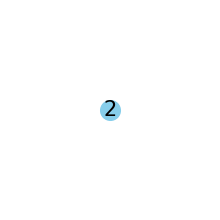

In [7]:
def generate_single_node_dag(nodes):
    if len(nodes) == 1:  # Check if there's only one node
        G = nx.DiGraph()
        G.add_node(nodes[0])  # Add the single node without any edges
        return [G]  # Return a list containing this single-node graph
    else:
        return []  # Return an empty list if more than one node is provided

# Nodes in the graph
nodes = [2]

# Generate a single-node DAG
valid_dags_1_gate = generate_single_node_dag(nodes)

# Visualize the DAG
if valid_dags_1_gate:  # Ensure there's at least one DAG generated
    G = valid_dags_1_gate[0]  # Get the single-node DAG
    print(f"Generated a single-node DAG with node: {list(G.nodes())}")
else:
    print("No valid DAGs generated.")
    
plt.figure(figsize=(2, 2))
pos = nx.spring_layout(G)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=200, 
        edge_color='k', linewidths=1, font_size=15, 
        arrows=True, arrowsize=10)
plt.show()    

In [ ]:
extended_dags_1_gate = extend_graph_with_new_nodes(valid_dags_1_gate, new_nodes=[0, 1])

print(f"Number of extended DAGs: {len(extended_dags_1_gate)}")

In [ ]:
extended_dags_1_gate_v2 = extend_graph_with_new_nodes_v2(valid_dags_1_gate, new_nodes=[0, 1])

print(f"Number of extended DAGs: {len(extended_dags_1_gate_v2)}")

In [ ]:
G = extended_dags_1_gate[0]

plt.figure(figsize=(1, 1))
pos = nx.spring_layout(G)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
        edge_color='k', linewidths=1, font_size=8, 
        arrows=True, arrowsize=10)
plt.show()  

## 2 gates

In [ ]:
# Nodes in the graph
nodes = [2, 3]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_2_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_2_gates)}")

In [ ]:
for i in range(0, len(valid_dags_2_gates)):

    G = valid_dags_2_gates[i]
    plt.figure(figsize=(1, 1))
    pos = nx.spring_layout(G)  # Positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
            edge_color='k', linewidths=1, font_size=8, 
            arrows=True, arrowsize=10)
    plt.show()  

In [ ]:
extended_dags_2_gates = extend_graph_with_new_nodes(valid_dags_2_gates, new_nodes=[0, 1])

print(f"Number of extended DAGs: {len(extended_dags_2_gates)}")

In [ ]:
extended_dags_2_gates_v2 = extend_graph_with_new_nodes_v2(valid_dags_2_gates, new_nodes=[0, 1])

print(f"Number of extended DAGs: {len(extended_dags_2_gates_v2)}")

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math

# Assuming extended_dags_2_gates is your collection of graphs
n_graphs = len(extended_dags_2_gates)  # Total number of graphs

# Calculate the number of rows and columns for the subplot grid
#n_cols = math.ceil(math.sqrt(n_graphs))
n_cols = 8
n_rows = math.ceil(n_graphs / n_cols)

# Set the overall figure size based on the number of columns and rows
# Each subplot is roughly (1, 1) in size, but you might need to adjust the figure size to avoid overlap
fig_size_width = n_cols * 1.5  # Slightly increase the size for margins
fig_size_height = n_rows * 1.5  # Slightly increase the size for margins
plt.figure(figsize=(fig_size_width, fig_size_height))

for i, G in enumerate(extended_dags_2_gates.values(), start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

## 3 gates

In [ ]:
# Nodes in the graph
nodes = [2, 3, 4]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_3_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_3_gates)}")

In [ ]:
for i in range(0, len(valid_dags_3_gates)):

    G = valid_dags_3_gates[i]
    plt.figure(figsize=(1, 1))
    pos = nx.spring_layout(G)  # Positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
            edge_color='k', linewidths=1, font_size=8, 
            arrows=True, arrowsize=10)
    plt.show()  

In [ ]:
extended_dags_3_gates = extend_graph_with_new_nodes(valid_dags_3_gates, new_nodes=[0, 1])

print(f"Number of extended DAGs: {len(extended_dags_3_gates)}")

In [ ]:
extended_dags_3_gates_v2 = extend_graph_with_new_nodes_v2(valid_dags_3_gates, new_nodes=[0, 1])

print(f"Number of extended DAGs: {len(extended_dags_3_gates_v2)}")

In [ ]:
import networkx as nx

def find_unique_graphs(dict1, dict2):
    # Stores the graphs unique to each dictionary
    unique_to_dict1 = []
    unique_to_dict2 = []

    # Check each graph in dict1 for uniqueness
    for key1, graph1 in dict1.items():
        is_unique = True
        for graph2 in dict2.values():
            if nx.is_isomorphic(graph1, graph2):
                is_unique = False
                break
        if is_unique:
            unique_to_dict1.append(key1)

    # Check each graph in dict2 for uniqueness
    for key2, graph2 in dict2.items():
        is_unique = True
        for graph1 in dict1.values():
            if nx.is_isomorphic(graph2, graph1):
                is_unique = False
                break
        if is_unique:
            unique_to_dict2.append(key2)

    return unique_to_dict1, unique_to_dict2


# Call the function to find unique graphs
unique_to_dict1, unique_to_dict2 = find_unique_graphs(extended_dags_3_gates, extended_dags_3_gates_v2)

print("Unique to dict1:", unique_to_dict1)
print("Unique to dict2:", unique_to_dict2)



In [ ]:
for i in range(0, len(unique_to_dict2)):

    G = extended_dags_3_gates_v2[unique_to_dict2[i]]
    print(unique_to_dict2[i])
    plt.figure(figsize=(1, 1))
    pos = nx.spring_layout(G)  # Positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
            edge_color='k', linewidths=1, font_size=8, 
            arrows=True, arrowsize=10)
    plt.show()  

In [ ]:
# Assuming extended_dags_3_gates is your collection of graphs
n_graphs = len(extended_dags_3_gates)  # Total number of graphs

# Calculate the number of rows and columns for the subplot grid
#n_cols = math.ceil(math.sqrt(n_graphs))
n_cols = 8
n_rows = math.ceil(n_graphs / n_cols)

# Set the overall figure size based on the number of columns and rows
# Each subplot is roughly (1, 1) in size, but you might need to adjust the figure size to avoid overlap
fig_size_width = n_cols * 1.5  # Slightly increase the size for margins
fig_size_height = n_rows * 1.5  # Slightly increase the size for margins
plt.figure(figsize=(fig_size_width, fig_size_height))

for i, G in enumerate(extended_dags_3_gates.values(), start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

## 4 gates

In [ ]:
# Nodes in the graph
nodes = [2, 3, 4, 5]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_4_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_4_gates)}")

In [ ]:
extended_dags_4_gates = extend_graph_with_new_nodes(valid_dags_4_gates, new_nodes=[0, 1])

print(f"Number of extended DAGs: {len(extended_dags_4_gates)}")

In [ ]:
extended_dags_4_gates_v2 = extend_graph_with_new_nodes_v2(valid_dags_4_gates, new_nodes=[0, 1])

print(f"Number of extended DAGs: {len(extended_dags_4_gates_v2)}")

In [ ]:
#this takes long to run
"""
# Call the function to find unique graphs
unique_to_dict1, unique_to_dict2 = find_unique_graphs(extended_dags_4_gates, extended_dags_4_gates_v2)

print("Unique to dict1:", unique_to_dict1)
print("Unique to dict2:", unique_to_dict2)

for i in range(0, 5):

    G = extended_dags_4_gates_v2[unique_to_dict2[i]]
    print(unique_to_dict2[i])
    plt.figure(figsize=(1, 1))
    pos = nx.spring_layout(G)  # Positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
            edge_color='k', linewidths=1, font_size=8, 
            arrows=True, arrowsize=10)
    plt.show()  
"""


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_4_gates is your list or dictionary of NetworkX graphs
graphs_list = list(extended_dags_4_gates.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
extended_dags_4_gates
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

## 5 gates

In [ ]:
# Nodes in the graph
nodes = [2, 3, 4, 5, 6]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_5_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_5_gates)}")

In [ ]:
extended_dags_5_gates = extend_graph_with_new_nodes(valid_dags_5_gates, new_nodes=[0, 1])

print(f"Number of extended DAGs: {len(extended_dags_5_gates)}")

In [ ]:
extended_dags_5_gates_v2 = extend_graph_with_new_nodes_v2(valid_dags_5_gates, new_nodes=[0, 1])

print(f"Number of extended DAGs: {len(extended_dags_5_gates_v2)}")

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(extended_dags_5_gates.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
extended_dags_5_gates
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(extended_dags_5_gates_v2.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
extended_dags_5_gates_v2
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

Joining the lists

In [ ]:
def add_graph_with_unique_key(target_dict, graph, original_key):
    """
    Adds a graph to the target dictionary with a unique integer key.
    If the original key is available, it's used; otherwise, a new unique key is generated.
    """
    if original_key not in target_dict:
        target_dict[original_key] = graph
    else:
        # Find the next available unique integer key
        new_key = max(target_dict.keys(), default=0) + 1
        target_dict[new_key] = graph

# Assuming the dictionaries are named extended_dags_1_gate, extended_dags_2_gates, etc.
graphs_library_2_input = {}
for d in [extended_dags_1_gate_v2, extended_dags_2_gates_v2, extended_dags_3_gates_v2, extended_dags_4_gates_v2, extended_dags_5_gates_v2]:
    for key, graph in d.items():
        add_graph_with_unique_key(graphs_library_2_input, graph, key)


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(graphs_library_2_input.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
graphs_library_2_input
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

Add output node

In [ ]:
graphs_library_2_input = add_edge_to_sink_nodes_with_output_type(graphs_library_2_input)

In [ ]:
# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(graphs_library_2_input.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
graphs_library_2_input
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

Filter out graphs with 3 inputs

In [ ]:
graphs_to_remove = []

for graph_key, G in graphs_library_2_input.items():
    # Count nodes with no incoming edges
    no_incoming_edges = [node for node in G.nodes() if G.in_degree(node) == 0]
    
    # If more than two nodes have no incoming edges, mark this graph for removal
    if len(no_incoming_edges) > 2:
        graphs_to_remove.append(graph_key)

# Remove the identified graphs from the dictionary
for graph_key in graphs_to_remove:
    del graphs_library_2_input[graph_key]

Organize them by truth table

In [ ]:
len(graphs_library_2_input)

In [ ]:
G = graphs_library_2_input[0]

plt.figure(figsize=(1, 1))
pos = nx.spring_layout(G)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
        edge_color='k', linewidths=1, font_size=8, 
        arrows=True, arrowsize=10)
plt.show()  

for node, attributes in G.nodes(data=True):
    node_type = attributes.get('type', 'No type specified')  # Default to 'No type specified' if 'type' not found
    print(f"Node {node} has type: {node_type}")

Check if any graph has more than 1 output

In [ ]:
import networkx as nx

# Example function to find and print graphs with more than one node without outgoing edges
def print_graphs_with_multiple_sink_nodes(graphs_dict):
    for graph_key, G in graphs_dict.items():
        # Count nodes without outgoing edges
        nodes_without_outgoing = [node for node in G.nodes() if G.out_degree(node) == 0]
        
        if len(nodes_without_outgoing) > 1:
            print(f"Graph with key '{graph_key}' has more than one node without outgoing edges. Nodes: {nodes_without_outgoing}")

# Use the function
print_graphs_with_multiple_sink_nodes(graphs_library_2_input)


Create permutations of inputs

In [ ]:
len(graphs_library_2_input)

In [ ]:


from tqdm.notebook import tqdm
import copy
import itertools

# Iterate over all graphs in the dictionary (using tqdm for progress bar)
for graph_id, graph in tqdm(list(graphs_library_2_input.items()), desc="Processing graphs"):
    # Identify input nodes by assuming they have the smallest IDs, adjust accordingly
    # This also assumes that input nodes are the first N integer IDs
    input_nodes = sorted([n for n, d in graph.nodes(data=True) if d.get('type') == 'input'])
    
    # Generate all permutations of the input nodes
    permutations = list(itertools.permutations(input_nodes))
    #print("all permutations of the input nodes done")
    
    for permutation in permutations:
        # We don't need to permute if the permutation is the same as the original order
        if permutation != tuple(input_nodes):
            # Create a new graph with permuted inputs
            new_graph = permute_graph_inputs(copy.deepcopy(graph), input_nodes, permutation)
            
            # Find the next available integer key
            next_key = max(graphs_library_2_input.keys()) + 1
            
            # Add the new graph to the dictionary
            graphs_library_2_input[next_key] = new_graph

In [ ]:
len(graphs_library_2_input)

Finally, organize by truth table

In [ ]:
precomputed_graphs_2_input = {}

# Function to check if a graph is isomorphic to any graph in a list
def is_graph_isomorphic(new_graph, graph_list, graphs_library):
    for graph_id in graph_list:
        # Retrieve a graph from the library using its identifier
        G = graphs_library[graph_id]
        # Check if the ffnew graph is isomorphic to this graph
        if nx.is_isomorphic(new_graph, G):
            #print("Graph is isomorphic")
            return True  # Found an isomorphic graph
    return False  # No isomorphic graph found

for graph_id, G in graphs_library_2_input.items():
    truth_table = calculate_truth_table(G)
    truth_table_index = truth_table_to_index(truth_table)
    
    # If the truth table index is new, initialize with the current graph ID
    if truth_table_index not in precomputed_graphs_2_input:
        precomputed_graphs_2_input[truth_table_index] = [graph_id]
    else:
        # For existing truth table index, check for isomorphism only if more than 1 graph already exists for this index
        if len(precomputed_graphs_2_input[truth_table_index]) >= 1:
            if not is_graph_isomorphic(G, precomputed_graphs_2_input[truth_table_index], graphs_library_2_input):
                precomputed_graphs_2_input[truth_table_index].append(graph_id)
        else:
            # If it's the first graph being compared for this truth table index, add it without isomorphism check
            precomputed_graphs_2_input[truth_table_index].append(graph_id)

In [ ]:
for key in precomputed_graphs_2_input:
    print(key)

In [ ]:
precomputed_graphs_2_input

Save the library

In [ ]:


import pickle

# Save graphs_library_2_input
with open('graphs_library_2_input_v2.pkl', 'wb') as file:
    pickle.dump(graphs_library_2_input, file)

# Save precomputed_graphs_2_input
with open('precomputed_graphs_2_input_v2.pkl', 'wb') as file:
    pickle.dump(precomputed_graphs_2_input, file)
    
    
  

In [ ]:
"""
#Load example 

import pickle

# Load graphs_library_2_input
with open('graphs_library_2_input_v2.pkl', 'rb') as file:
    graphs_library_2_input = pickle.load(file)

# Load precomputed_graphs_2_input
with open('precomputed_graphs_2_input_v2.pkl', 'rb') as file:
    precomputed_graphs_2_input = pickle.load(file)
"""

Some testing

In [ ]:
import pandas as pd

G = graphs_library_2_input[6004]
plt.figure(figsize=(2, 2))
pos = nx.spring_layout(G)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=200, 
        edge_color='k', linewidths=1, font_size=15, 
        arrows=True, arrowsize=10)
plt.show()

truth_table = calculate_truth_table(G)
df_truth_table = pd.DataFrame(list(truth_table.items()), columns=['Inputs', 'Output'])
display(df_truth_table)

In [ ]:
Gimportant = nx.DiGraph()

edges = [
    (0, 2), (0, 3), (1, 3), (1, 4), (3, 2), (3, 4), (2, 5), (4, 5), (5, 6)
]
Gimportant.add_node(0)  # Adding a single node
Gimportant.add_node(1)  # Adding a single node

Gimportant.add_edges_from(edges)

Gimportant.nodes[0]['type'] = 'input'
Gimportant.nodes[1]['type'] = 'input'
Gimportant.nodes[6]['type'] = 'output'

G = Gimportant
plt.figure(figsize=(2, 2))
pos = nx.spring_layout(G)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=200, 
        edge_color='k', linewidths=1, font_size=15, 
        arrows=True, arrowsize=10)
plt.show()

for node, attributes in G.nodes(data=True):
    node_type = attributes.get('type', 'No type specified')  # Default to 'No type specified' if 'type' not found
    print(f"Node {node} has type: {node_type}")
    


truth_table = calculate_truth_table(G)
df_truth_table = pd.DataFrame(list(truth_table.items()), columns=['Inputs', 'Output'])
display(df_truth_table)

In [ ]:
def find_and_print_isomorphic_graphs(Gimportant, precomputed_graphs_2_input, graphs_library_2_input):
    isomorphic_graph_ids = []  # List to keep track of isomorphic graph IDs
    
    for truth_table_index, graph_ids in precomputed_graphs_2_input.items():  # Assuming lists of graph IDs
        for graph_id in graph_ids:
            # Retrieve each graph using its ID from the library
            G = graphs_library_2_input[graph_id]
            # Check if the new graph is isomorphic to this graph
            if nx.is_isomorphic(Gimportant, G):
                isomorphic_graph_ids.append(graph_id)  # Add the ID of the isomorphic graph
    
    # Check if we found any isomorphic graphs and print information
    if isomorphic_graph_ids:
        print("Gimportant is isomorphic to the following graphs in precomputed graphs:")
        for graph_id in isomorphic_graph_ids:
            print(f"- Graph ID: {graph_id} (Truth Table Index: {truth_table_index})")
    else:
        print("Gimportant is not isomorphic to any graph in precomputed graphs.")


# Then call it like this:
find_and_print_isomorphic_graphs(Gimportant, precomputed_graphs_2_input, graphs_library_2_input)




In [ ]:
G = Gimportant
plt.figure(figsize=(2, 2))
pos = nx.spring_layout(G)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=200, 
        edge_color='k', linewidths=1, font_size=15, 
        arrows=True, arrowsize=10)
plt.show()

In [ ]:
def find_isomorphic_graphs(G, graphs_dict):
    isomorphic_graph_ids = []  # To store IDs of isomorphic graphs

    for graph_id, extended_G in graphs_dict.items():
        if nx.is_isomorphic(G, extended_G):
            isomorphic_graph_ids.append(graph_id)

    return isomorphic_graph_ids

# Assuming `G` is your graph of interest and `extended_dags_dict` is the dictionary of extended DAGs
isomorphic_ids = find_isomorphic_graphs(Gimportant, graphs_library_2_input)

if isomorphic_ids:
    print(f"Graph G is isomorphic to the following graphs in extended_dags_dict: {isomorphic_ids}")
else:
    print("Graph G is not isomorphic to any graph in extended_dags_dict.")

# Generate library, 1-input, 1-output

In [8]:
import itertools
import networkx as nx
import matplotlib.pyplot as plt

def is_valid_dag(G):
    # Check if there is exactly one source node (node with no incoming edges)
    sources = [node for node in G.nodes() if G.in_degree(node) == 0]
    
    # Check if there is exactly one sink node (node with no outgoing edges)
    sinks = [node for node in G.nodes() if G.out_degree(node) == 0]
    
    # Check if any node has more than 2 incoming edges
    more_than_two_incoming = any(G.in_degree(node) > 2 for node in G.nodes())
    
    # The graph is valid if there's exactly one source and sink, and no node has more than 2 incoming edges
    return len(sources) == 1 and len(sinks) == 1 and not more_than_two_incoming


def generate_dags_with_constraints(n):
    all_dags = []
    nodes = range(n)
    all_edges = list(itertools.permutations(nodes, 2))
    for edges_subset in itertools.chain.from_iterable(itertools.combinations(all_edges, r) for r in range(len(all_edges) + 1)):
        G = nx.DiGraph(list(edges_subset))
        if nx.is_directed_acyclic_graph(G) and is_valid_dag(G):
            all_dags.append(G)
    return all_dags

def add_edge_to_sink_nodes_dict(graphs_dict):
    extended_graphs_dict = {}
    for graph_id, G in graphs_dict.items():
        G_modified = G.copy()
        sink_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]
        if len(sink_nodes) == 1:
            sink_node = sink_nodes[0]
            new_node = max(G.nodes(), default=-1) + 1
            G_modified.add_node(new_node, type='output')
            G_modified.add_edge(sink_node, new_node)
        extended_graphs_dict[graph_id] = G_modified
    return extended_graphs_dict

# Generate DAGs for 1 to 4 nodes and organize them in a dictionary (one done is already the input)
graphs_library_1_input = {}
for n in range(1, 5):
    dags = generate_dags_with_constraints(n)
    for i, dag in enumerate(dags, start=1):
        graphs_library_1_input[len(graphs_library_1_input)] = dag

# Apply modifications
graphs_library_1_input = add_edge_to_sink_nodes_dict(graphs_library_1_input)


# Assume the functions 'calculate_truth_table', 'truth_table_to_index', and 'is_graph_isomorphic' are defined correctly elsewhere
precomputed_graphs_1_input = {}
# Organize by truth table
for graph_id, G in graphs_library_1_input.items():
    # Assume calculate_truth_table and truth_table_to_index are defined and work as expected
    truth_table = calculate_truth_table(G)  # Placeholder
    truth_table_index = truth_table_to_index(truth_table)  # Placeholder
    if truth_table_index not in precomputed_graphs_1_input:
        precomputed_graphs_1_input[truth_table_index] = [graph_id]
    else:
        if not is_graph_isomorphic(G, precomputed_graphs_1_input[truth_table_index], graphs_library_1_input):
            precomputed_graphs_1_input[truth_table_index].append(graph_id)


In [9]:
def label_input_nodes_in_graphs(graphs_library):
    # Iterate through each graph in the library
    for graph_id, G in graphs_library.items():
        # Iterate through each node in the graph
        for node in G.nodes():
            # Check if the node has no incoming edges (in-degree of 0)
            if G.in_degree(node) == 0:
                # Label the node as 'input'
                G.nodes[node]['type'] = 'input'

# Assuming graphs_library_1_input is already defined and populated
# with your graph objects, apply the labeling function
label_input_nodes_in_graphs(graphs_library_1_input)

In [10]:
precomputed_graphs_1_input

{2: [0, 60, 108, 188], 1: [8, 107, 194], 0: [14, 105], 3: [104]}

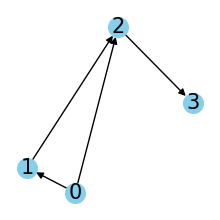

Node 0 has type: input
Node 1 has type: No type specified
Node 2 has type: No type specified
Node 3 has type: output


,Inputs,Output
0,"(0,)","(0,)"
1,"(1,)","(0,)"


In [12]:
G = graphs_library_1_input[14]
plt.figure(figsize=(2, 2))
pos = nx.spring_layout(G)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=200, 
        edge_color='k', linewidths=1, font_size=15, 
        arrows=True, arrowsize=10)
plt.show()

for node, attributes in G.nodes(data=True):
    node_type = attributes.get('type', 'No type specified')  # Default to 'No type specified' if 'type' not found
    print(f"Node {node} has type: {node_type}")
    

truth_table = calculate_truth_table(G)
df_truth_table = pd.DataFrame(list(truth_table.items()), columns=['Inputs', 'Output'])
display(df_truth_table)

In [ ]:
import pickle

# Save graphs_library_1_input
with open('graphs_library_1_input.pkl', 'wb') as file:
    pickle.dump(graphs_library_1_input, file)

# Save precomputed_graphs_1_input
with open('precomputed_graphs_1_input.pkl', 'wb') as file:
    pickle.dump(precomputed_graphs_1_input, file)

# Generate library, 3-input, 1-output (no cello motifs)

## 2 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_2_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_2_gates)}")

In [ ]:
for i in range(0, len(valid_dags_2_gates)):

    G = valid_dags_2_gates[i]
    plt.figure(figsize=(1, 1))
    pos = nx.spring_layout(G)  # Positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
            edge_color='k', linewidths=1, font_size=8, 
            arrows=True, arrowsize=10)
    plt.show()  

In [ ]:
extended_dags_2_gates = extend_graph_with_new_nodes_v2(valid_dags_2_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_2_gates)}")

In [ ]:
(type(extended_dags_2_gates))



In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math

# Assuming extended_dags_2_gates is your collection of graphs
n_graphs = len(extended_dags_2_gates)  # Total number of graphs

# Calculate the number of rows and columns for the subplot grid
#n_cols = math.ceil(math.sqrt(n_graphs))
n_cols = 8
n_rows = math.ceil(n_graphs / n_cols)

# Set the overall figure size based on the number of columns and rows
# Each subplot is roughly (1, 1) in size, but you might need to adjust the figure size to avoid overlap
fig_size_width = n_cols * 1.5  # Slightly increase the size for margins
fig_size_height = n_rows * 1.5  # Slightly increase the size for margins
plt.figure(figsize=(fig_size_width, fig_size_height))

for i, G in enumerate(extended_dags_2_gates.values(), start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

## 3 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4, 5]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_3_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_3_gates)}")

In [ ]:
for i in range(0, len(valid_dags_3_gates)):

    G = valid_dags_3_gates[i]
    plt.figure(figsize=(1, 1))
    pos = nx.spring_layout(G)  # Positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
            edge_color='k', linewidths=1, font_size=8, 
            arrows=True, arrowsize=10)
    plt.show()  

In [ ]:
extended_dags_3_gates = extend_graph_with_new_nodes_v2(valid_dags_3_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_3_gates)}")

In [ ]:
# Assuming extended_dags_3_gates is your collection of graphs
n_graphs = len(extended_dags_3_gates)  # Total number of graphs

# Calculate the number of rows and columns for the subplot grid
#n_cols = math.ceil(math.sqrt(n_graphs))
n_cols = 8
n_rows = math.ceil(n_graphs / n_cols)

# Set the overall figure size based on the number of columns and rows
# Each subplot is roughly (1, 1) in size, but you might need to adjust the figure size to avoid overlap
fig_size_width = n_cols * 1.5  # Slightly increase the size for margins
fig_size_height = n_rows * 1.5  # Slightly increase the size for margins
plt.figure(figsize=(fig_size_width, fig_size_height))

for i, G in enumerate(extended_dags_3_gates.values(), start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

## 4 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4, 5, 6]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_4_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_4_gates)}")

In [ ]:
extended_dags_4_gates = extend_graph_with_new_nodes_v2(valid_dags_4_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_4_gates)}")

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_4_gates is your list or dictionary of NetworkX graphs
graphs_list = list(extended_dags_4_gates.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
extended_dags_4_gates
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

## 5 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4, 5, 6, 7]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_5_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_5_gates)}")

In [ ]:
# This takes too much computation 

"""

extended_dags_5_gates = extend_graph_with_new_nodes_v2(valid_dags_5_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_5_gates)}")

"""

In [ ]:
"""

import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(extended_dags_5_gates.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
extended_dags_5_gates
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

"""

Joining the lists

In [ ]:
def add_graph_with_unique_key(target_dict, graph, original_key):
    """
    Adds a graph to the target dictionary with a unique integer key.
    If the original key is available, it's used; otherwise, a new unique key is generated.
    """
    if original_key not in target_dict:
        target_dict[original_key] = graph
    else:
        # Find the next available unique integer key
        new_key = max(target_dict.keys(), default=0) + 1
        target_dict[new_key] = graph

# Assuming the dictionaries are named extended_dags_1_gate, extended_dags_2_gates, etc.
graphs_library_3_input_exhaustive = {}
for d in [extended_dags_2_gates, extended_dags_3_gates, extended_dags_4_gates]:
    for key, graph in d.items():
        add_graph_with_unique_key(graphs_library_3_input_exhaustive, graph, key)


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(graphs_library_3_input_exhaustive.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
graphs_library_3_input_exhaustive
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

Add output node

In [ ]:
graphs_library_3_input_exhaustive = add_edge_to_sink_nodes_with_output_type(graphs_library_3_input_exhaustive)

In [ ]:
# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(graphs_library_3_input_exhaustive.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
graphs_library_3_input_exhaustive
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

Filter out graphs with more than 3 inputs

In [ ]:
graphs_to_remove = []

for graph_key, G in graphs_library_3_input_exhaustive.items():
    # Count nodes with no incoming edges
    no_incoming_edges = [node for node in G.nodes() if G.in_degree(node) == 0]
    
    # If more than 3 nodes have no incoming edges, mark this graph for removal
    if len(no_incoming_edges) != 3:
        graphs_to_remove.append(graph_key)

# Remove the identified graphs from the dictionary
for graph_key in graphs_to_remove:
    del graphs_library_3_input_exhaustive[graph_key]

In [ ]:
graphs_library_3_input_exhaustive

In [ ]:
len(graphs_library_3_input_exhaustive)

In [ ]:
#IM HERE

Permute the inputs

In [ ]:
#For each graph in 'graphs_library_3_input', which is a dictionary of graphs, generate all other graphs by permuting its inputs. The inputs are 3, and have the node type 'input'. Add the new graphs at the end of the dictionary. The keys in the dictionary are integers.

import itertools
import copy
import networkx as nx

# This example assumes 'graphs_library_3_input' is already defined and is a dictionary of NetworkX graphs.

def permute_graph_inputs(graph, original_inputs, permutation):
    # Create a mapping from original node IDs to their permuted IDs
    mapping = {old_id: new_id for old_id, new_id in zip(original_inputs, permutation)}
    # Use NetworkX to relabel the nodes according to the mapping
    return nx.relabel_nodes(graph, mapping)

# Iterate over all graphs in the dictionary (using list() to avoid RuntimeError)
for graph_id, graph in tqdm(list(graphs_library_3_input_exhaustive.items())):
    # Identify input nodes by assuming they have the smallest IDs, adjust accordingly
    # This also assumes that input nodes are the first N integer IDs
    input_nodes = sorted([n for n, d in graph.nodes(data=True) if d.get('type') == 'input'])
    
    # Generate all permutations of the input nodes
    permutations = list(itertools.permutations(input_nodes))
    
    for permutation in permutations:
        # We don't need to permute if the permutation is the same as the original order
        if permutation != tuple(input_nodes):
            # Create a new graph with permuted inputs
            new_graph = permute_graph_inputs(copy.deepcopy(graph), input_nodes, permutation)
            
            # Find the next available integer key
            next_key = max(graphs_library_3_input_exhaustive.keys()) + 1
            
            # Add the new graph to the dictionary
            graphs_library_3_input_exhaustive[next_key] = new_graph

In [ ]:
len(graphs_library_3_input_exhaustive)

Join the dictionaries (Exhaustive)

In [ ]:
def add_graph_with_unique_key(target_dict, graph, original_key):
    """
    Adds a graph to the target dictionary with a unique integer key.
    If the original key is available, it's used; otherwise, a new unique key is generated.
    """
    if original_key not in target_dict:
        target_dict[original_key] = graph
    else:
        # Find the next available unique integer key
        new_key = max(target_dict.keys(), default=0) + 1
        target_dict[new_key] = graph

# Assuming the dictionaries are named extended_dags_1_gate, extended_dags_2_gates, etc.
graphs_library_3_input = {}
for d in [graphs_library_3_input_exhaustive]:
    for key, graph in d.items():
        add_graph_with_unique_key(graphs_library_3_input, graph, key)

In [ ]:
len(graphs_library_3_input)

Organize by truth table (Boolean function)

In [ ]:
precomputed_graphs_3_input = {}

# Function to check if a graph is isomorphic to any graph in a list
def is_graph_isomorphic(new_graph, graph_list, graphs_library):
    for graph_id in graph_list:
        # Retrieve a graph from the library using its identifier
        G = graphs_library[graph_id]
        # Check if the ffnew graph is isomorphic to this graph
        if nx.is_isomorphic(new_graph, G):
            #print("Graph is isomorphic")
            return True  # Found an isomorphic graph
    return False  # No isomorphic graph found

for graph_id, G in tqdm(graphs_library_3_input.items(), desc="Checking Graphs"):
    truth_table = calculate_truth_table(G)
    truth_table_index = truth_table_to_index(truth_table)
    
    # If the truth table index is new, initialize with the current graph ID
    if truth_table_index not in precomputed_graphs_3_input:
        precomputed_graphs_3_input[truth_table_index] = [graph_id]
    else:
        # For existing truth table index, check for isomorphism only if more than 1 graph already exists for this index
        if len(precomputed_graphs_3_input[truth_table_index]) >= 1:
            if not is_graph_isomorphic(G, precomputed_graphs_3_input[truth_table_index], graphs_library_3_input):
                precomputed_graphs_3_input[truth_table_index].append(graph_id)
        else:
            # If it's the first graph being compared for this truth table index, add it without isomorphism check
            precomputed_graphs_3_input[truth_table_index].append(graph_id)

In [ ]:
len(precomputed_graphs_3_input)

Save the library

In [ ]:
for key in precomputed_graphs_3_input:
    print(key)

In [ ]:
precomputed_graphs_3_input

In [ ]:
len(precomputed_graphs_3_input)

In [ ]:


import pickle

# Save graphs_library_3_input
with open('graphs_library_3_input_v2_no_cello_motifs.pkl', 'wb') as file:
    pickle.dump(graphs_library_3_input, file)

# Save precomputed_graphs_3_input  
with open('precomputed_graphs_3_input_v2_no_cello_motifs.pkl', 'wb') as file:
    pickle.dump(precomputed_graphs_3_input, file)
    


# Generate library, 3-input, 1-output (with cello 2.0 motifs)

## 2 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_2_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_2_gates)}")

In [ ]:
for i in range(0, len(valid_dags_2_gates)):

    G = valid_dags_2_gates[i]
    plt.figure(figsize=(1, 1))
    pos = nx.spring_layout(G)  # Positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
            edge_color='k', linewidths=1, font_size=8, 
            arrows=True, arrowsize=10)
    plt.show()  

In [ ]:
extended_dags_2_gates = extend_graph_with_new_nodes_v2(valid_dags_2_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_2_gates)}")

In [ ]:
(type(extended_dags_2_gates))



In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math

# Assuming extended_dags_2_gates is your collection of graphs
n_graphs = len(extended_dags_2_gates)  # Total number of graphs

# Calculate the number of rows and columns for the subplot grid
#n_cols = math.ceil(math.sqrt(n_graphs))
n_cols = 8
n_rows = math.ceil(n_graphs / n_cols)

# Set the overall figure size based on the number of columns and rows
# Each subplot is roughly (1, 1) in size, but you might need to adjust the figure size to avoid overlap
fig_size_width = n_cols * 1.5  # Slightly increase the size for margins
fig_size_height = n_rows * 1.5  # Slightly increase the size for margins
plt.figure(figsize=(fig_size_width, fig_size_height))

for i, G in enumerate(extended_dags_2_gates.values(), start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

## 3 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4, 5]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_3_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_3_gates)}")

In [ ]:
for i in range(0, len(valid_dags_3_gates)):

    G = valid_dags_3_gates[i]
    plt.figure(figsize=(1, 1))
    pos = nx.spring_layout(G)  # Positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
            edge_color='k', linewidths=1, font_size=8, 
            arrows=True, arrowsize=10)
    plt.show()  

In [ ]:
extended_dags_3_gates = extend_graph_with_new_nodes_v2(valid_dags_3_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_3_gates)}")

In [ ]:
# Assuming extended_dags_3_gates is your collection of graphs
n_graphs = len(extended_dags_3_gates)  # Total number of graphs

# Calculate the number of rows and columns for the subplot grid
#n_cols = math.ceil(math.sqrt(n_graphs))
n_cols = 8
n_rows = math.ceil(n_graphs / n_cols)

# Set the overall figure size based on the number of columns and rows
# Each subplot is roughly (1, 1) in size, but you might need to adjust the figure size to avoid overlap
fig_size_width = n_cols * 1.5  # Slightly increase the size for margins
fig_size_height = n_rows * 1.5  # Slightly increase the size for margins
plt.figure(figsize=(fig_size_width, fig_size_height))

for i, G in enumerate(extended_dags_3_gates.values(), start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

## 4 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4, 5, 6]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_4_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_4_gates)}")

In [ ]:
extended_dags_4_gates = extend_graph_with_new_nodes_v2(valid_dags_4_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_4_gates)}")

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_4_gates is your list or dictionary of NetworkX graphs
graphs_list = list(extended_dags_4_gates.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
extended_dags_4_gates
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

## 5 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4, 5, 6, 7]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_5_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_5_gates)}")

In [ ]:
extended_dags_5_gates = extend_graph_with_new_nodes_v2(valid_dags_5_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_5_gates)}")

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(extended_dags_5_gates.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
extended_dags_5_gates
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

Joining the lists

In [ ]:
def add_graph_with_unique_key(target_dict, graph, original_key):
    """
    Adds a graph to the target dictionary with a unique integer key.
    If the original key is available, it's used; otherwise, a new unique key is generated.
    """
    if original_key not in target_dict:
        target_dict[original_key] = graph
    else:
        # Find the next available unique integer key
        new_key = max(target_dict.keys(), default=0) + 1
        target_dict[new_key] = graph

# Assuming the dictionaries are named extended_dags_1_gate, extended_dags_2_gates, etc.
graphs_library_3_input_exhaustive = {}
for d in [extended_dags_2_gates, extended_dags_3_gates, extended_dags_4_gates]:
    for key, graph in d.items():
        add_graph_with_unique_key(graphs_library_3_input_exhaustive, graph, key)


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(graphs_library_3_input_exhaustive.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
graphs_library_3_input_exhaustive
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

Add output node

In [ ]:
graphs_library_3_input_exhaustive = add_edge_to_sink_nodes_with_output_type(graphs_library_3_input_exhaustive)

In [ ]:
# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(graphs_library_3_input_exhaustive.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
graphs_library_3_input_exhaustive
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

Filter out graphs with more than 3 inputs

In [ ]:
graphs_to_remove = []

for graph_key, G in graphs_library_3_input_exhaustive.items():
    # Count nodes with no incoming edges
    no_incoming_edges = [node for node in G.nodes() if G.in_degree(node) == 0]
    
    # If more than 3 nodes have no incoming edges, mark this graph for removal
    if len(no_incoming_edges) != 3:
        graphs_to_remove.append(graph_key)

# Remove the identified graphs from the dictionary
for graph_key in graphs_to_remove:
    del graphs_library_3_input_exhaustive[graph_key]

In [ ]:
graphs_library_3_input_exhaustive

In [ ]:
len(graphs_library_3_input_exhaustive)

In [ ]:
#IM HERE

Permute the inputs

In [ ]:
#For each graph in 'graphs_library_3_input', which is a dictionary of graphs, generate all other graphs by permuting its inputs. The inputs are 3, and have the node type 'input'. Add the new graphs at the end of the dictionary. The keys in the dictionary are integers.

import itertools
import copy
import networkx as nx

# This example assumes 'graphs_library_3_input' is already defined and is a dictionary of NetworkX graphs.

def permute_graph_inputs(graph, original_inputs, permutation):
    # Create a mapping from original node IDs to their permuted IDs
    mapping = {old_id: new_id for old_id, new_id in zip(original_inputs, permutation)}
    # Use NetworkX to relabel the nodes according to the mapping
    return nx.relabel_nodes(graph, mapping)

# Iterate over all graphs in the dictionary (using list() to avoid RuntimeError)
for graph_id, graph in tqdm(list(graphs_library_3_input_exhaustive.items())):
    # Identify input nodes by assuming they have the smallest IDs, adjust accordingly
    # This also assumes that input nodes are the first N integer IDs
    input_nodes = sorted([n for n, d in graph.nodes(data=True) if d.get('type') == 'input'])
    
    # Generate all permutations of the input nodes
    permutations = list(itertools.permutations(input_nodes))
    
    for permutation in permutations:
        # We don't need to permute if the permutation is the same as the original order
        if permutation != tuple(input_nodes):
            # Create a new graph with permuted inputs
            new_graph = permute_graph_inputs(copy.deepcopy(graph), input_nodes, permutation)
            
            # Find the next available integer key
            next_key = max(graphs_library_3_input_exhaustive.keys()) + 1
            
            # Add the new graph to the dictionary
            graphs_library_3_input_exhaustive[next_key] = new_graph

In [ ]:
len(graphs_library_3_input_exhaustive)

Join the dictionaries (Exhaustive + Cello V2 motifs)

In [ ]:
import pickle

# Load NIGs_unoptimized_library_3_input_1_output
# Already permuted inputs
with open('Eco1C1G1T1_CelloV2_motifs.pkl', 'rb') as file:
    graphs_library_3_input_cello_V2_motifs = pickle.load(file)    
    



In [ ]:
len(graphs_library_3_input_cello_V2_motifs)

In [ ]:
def add_graph_with_unique_key(target_dict, graph, original_key):
    """
    Adds a graph to the target dictionary with a unique integer key.
    If the original key is available, it's used; otherwise, a new unique key is generated.
    """
    if original_key not in target_dict:
        target_dict[original_key] = graph
    else:
        # Find the next available unique integer key
        new_key = max(target_dict.keys(), default=0) + 1
        target_dict[new_key] = graph

# Assuming the dictionaries are named extended_dags_1_gate, extended_dags_2_gates, etc.
graphs_library_3_input = {}
for d in [graphs_library_3_input_exhaustive, graphs_library_3_input_cello_V2_motifs]:
    for key, graph in d.items():
        add_graph_with_unique_key(graphs_library_3_input, graph, key)

In [ ]:
len(graphs_library_3_input)

Organize by truth table (Boolean function)

In [ ]:
precomputed_graphs_3_input = {}

# Function to check if a graph is isomorphic to any graph in a list
def is_graph_isomorphic(new_graph, graph_list, graphs_library):
    for graph_id in graph_list:
        # Retrieve a graph from the library using its identifier
        G = graphs_library[graph_id]
        # Check if the ffnew graph is isomorphic to this graph
        if nx.is_isomorphic(new_graph, G):
            #print("Graph is isomorphic")
            return True  # Found an isomorphic graph
    return False  # No isomorphic graph found

for graph_id, G in tqdm(graphs_library_3_input.items(), desc="Checking Graphs"):
    truth_table = calculate_truth_table(G)
    truth_table_index = truth_table_to_index(truth_table)
    
    # If the truth table index is new, initialize with the current graph ID
    if truth_table_index not in precomputed_graphs_3_input:
        precomputed_graphs_3_input[truth_table_index] = [graph_id]
    else:
        # For existing truth table index, check for isomorphism only if more than 1 graph already exists for this index
        if len(precomputed_graphs_3_input[truth_table_index]) >= 1:
            if not is_graph_isomorphic(G, precomputed_graphs_3_input[truth_table_index], graphs_library_3_input):
                precomputed_graphs_3_input[truth_table_index].append(graph_id)
        else:
            # If it's the first graph being compared for this truth table index, add it without isomorphism check
            precomputed_graphs_3_input[truth_table_index].append(graph_id)

Save the library

In [ ]:
for key in precomputed_graphs_3_input:
    print(key)

In [ ]:
precomputed_graphs_3_input

In [ ]:
len(precomputed_graphs_3_input)

In [ ]:


import pickle

# Save graphs_library_3_input
with open('graphs_library_3_input_v2_with_cello_motifs.pkl', 'wb') as file:
    pickle.dump(graphs_library_3_input, file)

# Save precomputed_graphs_3_input  
with open('precomputed_graphs_3_input_v2_with_cello_motifs.pkl', 'wb') as file:
    pickle.dump(precomputed_graphs_3_input, file)

    

# Generate library, 3-input, 1-output (with ABC resyn2)

## 2 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_2_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_2_gates)}")

In [ ]:
for i in range(0, len(valid_dags_2_gates)):

    G = valid_dags_2_gates[i]
    plt.figure(figsize=(1, 1))
    pos = nx.spring_layout(G)  # Positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
            edge_color='k', linewidths=1, font_size=8, 
            arrows=True, arrowsize=10)
    plt.show()  

In [ ]:
extended_dags_2_gates = extend_graph_with_new_nodes_v2(valid_dags_2_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_2_gates)}")

In [ ]:
(type(extended_dags_2_gates))



In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math

# Assuming extended_dags_2_gates is your collection of graphs
n_graphs = len(extended_dags_2_gates)  # Total number of graphs

# Calculate the number of rows and columns for the subplot grid
#n_cols = math.ceil(math.sqrt(n_graphs))
n_cols = 8
n_rows = math.ceil(n_graphs / n_cols)

# Set the overall figure size based on the number of columns and rows
# Each subplot is roughly (1, 1) in size, but you might need to adjust the figure size to avoid overlap
fig_size_width = n_cols * 1.5  # Slightly increase the size for margins
fig_size_height = n_rows * 1.5  # Slightly increase the size for margins
plt.figure(figsize=(fig_size_width, fig_size_height))

for i, G in enumerate(extended_dags_2_gates.values(), start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

## 3 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4, 5]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_3_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_3_gates)}")

In [ ]:
for i in range(0, len(valid_dags_3_gates)):

    G = valid_dags_3_gates[i]
    plt.figure(figsize=(1, 1))
    pos = nx.spring_layout(G)  # Positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
            edge_color='k', linewidths=1, font_size=8, 
            arrows=True, arrowsize=10)
    plt.show()  

In [ ]:
extended_dags_3_gates = extend_graph_with_new_nodes_v2(valid_dags_3_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_3_gates)}")

In [ ]:
# Assuming extended_dags_3_gates is your collection of graphs
n_graphs = len(extended_dags_3_gates)  # Total number of graphs

# Calculate the number of rows and columns for the subplot grid
#n_cols = math.ceil(math.sqrt(n_graphs))
n_cols = 8
n_rows = math.ceil(n_graphs / n_cols)

# Set the overall figure size based on the number of columns and rows
# Each subplot is roughly (1, 1) in size, but you might need to adjust the figure size to avoid overlap
fig_size_width = n_cols * 1.5  # Slightly increase the size for margins
fig_size_height = n_rows * 1.5  # Slightly increase the size for margins
plt.figure(figsize=(fig_size_width, fig_size_height))

for i, G in enumerate(extended_dags_3_gates.values(), start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

## 4 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4, 5, 6]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_4_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_4_gates)}")

In [ ]:
extended_dags_4_gates = extend_graph_with_new_nodes_v2(valid_dags_4_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_4_gates)}")

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_4_gates is your list or dictionary of NetworkX graphs
graphs_list = list(extended_dags_4_gates.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
extended_dags_4_gates
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

## 5 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4, 5, 6, 7]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_5_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_5_gates)}")

In [ ]:
"""

extended_dags_5_gates = extend_graph_with_new_nodes_v2(valid_dags_5_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_5_gates)}")

"""

In [ ]:
"""

import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(extended_dags_5_gates.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
extended_dags_5_gates
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

"""

Joining the lists

In [ ]:
def add_graph_with_unique_key(target_dict, graph, original_key):
    """
    Adds a graph to the target dictionary with a unique integer key.
    If the original key is available, it's used; otherwise, a new unique key is generated.
    """
    if original_key not in target_dict:
        target_dict[original_key] = graph
    else:
        # Find the next available unique integer key
        new_key = max(target_dict.keys(), default=0) + 1
        target_dict[new_key] = graph

# Assuming the dictionaries are named extended_dags_1_gate, extended_dags_2_gates, etc.
graphs_library_3_input_exhaustive = {}
for d in [extended_dags_2_gates, extended_dags_3_gates, extended_dags_4_gates]:
    for key, graph in d.items():
        add_graph_with_unique_key(graphs_library_3_input_exhaustive, graph, key)


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(graphs_library_3_input_exhaustive.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
graphs_library_3_input_exhaustive
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

Add output node

In [ ]:
graphs_library_3_input_exhaustive = add_edge_to_sink_nodes_with_output_type(graphs_library_3_input_exhaustive)

In [ ]:
# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(graphs_library_3_input_exhaustive.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
graphs_library_3_input_exhaustive
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

Filter out graphs with more than 3 inputs

In [ ]:
graphs_to_remove = []

for graph_key, G in graphs_library_3_input_exhaustive.items():
    # Count nodes with no incoming edges
    no_incoming_edges = [node for node in G.nodes() if G.in_degree(node) == 0]
    
    # If more than 3 nodes have no incoming edges, mark this graph for removal
    if len(no_incoming_edges) != 3:
        graphs_to_remove.append(graph_key)

# Remove the identified graphs from the dictionary
for graph_key in graphs_to_remove:
    del graphs_library_3_input_exhaustive[graph_key]

In [ ]:
len(graphs_library_3_input_exhaustive)

Add synthesized with ABC

In [ ]:
import re
import numpy as np
#import matplotlib.pyplot as plt
#import gymnasium as gym
#from gymnasium import spaces
import subprocess

from IPython.display import Image
from graphviz import Source

from IPython.display import Image

#Naive approch using ABC
# Initialize a list to hold all circuit data
circuit_data = []
graphs_library_3_input_ABC = {}
#for i in numbers: #This for statement to run the dataset in random order
for i in range(1, 255): #This for statement to run the dataset  in order
    
    circuit_info = {}
    
    module_name = format(i, '02X')
    
    if module_name == '6A':
        print("There is some issue with this file")
        continue
       
   
    file_name = f"0x{module_name}"
    print("Circuit: ", file_name)
    
    #Load AIG file from dataset and optimize topology based on Cello's soure code
    #command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; rewrite; refactor; balance; write_aiger -s /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig"'
    
    #Load AIG file from dataset and optimize topology using resyn2
    command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; balance; rewrite; refactor; balance; rewrite; rewrite -z; balance; refactor -z; rewrite -z; balance; balance; rewrite; refactor; balance; rewrite; rewrite -z; balance; refactor -z; rewrite -z; balance;  write_aiger -s /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig"'
    
    
    #Load AIG file from dataset and DO NOT optimize topology
    #command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; write_aiger -s /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig"'
    
   
    
    result = subprocess.run(command, shell=True, capture_output=True, text=True)

    
    command = '~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig; ps"'
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    stdout_content = result.stdout

    # Use regular expression to find the number of AND nodes
    match = re.search(r'and =\s+(\d+)', stdout_content)
    if match:
        num_and_nodes = int(match.group(1))
        print(f"Number of AND nodes: {num_and_nodes}")

        # Save this number to a file
        with open('num_and_nodes.txt', 'w') as file:
            file.write(str(num_and_nodes))
    else:
        print("Number of AND nodes could not be found.")
        

    #Convert to ASCII AIG
    subprocess.run('~/aiger/aigtoaig /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aag', shell=True, capture_output=True, text=True)

    start_file_path = '/home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aag'

    #Convert to Adjecency Matrix
    adj_matrix = aiger_ascii_to_adj_matrix(start_file_path)  

    #Convert to NIG
    adj_matrix_negative_edges_replaced = replace_negative_edges(adj_matrix)

    nor_not_graph = covert_to_nor_not(adj_matrix_negative_edges_replaced)

    nor_not_graph_remove_redundant_not = remove_redundant_not_with_exclusions(nor_not_graph)
    
    
    num_of_inputs = count_nodes_with_no_incoming_edges_but_not_isolated(nor_not_graph_remove_redundant_not)

    
    if num_of_inputs != 3:
        print("Number of inputs is not 3. Ignoring this circuit.") 
        continue

    #Generate graph with such assignment
    G = assign_io_nodes(nor_not_graph_remove_redundant_not)
    
    # Find nodes in G that do not have outgoing edges (output nodes)
    #output_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]

    # There should typically be one output node in a circuit, but it's a good practice to check
    #for node in output_nodes:
    #    # Remove the node(s) from G
    #    G.remove_node(node)
    
    
    graphs_library_3_input_ABC[i] = G



In [ ]:
len(graphs_library_3_input_ABC)

In [ ]:
# Example to draw the graph for the first circuit
G = graphs_library_3_input_ABC[1]

plt.figure(figsize=(2, 2))
pos = nx.spring_layout(G)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
        edge_color='k', linewidths=1, font_size=8, 
        arrows=True, arrowsize=10)
plt.show()  
print_node_attributes(G)

In [ ]:
Gimportant = nx.DiGraph()

edges = [
    (0, 4), (1, 3), (1, 4), (2, 3), (3, 5), (4, 5), (5, 6)
]
Gimportant.add_node(0)  # Adding a single node
Gimportant.add_node(1)  # Adding a single node
Gimportant.add_node(2)  # Adding a single node

Gimportant.add_edges_from(edges)

Gimportant.nodes[0]['type'] = 'input'
Gimportant.nodes[1]['type'] = 'input'
Gimportant.nodes[2]['type'] = 'input'

Gimportant.nodes[6]['type'] = 'output'

#This code adds Gimportant to graphs_library_3_input_ABC at the end

max_key = max(graphs_library_3_input_ABC.keys())
next_key = max_key + 1
graphs_library_3_input_ABC[next_key] = Gimportant

Join the dictionaries (ABC + exhaustive)

In [ ]:
def add_graph_with_unique_key(target_dict, graph, original_key):
    """
    Adds a graph to the target dictionary with a unique integer key.
    If the original key is available, it's used; otherwise, a new unique key is generated.
    """
    if original_key not in target_dict:
        target_dict[original_key] = graph
    else:
        # Find the next available unique integer key
        new_key = max(target_dict.keys(), default=0) + 1
        target_dict[new_key] = graph

# Assuming the dictionaries are named extended_dags_1_gate, extended_dags_2_gates, etc.
graphs_library_3_input = {}
for d in [graphs_library_3_input_ABC, graphs_library_3_input_exhaustive]:
    for key, graph in d.items():
        add_graph_with_unique_key(graphs_library_3_input, graph, key)

In [ ]:
len(graphs_library_3_input)

Permute the inputs

In [ ]:
#For each graph in 'graphs_library_3_input', which is a dictionary of graphs, generate all other 5 graphs by permuting its inputs. The inputs are 3, and have the node type 'input'. Add the new graphs at the end of the dictionary. The keys in the dictionary are integers.

import itertools
import copy
import networkx as nx

# This example assumes 'graphs_library_3_input' is already defined and is a dictionary of NetworkX graphs.

def permute_graph_inputs(graph, original_inputs, permutation):
    # Create a mapping from original node IDs to their permuted IDs
    mapping = {old_id: new_id for old_id, new_id in zip(original_inputs, permutation)}
    # Use NetworkX to relabel the nodes according to the mapping
    return nx.relabel_nodes(graph, mapping)

# Iterate over all graphs in the dictionary (using list() to avoid RuntimeError)
for graph_id, graph in tqdm(list(graphs_library_3_input.items())):
    # Identify input nodes by assuming they have the smallest IDs, adjust accordingly
    # This also assumes that input nodes are the first N integer IDs
    input_nodes = sorted([n for n, d in graph.nodes(data=True) if d.get('type') == 'input'])
    
    # Generate all permutations of the input nodes
    permutations = list(itertools.permutations(input_nodes))
    
    for permutation in permutations:
        # We don't need to permute if the permutation is the same as the original order
        if permutation != tuple(input_nodes):
            # Create a new graph with permuted inputs
            new_graph = permute_graph_inputs(copy.deepcopy(graph), input_nodes, permutation)
            
            # Find the next available integer key
            next_key = max(graphs_library_3_input.keys()) + 1
            
            # Add the new graph to the dictionary
            graphs_library_3_input[next_key] = new_graph

In [ ]:
len(graphs_library_3_input)

Organize by truth table (Boolean function)

In [ ]:
precomputed_graphs_3_input = {}

# Function to check if a graph is isomorphic to any graph in a list
def is_graph_isomorphic(new_graph, graph_list, graphs_library):
    for graph_id in graph_list:
        # Retrieve a graph from the library using its identifier
        G = graphs_library[graph_id]
        # Check if the ffnew graph is isomorphic to this graph
        if nx.is_isomorphic(new_graph, G):
            #print("Graph is isomorphic")
            return True  # Found an isomorphic graph
    return False  # No isomorphic graph found

for graph_id, G in graphs_library_3_input.items():
    truth_table = calculate_truth_table(G)
    truth_table_index = truth_table_to_index(truth_table)
    
    # If the truth table index is new, initialize with the current graph ID
    if truth_table_index not in precomputed_graphs_3_input:
        precomputed_graphs_3_input[truth_table_index] = [graph_id]
    else:
        # For existing truth table index, check for isomorphism only if more than 1 graph already exists for this index
        if len(precomputed_graphs_3_input[truth_table_index]) >= 1:
            if not is_graph_isomorphic(G, precomputed_graphs_3_input[truth_table_index], graphs_library_3_input):
                precomputed_graphs_3_input[truth_table_index].append(graph_id)
        else:
            # If it's the first graph being compared for this truth table index, add it without isomorphism check
            precomputed_graphs_3_input[truth_table_index].append(graph_id)

Save the library

In [ ]:
for key in precomputed_graphs_3_input:
    print(key)

In [ ]:
precomputed_graphs_3_input

In [ ]:
len(precomputed_graphs_3_input)

In [ ]:
import pickle

# Save graphs_library_3_input
with open('graphs_library_3_input.pkl', 'wb') as file:
    pickle.dump(graphs_library_3_input, file)

# Save precomputed_graphs_3_input
with open('precomputed_graphs_3_input.pkl', 'wb') as file:
    pickle.dump(precomputed_graphs_3_input, file)

# Generate library, 3-input, 1-output (with ABC compress2rs)

## 2 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_2_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_2_gates)}")

In [ ]:
for i in range(0, len(valid_dags_2_gates)):

    G = valid_dags_2_gates[i]
    plt.figure(figsize=(1, 1))
    pos = nx.spring_layout(G)  # Positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
            edge_color='k', linewidths=1, font_size=8, 
            arrows=True, arrowsize=10)
    plt.show()  

In [ ]:
extended_dags_2_gates = extend_graph_with_new_nodes_v2(valid_dags_2_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_2_gates)}")

In [ ]:
(type(extended_dags_2_gates))



In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math

# Assuming extended_dags_2_gates is your collection of graphs
n_graphs = len(extended_dags_2_gates)  # Total number of graphs

# Calculate the number of rows and columns for the subplot grid
#n_cols = math.ceil(math.sqrt(n_graphs))
n_cols = 8
n_rows = math.ceil(n_graphs / n_cols)

# Set the overall figure size based on the number of columns and rows
# Each subplot is roughly (1, 1) in size, but you might need to adjust the figure size to avoid overlap
fig_size_width = n_cols * 1.5  # Slightly increase the size for margins
fig_size_height = n_rows * 1.5  # Slightly increase the size for margins
plt.figure(figsize=(fig_size_width, fig_size_height))

for i, G in enumerate(extended_dags_2_gates.values(), start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

## 3 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4, 5]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_3_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_3_gates)}")

In [ ]:
for i in range(0, len(valid_dags_3_gates)):

    G = valid_dags_3_gates[i]
    plt.figure(figsize=(1, 1))
    pos = nx.spring_layout(G)  # Positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
            edge_color='k', linewidths=1, font_size=8, 
            arrows=True, arrowsize=10)
    plt.show()  

In [ ]:
extended_dags_3_gates = extend_graph_with_new_nodes_v2(valid_dags_3_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_3_gates)}")

In [ ]:
# Assuming extended_dags_3_gates is your collection of graphs
n_graphs = len(extended_dags_3_gates)  # Total number of graphs

# Calculate the number of rows and columns for the subplot grid
#n_cols = math.ceil(math.sqrt(n_graphs))
n_cols = 8
n_rows = math.ceil(n_graphs / n_cols)

# Set the overall figure size based on the number of columns and rows
# Each subplot is roughly (1, 1) in size, but you might need to adjust the figure size to avoid overlap
fig_size_width = n_cols * 1.5  # Slightly increase the size for margins
fig_size_height = n_rows * 1.5  # Slightly increase the size for margins
plt.figure(figsize=(fig_size_width, fig_size_height))

for i, G in enumerate(extended_dags_3_gates.values(), start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

## 4 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4, 5, 6]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_4_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_4_gates)}")

In [ ]:
extended_dags_4_gates = extend_graph_with_new_nodes_v2(valid_dags_4_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_4_gates)}")

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_4_gates is your list or dictionary of NetworkX graphs
graphs_list = list(extended_dags_4_gates.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
extended_dags_4_gates
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

## 5 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4, 5, 6, 7]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_5_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_5_gates)}")

In [ ]:
"""

extended_dags_5_gates = extend_graph_with_new_nodes_v2(valid_dags_5_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_5_gates)}")

"""

In [ ]:
"""

import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(extended_dags_5_gates.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
extended_dags_5_gates
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

"""

Joining the lists

In [ ]:
def add_graph_with_unique_key(target_dict, graph, original_key):
    """
    Adds a graph to the target dictionary with a unique integer key.
    If the original key is available, it's used; otherwise, a new unique key is generated.
    """
    if original_key not in target_dict:
        target_dict[original_key] = graph
    else:
        # Find the next available unique integer key
        new_key = max(target_dict.keys(), default=0) + 1
        target_dict[new_key] = graph

# Assuming the dictionaries are named extended_dags_1_gate, extended_dags_2_gates, etc.
graphs_library_3_input_exhaustive = {}
for d in [extended_dags_2_gates, extended_dags_3_gates, extended_dags_4_gates]:
    for key, graph in d.items():
        add_graph_with_unique_key(graphs_library_3_input_exhaustive, graph, key)


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(graphs_library_3_input_exhaustive.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
graphs_library_3_input_exhaustive
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

Add output node

In [ ]:
graphs_library_3_input_exhaustive = add_edge_to_sink_nodes_with_output_type(graphs_library_3_input_exhaustive)

In [ ]:
# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(graphs_library_3_input_exhaustive.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
graphs_library_3_input_exhaustive
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

Filter out graphs with more than 3 inputs

In [ ]:
graphs_to_remove = []

for graph_key, G in graphs_library_3_input_exhaustive.items():
    # Count nodes with no incoming edges
    no_incoming_edges = [node for node in G.nodes() if G.in_degree(node) == 0]
    
    # If more than 3 nodes have no incoming edges, mark this graph for removal
    if len(no_incoming_edges) != 3:
        graphs_to_remove.append(graph_key)

# Remove the identified graphs from the dictionary
for graph_key in graphs_to_remove:
    del graphs_library_3_input_exhaustive[graph_key]

In [ ]:
len(graphs_library_3_input_exhaustive)

In [ ]:
#Load AIG file from dataset and optimize topology using resyn2
command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; rw -lr"'


#Load AIG file from dataset and DO NOT optimize topology
#command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; write_aiger -s /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig"'



result = subprocess.run(command, shell=True, capture_output=True, text=True)
print(result)

Add synthesized with ABC compress2rs

In [ ]:
import re
import numpy as np
#import matplotlib.pyplot as plt
#import gymnasium as gym
#from gymnasium import spaces
import subprocess

from IPython.display import Image
from graphviz import Source

from IPython.display import Image

#Naive approch using ABC
# Initialize a list to hold all circuit data
circuit_data = []
graphs_library_3_input_ABC = {}
#for i in numbers: #This for statement to run the dataset in random order
for i in range(1, 255): #This for statement to run the dataset  in order
    
    circuit_info = {}
    
    module_name = format(i, '02X')
    
    if module_name == '6A':
        print("There is some issue with this file")
        continue
       
   
    file_name = f"0x{module_name}"
    print("Circuit: ", file_name)
    
    #Load AIG file from dataset and optimize topology based on Cello's soure code
    #command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; rewrite; refactor; balance; write_aiger -s /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig"'
    
    #Load AIG file from dataset and optimize topology using resyn2
    command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; compress2rs;  write_aiger -s /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig"'
    
    
    #Load AIG file from dataset and DO NOT optimize topology
    #command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; write_aiger -s /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig"'
    
   
    
    result = subprocess.run(command, shell=True, capture_output=True, text=True)

    
    command = '~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig; ps"'
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    stdout_content = result.stdout

    # Use regular expression to find the number of AND nodes
    match = re.search(r'and =\s+(\d+)', stdout_content)
    if match:
        num_and_nodes = int(match.group(1))
        print(f"Number of AND nodes: {num_and_nodes}")

        # Save this number to a file
        with open('num_and_nodes.txt', 'w') as file:
            file.write(str(num_and_nodes))
    else:
        print("Number of AND nodes could not be found.")
        

    #Convert to ASCII AIG
    subprocess.run('~/aiger/aigtoaig /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aag', shell=True, capture_output=True, text=True)

    start_file_path = '/home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aag'

    #Convert to Adjecency Matrix
    adj_matrix = aiger_ascii_to_adj_matrix(start_file_path)  

    #Convert to NIG
    adj_matrix_negative_edges_replaced = replace_negative_edges(adj_matrix)

    nor_not_graph = covert_to_nor_not(adj_matrix_negative_edges_replaced)

    nor_not_graph_remove_redundant_not = remove_redundant_not_with_exclusions(nor_not_graph)
    
    
    num_of_inputs = count_nodes_with_no_incoming_edges_but_not_isolated(nor_not_graph_remove_redundant_not)

    
    if num_of_inputs != 3:
        print("Number of inputs is not 3. Ignoring this circuit.") 
        continue

    #Generate graph with such assignment
    G = assign_io_nodes(nor_not_graph_remove_redundant_not)
    
    # Find nodes in G that do not have outgoing edges (output nodes)
    #output_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]

    # There should typically be one output node in a circuit, but it's a good practice to check
    #for node in output_nodes:
    #    # Remove the node(s) from G
    #    G.remove_node(node)
    
    
    graphs_library_3_input_ABC[i] = G



In [ ]:
len(graphs_library_3_input_ABC)

In [ ]:
# Example to draw the graph for the first circuit
G = graphs_library_3_input_ABC[1]

plt.figure(figsize=(2, 2))
pos = nx.spring_layout(G)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
        edge_color='k', linewidths=1, font_size=8, 
        arrows=True, arrowsize=10)
plt.show()  
print_node_attributes(G)

In [ ]:
Gimportant = nx.DiGraph()

edges = [
    (0, 4), (1, 3), (1, 4), (2, 3), (3, 5), (4, 5), (5, 6)
]
Gimportant.add_node(0)  # Adding a single node
Gimportant.add_node(1)  # Adding a single node
Gimportant.add_node(2)  # Adding a single node

Gimportant.add_edges_from(edges)

Gimportant.nodes[0]['type'] = 'input'
Gimportant.nodes[1]['type'] = 'input'
Gimportant.nodes[2]['type'] = 'input'

Gimportant.nodes[6]['type'] = 'output'

#This code adds Gimportant to graphs_library_3_input_ABC at the end

max_key = max(graphs_library_3_input_ABC.keys())
next_key = max_key + 1
graphs_library_3_input_ABC[next_key] = Gimportant

Join the dictionaries (ABC + exhaustive)

In [ ]:
def add_graph_with_unique_key(target_dict, graph, original_key):
    """
    Adds a graph to the target dictionary with a unique integer key.
    If the original key is available, it's used; otherwise, a new unique key is generated.
    """
    if original_key not in target_dict:
        target_dict[original_key] = graph
    else:
        # Find the next available unique integer key
        new_key = max(target_dict.keys(), default=0) + 1
        target_dict[new_key] = graph

# Assuming the dictionaries are named extended_dags_1_gate, extended_dags_2_gates, etc.
graphs_library_3_input = {}
for d in [graphs_library_3_input_ABC, graphs_library_3_input_exhaustive]:
    for key, graph in d.items():
        add_graph_with_unique_key(graphs_library_3_input, graph, key)

In [ ]:
len(graphs_library_3_input)

Permute the inputs

In [ ]:
#For each graph in 'graphs_library_3_input', which is a dictionary of graphs, generate all other 5 graphs by permuting its inputs. The inputs are 3, and have the node type 'input'. Add the new graphs at the end of the dictionary. The keys in the dictionary are integers.

import itertools
import copy
import networkx as nx

# This example assumes 'graphs_library_3_input' is already defined and is a dictionary of NetworkX graphs.

def permute_graph_inputs(graph, original_inputs, permutation):
    # Create a mapping from original node IDs to their permuted IDs
    mapping = {old_id: new_id for old_id, new_id in zip(original_inputs, permutation)}
    # Use NetworkX to relabel the nodes according to the mapping
    return nx.relabel_nodes(graph, mapping)

# Iterate over all graphs in the dictionary (using list() to avoid RuntimeError)
for graph_id, graph in tqdm(list(graphs_library_3_input.items())):
    # Identify input nodes by assuming they have the smallest IDs, adjust accordingly
    # This also assumes that input nodes are the first N integer IDs
    input_nodes = sorted([n for n, d in graph.nodes(data=True) if d.get('type') == 'input'])
    
    # Generate all permutations of the input nodes
    permutations = list(itertools.permutations(input_nodes))
    
    for permutation in permutations:
        # We don't need to permute if the permutation is the same as the original order
        if permutation != tuple(input_nodes):
            # Create a new graph with permuted inputs
            new_graph = permute_graph_inputs(copy.deepcopy(graph), input_nodes, permutation)
            
            # Find the next available integer key
            next_key = max(graphs_library_3_input.keys()) + 1
            
            # Add the new graph to the dictionary
            graphs_library_3_input[next_key] = new_graph

In [ ]:
len(graphs_library_3_input)

Organize by truth table (Boolean function)

In [ ]:
precomputed_graphs_3_input = {}

# Function to check if a graph is isomorphic to any graph in a list
def is_graph_isomorphic(new_graph, graph_list, graphs_library):
    for graph_id in graph_list:
        # Retrieve a graph from the library using its identifier
        G = graphs_library[graph_id]
        # Check if the ffnew graph is isomorphic to this graph
        if nx.is_isomorphic(new_graph, G):
            #print("Graph is isomorphic")
            return True  # Found an isomorphic graph
    return False  # No isomorphic graph found

for graph_id, G in graphs_library_3_input.items():
    truth_table = calculate_truth_table(G)
    truth_table_index = truth_table_to_index(truth_table)
    
    # If the truth table index is new, initialize with the current graph ID
    if truth_table_index not in precomputed_graphs_3_input:
        precomputed_graphs_3_input[truth_table_index] = [graph_id]
    else:
        # For existing truth table index, check for isomorphism only if more than 1 graph already exists for this index
        if len(precomputed_graphs_3_input[truth_table_index]) >= 1:
            if not is_graph_isomorphic(G, precomputed_graphs_3_input[truth_table_index], graphs_library_3_input):
                precomputed_graphs_3_input[truth_table_index].append(graph_id)
        else:
            # If it's the first graph being compared for this truth table index, add it without isomorphism check
            precomputed_graphs_3_input[truth_table_index].append(graph_id)

Save the library

In [ ]:
for key in precomputed_graphs_3_input:
    print(key)

In [ ]:
precomputed_graphs_3_input

In [ ]:
len(precomputed_graphs_3_input)

In [ ]:
import pickle

# Save graphs_library_3_input
with open('graphs_library_3_input_compress2rs.pkl', 'wb') as file:
    pickle.dump(graphs_library_3_input, file)

# Save precomputed_graphs_3_input
with open('precomputed_graphs_3_input_compress2rs.pkl', 'wb') as file:
    pickle.dump(precomputed_graphs_3_input, file)

# Generate library, 3-input, 1-output (with ABC++)

## 2 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_2_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_2_gates)}")

In [ ]:
for i in range(0, len(valid_dags_2_gates)):

    G = valid_dags_2_gates[i]
    plt.figure(figsize=(1, 1))
    pos = nx.spring_layout(G)  # Positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
            edge_color='k', linewidths=1, font_size=8, 
            arrows=True, arrowsize=10)
    plt.show()  

In [ ]:
extended_dags_2_gates = extend_graph_with_new_nodes_v2(valid_dags_2_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_2_gates)}")

In [ ]:
(type(extended_dags_2_gates))



In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math

# Assuming extended_dags_2_gates is your collection of graphs
n_graphs = len(extended_dags_2_gates)  # Total number of graphs

# Calculate the number of rows and columns for the subplot grid
#n_cols = math.ceil(math.sqrt(n_graphs))
n_cols = 8
n_rows = math.ceil(n_graphs / n_cols)

# Set the overall figure size based on the number of columns and rows
# Each subplot is roughly (1, 1) in size, but you might need to adjust the figure size to avoid overlap
fig_size_width = n_cols * 1.5  # Slightly increase the size for margins
fig_size_height = n_rows * 1.5  # Slightly increase the size for margins
plt.figure(figsize=(fig_size_width, fig_size_height))

for i, G in enumerate(extended_dags_2_gates.values(), start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

## 3 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4, 5]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_3_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_3_gates)}")

In [ ]:
for i in range(0, len(valid_dags_3_gates)):

    G = valid_dags_3_gates[i]
    plt.figure(figsize=(1, 1))
    pos = nx.spring_layout(G)  # Positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
            edge_color='k', linewidths=1, font_size=8, 
            arrows=True, arrowsize=10)
    plt.show()  

In [ ]:
extended_dags_3_gates = extend_graph_with_new_nodes_v2(valid_dags_3_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_3_gates)}")

In [ ]:
# Assuming extended_dags_3_gates is your collection of graphs
n_graphs = len(extended_dags_3_gates)  # Total number of graphs

# Calculate the number of rows and columns for the subplot grid
#n_cols = math.ceil(math.sqrt(n_graphs))
n_cols = 8
n_rows = math.ceil(n_graphs / n_cols)

# Set the overall figure size based on the number of columns and rows
# Each subplot is roughly (1, 1) in size, but you might need to adjust the figure size to avoid overlap
fig_size_width = n_cols * 1.5  # Slightly increase the size for margins
fig_size_height = n_rows * 1.5  # Slightly increase the size for margins
plt.figure(figsize=(fig_size_width, fig_size_height))

for i, G in enumerate(extended_dags_3_gates.values(), start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

## 4 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4, 5, 6]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_4_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_4_gates)}")

In [ ]:
extended_dags_4_gates = extend_graph_with_new_nodes_v2(valid_dags_4_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_4_gates)}")

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_4_gates is your list or dictionary of NetworkX graphs
graphs_list = list(extended_dags_4_gates.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
extended_dags_4_gates
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

## 5 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4, 5, 6, 7]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_5_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_5_gates)}")

In [ ]:
"""

extended_dags_5_gates = extend_graph_with_new_nodes_v2(valid_dags_5_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_5_gates)}")

"""

In [ ]:
"""

import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(extended_dags_5_gates.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
extended_dags_5_gates
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

"""

Joining the lists

In [ ]:
def add_graph_with_unique_key(target_dict, graph, original_key):
    """
    Adds a graph to the target dictionary with a unique integer key.
    If the original key is available, it's used; otherwise, a new unique key is generated.
    """
    if original_key not in target_dict:
        target_dict[original_key] = graph
    else:
        # Find the next available unique integer key
        new_key = max(target_dict.keys(), default=0) + 1
        target_dict[new_key] = graph

# Assuming the dictionaries are named extended_dags_1_gate, extended_dags_2_gates, etc.
graphs_library_3_input_exhaustive = {}
for d in [extended_dags_2_gates, extended_dags_3_gates, extended_dags_4_gates]:
    for key, graph in d.items():
        add_graph_with_unique_key(graphs_library_3_input_exhaustive, graph, key)


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(graphs_library_3_input_exhaustive.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
graphs_library_3_input_exhaustive
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

Add output node

In [ ]:
graphs_library_3_input_exhaustive = add_edge_to_sink_nodes_with_output_type(graphs_library_3_input_exhaustive)

In [ ]:
# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(graphs_library_3_input_exhaustive.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
graphs_library_3_input_exhaustive
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

Filter out graphs with more than 3 inputs

In [ ]:
graphs_to_remove = []

for graph_key, G in graphs_library_3_input_exhaustive.items():
    # Count nodes with no incoming edges
    no_incoming_edges = [node for node in G.nodes() if G.in_degree(node) == 0]
    
    # If more than 3 nodes have no incoming edges, mark this graph for removal
    if len(no_incoming_edges) != 3:
        graphs_to_remove.append(graph_key)

# Remove the identified graphs from the dictionary
for graph_key in graphs_to_remove:
    del graphs_library_3_input_exhaustive[graph_key]

In [ ]:
len(graphs_library_3_input_exhaustive)

In [ ]:
#Load AIG file from dataset and optimize topology using resyn2
command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; resyn2"'


#Load AIG file from dataset and DO NOT optimize topology
#command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; write_aiger -s /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig"'



result = subprocess.run(command, shell=True, capture_output=True, text=True)
print(result)

Add synthesized with ABC++

In [ ]:
import re
import numpy as np
#import matplotlib.pyplot as plt
#import gymnasium as gym
#from gymnasium import spaces
import subprocess

from IPython.display import Image
from graphviz import Source

from IPython.display import Image

#Naive approch using ABC
# Initialize a list to hold all circuit data
circuit_data = []
graphs_library_3_input_ABC = {}

functions = ["resyn", "resyn2", "resyn3", "compress", "compress2", "rwsat", "drwsat2", "src_rw", "src_rs", "src_rws", "resyn2rs", "compress2rs", "dc2"]
graph_index = 0

for function in functions:

    #for i in numbers: #This for statement to run the dataset in random order
    for i in range(1, 255): #This for statement to run the dataset  in order
    #for i in range(1, 10):

        circuit_info = {}

        module_name = format(i, '02X')

        if module_name == '6A':
            print("There is some issue with this file")
            continue


        file_name = f"0x{module_name}"
        print("Circuit: ", file_name)

        #Load AIG file from dataset and optimize topology based on Cello's soure code
        #command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; rewrite; refactor; balance; write_aiger -s /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig"'

        #Load AIG file from dataset and optimize topology using resyn2
        command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; {function};  write_aiger -s /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig"'


        #Load AIG file from dataset and DO NOT optimize topology
        #command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; write_aiger -s /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig"'



        result = subprocess.run(command, shell=True, capture_output=True, text=True)


        command = '~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig; ps"'
        result = subprocess.run(command, shell=True, capture_output=True, text=True)
        stdout_content = result.stdout

        # Use regular expression to find the number of AND nodes
        match = re.search(r'and =\s+(\d+)', stdout_content)
        if match:
            num_and_nodes = int(match.group(1))
            print(f"Number of AND nodes: {num_and_nodes}")

            # Save this number to a file
            with open('num_and_nodes.txt', 'w') as file:
                file.write(str(num_and_nodes))
        else:
            print("Number of AND nodes could not be found.")


        #Convert to ASCII AIG
        subprocess.run('~/aiger/aigtoaig /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aag', shell=True, capture_output=True, text=True)

        start_file_path = '/home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aag'

        #Convert to Adjecency Matrix
        adj_matrix = aiger_ascii_to_adj_matrix(start_file_path)  

        #Convert to NIG
        adj_matrix_negative_edges_replaced = replace_negative_edges(adj_matrix)

        nor_not_graph = covert_to_nor_not(adj_matrix_negative_edges_replaced)

        nor_not_graph_remove_redundant_not = remove_redundant_not_with_exclusions(nor_not_graph)


        num_of_inputs = count_nodes_with_no_incoming_edges_but_not_isolated(nor_not_graph_remove_redundant_not)


        if num_of_inputs != 3:
            print("Number of inputs is not 3. Ignoring this circuit.") 
            continue

        #Generate graph with such assignment
        G = assign_io_nodes(nor_not_graph_remove_redundant_not)

        # Find nodes in G that do not have outgoing edges (output nodes)
        #output_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]

        # There should typically be one output node in a circuit, but it's a good practice to check
        #for node in output_nodes:
        #    # Remove the node(s) from G
        #    G.remove_node(node)


        graphs_library_3_input_ABC[graph_index] = G
        graph_index = graph_index + 1



In [ ]:
len(graphs_library_3_input_ABC)

In [ ]:
# Example to draw the graph for the first circuit
G = graphs_library_3_input_ABC[1]

plt.figure(figsize=(2, 2))
pos = nx.spring_layout(G)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
        edge_color='k', linewidths=1, font_size=8, 
        arrows=True, arrowsize=10)
plt.show()  
print_node_attributes(G)

In [ ]:
Gimportant = nx.DiGraph()

edges = [
    (0, 4), (1, 3), (1, 4), (2, 3), (3, 5), (4, 5), (5, 6)
]
Gimportant.add_node(0)  # Adding a single node
Gimportant.add_node(1)  # Adding a single node
Gimportant.add_node(2)  # Adding a single node

Gimportant.add_edges_from(edges)

Gimportant.nodes[0]['type'] = 'input'
Gimportant.nodes[1]['type'] = 'input'
Gimportant.nodes[2]['type'] = 'input'

Gimportant.nodes[6]['type'] = 'output'

#This code adds Gimportant to graphs_library_3_input_ABC at the end

max_key = max(graphs_library_3_input_ABC.keys())
next_key = max_key + 1
graphs_library_3_input_ABC[next_key] = Gimportant

Join the dictionaries (ABC + exhaustive)

In [ ]:
def add_graph_with_unique_key(target_dict, graph, original_key):
    """
    Adds a graph to the target dictionary with a unique integer key.
    If the original key is available, it's used; otherwise, a new unique key is generated.
    """
    if original_key not in target_dict:
        target_dict[original_key] = graph
    else:
        # Find the next available unique integer key
        new_key = max(target_dict.keys(), default=0) + 1
        target_dict[new_key] = graph

# Assuming the dictionaries are named extended_dags_1_gate, extended_dags_2_gates, etc.
graphs_library_3_input = {}
for d in [graphs_library_3_input_ABC, graphs_library_3_input_exhaustive]:
    for key, graph in d.items():
        add_graph_with_unique_key(graphs_library_3_input, graph, key)

In [ ]:
len(graphs_library_3_input)

Permute the inputs

In [ ]:
#For each graph in 'graphs_library_3_input', which is a dictionary of graphs, generate all other 5 graphs by permuting its inputs. The inputs are 3, and have the node type 'input'. Add the new graphs at the end of the dictionary. The keys in the dictionary are integers.

import itertools
import copy
import networkx as nx

# This example assumes 'graphs_library_3_input' is already defined and is a dictionary of NetworkX graphs.

def permute_graph_inputs(graph, original_inputs, permutation):
    # Create a mapping from original node IDs to their permuted IDs
    mapping = {old_id: new_id for old_id, new_id in zip(original_inputs, permutation)}
    # Use NetworkX to relabel the nodes according to the mapping
    return nx.relabel_nodes(graph, mapping)

# Iterate over all graphs in the dictionary (using list() to avoid RuntimeError)
for graph_id, graph in tqdm(list(graphs_library_3_input.items())):
    # Identify input nodes by assuming they have the smallest IDs, adjust accordingly
    # This also assumes that input nodes are the first N integer IDs
    input_nodes = sorted([n for n, d in graph.nodes(data=True) if d.get('type') == 'input'])
    
    # Generate all permutations of the input nodes
    permutations = list(itertools.permutations(input_nodes))
    
    for permutation in permutations:
        # We don't need to permute if the permutation is the same as the original order
        if permutation != tuple(input_nodes):
            # Create a new graph with permuted inputs
            new_graph = permute_graph_inputs(copy.deepcopy(graph), input_nodes, permutation)
            
            # Find the next available integer key
            next_key = max(graphs_library_3_input.keys()) + 1
            
            # Add the new graph to the dictionary
            graphs_library_3_input[next_key] = new_graph

In [ ]:
len(graphs_library_3_input)

Organize by truth table (Boolean function)

In [ ]:
precomputed_graphs_3_input = {}

# Function to check if a graph is isomorphic to any graph in a list
def is_graph_isomorphic(new_graph, graph_list, graphs_library):
    for graph_id in graph_list:
        # Retrieve a graph from the library using its identifier
        G = graphs_library[graph_id]
        # Check if the ffnew graph is isomorphic to this graph
        if nx.is_isomorphic(new_graph, G):
            #print("Graph is isomorphic")
            return True  # Found an isomorphic graph
    return False  # No isomorphic graph found

for graph_id, G in graphs_library_3_input.items():
    truth_table = calculate_truth_table(G)
    truth_table_index = truth_table_to_index(truth_table)
    
    # If the truth table index is new, initialize with the current graph ID
    if truth_table_index not in precomputed_graphs_3_input:
        precomputed_graphs_3_input[truth_table_index] = [graph_id]
    else:
        # For existing truth table index, check for isomorphism only if more than 1 graph already exists for this index
        if len(precomputed_graphs_3_input[truth_table_index]) >= 1:
            if not is_graph_isomorphic(G, precomputed_graphs_3_input[truth_table_index], graphs_library_3_input):
                precomputed_graphs_3_input[truth_table_index].append(graph_id)
        else:
            # If it's the first graph being compared for this truth table index, add it without isomorphism check
            precomputed_graphs_3_input[truth_table_index].append(graph_id)

Save the library

In [ ]:
for key in precomputed_graphs_3_input:
    print(key)

In [ ]:
precomputed_graphs_3_input

In [ ]:
len(precomputed_graphs_3_input)

In [ ]:
import pickle

# Save graphs_library_3_input
with open('graphs_library_3_input_ABC_plus.pkl', 'wb') as file:
    pickle.dump(graphs_library_3_input, file)

# Save precomputed_graphs_3_input
with open('precomputed_graphs_3_input_ABC_plus.pkl', 'wb') as file:
    pickle.dump(precomputed_graphs_3_input, file)

## Library 3.6

## 2 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_2_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_2_gates)}")

In [ ]:
for i in range(0, len(valid_dags_2_gates)):

    G = valid_dags_2_gates[i]
    plt.figure(figsize=(1, 1))
    pos = nx.spring_layout(G)  # Positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
            edge_color='k', linewidths=1, font_size=8, 
            arrows=True, arrowsize=10)
    plt.show()  

In [ ]:
extended_dags_2_gates = extend_graph_with_new_nodes_v2(valid_dags_2_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_2_gates)}")

In [ ]:
(type(extended_dags_2_gates))



In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math

# Assuming extended_dags_2_gates is your collection of graphs
n_graphs = len(extended_dags_2_gates)  # Total number of graphs

# Calculate the number of rows and columns for the subplot grid
#n_cols = math.ceil(math.sqrt(n_graphs))
n_cols = 8
n_rows = math.ceil(n_graphs / n_cols)

# Set the overall figure size based on the number of columns and rows
# Each subplot is roughly (1, 1) in size, but you might need to adjust the figure size to avoid overlap
fig_size_width = n_cols * 1.5  # Slightly increase the size for margins
fig_size_height = n_rows * 1.5  # Slightly increase the size for margins
plt.figure(figsize=(fig_size_width, fig_size_height))

for i, G in enumerate(extended_dags_2_gates.values(), start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

## 3 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4, 5]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_3_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_3_gates)}")

In [ ]:
for i in range(0, len(valid_dags_3_gates)):

    G = valid_dags_3_gates[i]
    plt.figure(figsize=(1, 1))
    pos = nx.spring_layout(G)  # Positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
            edge_color='k', linewidths=1, font_size=8, 
            arrows=True, arrowsize=10)
    plt.show()  

In [ ]:
extended_dags_3_gates = extend_graph_with_new_nodes_v2(valid_dags_3_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_3_gates)}")

In [ ]:
# Assuming extended_dags_3_gates is your collection of graphs
n_graphs = len(extended_dags_3_gates)  # Total number of graphs

# Calculate the number of rows and columns for the subplot grid
#n_cols = math.ceil(math.sqrt(n_graphs))
n_cols = 8
n_rows = math.ceil(n_graphs / n_cols)

# Set the overall figure size based on the number of columns and rows
# Each subplot is roughly (1, 1) in size, but you might need to adjust the figure size to avoid overlap
fig_size_width = n_cols * 1.5  # Slightly increase the size for margins
fig_size_height = n_rows * 1.5  # Slightly increase the size for margins
plt.figure(figsize=(fig_size_width, fig_size_height))

for i, G in enumerate(extended_dags_3_gates.values(), start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

## 4 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4, 5, 6]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_4_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_4_gates)}")

In [ ]:
extended_dags_4_gates = extend_graph_with_new_nodes_v2(valid_dags_4_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_4_gates)}")

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_4_gates is your list or dictionary of NetworkX graphs
graphs_list = list(extended_dags_4_gates.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
extended_dags_4_gates
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

## 5 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4, 5, 6, 7]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_5_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_5_gates)}")

In [ ]:
"""

extended_dags_5_gates = extend_graph_with_new_nodes_v2(valid_dags_5_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_5_gates)}")

"""

In [ ]:
"""

import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(extended_dags_5_gates.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
extended_dags_5_gates
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

"""

Joining the lists

In [ ]:
def add_graph_with_unique_key(target_dict, graph, original_key):
    """
    Adds a graph to the target dictionary with a unique integer key.
    If the original key is available, it's used; otherwise, a new unique key is generated.
    """
    if original_key not in target_dict:
        target_dict[original_key] = graph
    else:
        # Find the next available unique integer key
        new_key = max(target_dict.keys(), default=0) + 1
        target_dict[new_key] = graph

# Assuming the dictionaries are named extended_dags_1_gate, extended_dags_2_gates, etc.
graphs_library_3_input_exhaustive = {}
for d in [extended_dags_2_gates, extended_dags_3_gates, extended_dags_4_gates]:
    for key, graph in d.items():
        add_graph_with_unique_key(graphs_library_3_input_exhaustive, graph, key)


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(graphs_library_3_input_exhaustive.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
graphs_library_3_input_exhaustive
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

Add output node

In [ ]:
graphs_library_3_input_exhaustive = add_edge_to_sink_nodes_with_output_type(graphs_library_3_input_exhaustive)

In [ ]:
# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(graphs_library_3_input_exhaustive.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
graphs_library_3_input_exhaustive
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

Filter out graphs with more than 3 inputs

In [ ]:
graphs_to_remove = []

for graph_key, G in graphs_library_3_input_exhaustive.items():
    # Count nodes with no incoming edges
    no_incoming_edges = [node for node in G.nodes() if G.in_degree(node) == 0]
    
    # If more than 3 nodes have no incoming edges, mark this graph for removal
    if len(no_incoming_edges) != 3:
        graphs_to_remove.append(graph_key)

# Remove the identified graphs from the dictionary
for graph_key in graphs_to_remove:
    del graphs_library_3_input_exhaustive[graph_key]

In [ ]:
len(graphs_library_3_input_exhaustive)

In [ ]:
"""
#Load AIG file from dataset and optimize topology using resyn2
command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; resyn2"'


#Load AIG file from dataset and DO NOT optimize topology
#command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; write_aiger -s /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig"'



result = subprocess.run(command, shell=True, capture_output=True, text=True)
print(result)
"""

Add synthesized with ABC++

In [ ]:
import re
import numpy as np
#import matplotlib.pyplot as plt
#import gymnasium as gym
#from gymnasium import spaces
import subprocess

from IPython.display import Image
from graphviz import Source

from IPython.display import Image

#Naive approch using ABC
# Initialize a list to hold all circuit data
circuit_data = []
graphs_library_3_input_ABC = {}

functions = ["resyn", "resyn2", "resyn2; resyn2", "resyn3", "compress", "compress2", "rwsat", "drwsat2", "src_rw", "src_rs", "src_rws", "resyn2rs", "compress2rs"]
graph_index = 0

for function in functions:

    #for i in numbers: #This for statement to run the dataset in random order
    for i in range(1, 255): #This for statement to run the dataset  in order
    #for i in range(1, 10):

        circuit_info = {}

        module_name = format(i, '02X')

        if module_name == '6A':
            print("There is some issue with this file")
            continue


        file_name = f"0x{module_name}"
        print("Circuit: ", file_name)

        #Load AIG file from dataset and optimize topology based on Cello's soure code
        #command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; rewrite; refactor; balance; write_aiger -s /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig"'

        #Load AIG file from dataset and optimize topology using resyn2
        command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; {function};  write_aiger -s /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig"'


        #Load AIG file from dataset and DO NOT optimize topology
        #command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; write_aiger -s /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig"'



        result = subprocess.run(command, shell=True, capture_output=True, text=True)


        command = '~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig; ps"'
        result = subprocess.run(command, shell=True, capture_output=True, text=True)
        stdout_content = result.stdout

        # Use regular expression to find the number of AND nodes
        match = re.search(r'and =\s+(\d+)', stdout_content)
        if match:
            num_and_nodes = int(match.group(1))
            print(f"Number of AND nodes: {num_and_nodes}")

            # Save this number to a file
            with open('num_and_nodes.txt', 'w') as file:
                file.write(str(num_and_nodes))
        else:
            print("Number of AND nodes could not be found.")


        #Convert to ASCII AIG
        subprocess.run('~/aiger/aigtoaig /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aag', shell=True, capture_output=True, text=True)

        start_file_path = '/home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aag'

        #Convert to Adjecency Matrix
        adj_matrix = aiger_ascii_to_adj_matrix(start_file_path)  

        #Convert to NIG
        adj_matrix_negative_edges_replaced = replace_negative_edges(adj_matrix)

        nor_not_graph = covert_to_nor_not(adj_matrix_negative_edges_replaced)

        nor_not_graph_remove_redundant_not = remove_redundant_not_with_exclusions(nor_not_graph)


        num_of_inputs = count_nodes_with_no_incoming_edges_but_not_isolated(nor_not_graph_remove_redundant_not)


        if num_of_inputs != 3:
            print("Number of inputs is not 3. Ignoring this circuit.") 
            continue

        #Generate graph with such assignment
        G = assign_io_nodes(nor_not_graph_remove_redundant_not)

        # Find nodes in G that do not have outgoing edges (output nodes)
        #output_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]

        # There should typically be one output node in a circuit, but it's a good practice to check
        #for node in output_nodes:
        #    # Remove the node(s) from G
        #    G.remove_node(node)


        graphs_library_3_input_ABC[graph_index] = G
        graph_index = graph_index + 1



In [ ]:
len(graphs_library_3_input_ABC)

In [ ]:
# Example to draw the graph for the first circuit
G = graphs_library_3_input_ABC[1]

plt.figure(figsize=(2, 2))
pos = nx.spring_layout(G)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
        edge_color='k', linewidths=1, font_size=8, 
        arrows=True, arrowsize=10)
plt.show()  
print_node_attributes(G)

In [ ]:
Gimportant = nx.DiGraph()

edges = [
    (0, 4), (1, 3), (1, 4), (2, 3), (3, 5), (4, 5), (5, 6)
]
Gimportant.add_node(0)  # Adding a single node
Gimportant.add_node(1)  # Adding a single node
Gimportant.add_node(2)  # Adding a single node

Gimportant.add_edges_from(edges)

Gimportant.nodes[0]['type'] = 'input'
Gimportant.nodes[1]['type'] = 'input'
Gimportant.nodes[2]['type'] = 'input'

Gimportant.nodes[6]['type'] = 'output'

#This code adds Gimportant to graphs_library_3_input_ABC at the end

max_key = max(graphs_library_3_input_ABC.keys())
next_key = max_key + 1
graphs_library_3_input_ABC[next_key] = Gimportant

Import Cello motifs

In [ ]:
import pickle

# Load NIGs_unoptimized_library_3_input_1_output
# Already permuted inputs
with open('Eco1C1G1T1_CelloV2_motifs.pkl', 'rb') as file:
    graphs_library_3_input_cello_V2_motifs = pickle.load(file)   

In [ ]:
len(graphs_library_3_input_cello_V2_motifs)

Join the dictionaries (ABC + exhaustive + Cello 2.0)

In [ ]:
def add_graph_with_unique_key(target_dict, graph, original_key):
    """
    Adds a graph to the target dictionary with a unique integer key.
    If the original key is available, it's used; otherwise, a new unique key is generated.
    """
    if original_key not in target_dict:
        target_dict[original_key] = graph
    else:
        # Find the next available unique integer key
        new_key = max(target_dict.keys(), default=0) + 1
        target_dict[new_key] = graph

# Assuming the dictionaries are named extended_dags_1_gate, extended_dags_2_gates, etc.
graphs_library_3_input = {}
for d in [graphs_library_3_input_ABC, graphs_library_3_input_exhaustive, graphs_library_3_input_cello_V2_motifs]:
    for key, graph in d.items():
        add_graph_with_unique_key(graphs_library_3_input, graph, key)


In [ ]:
len(graphs_library_3_input)

Permute the inputs

In [ ]:
#For each graph in 'graphs_library_3_input', which is a dictionary of graphs, generate all other 5 graphs by permuting its inputs. The inputs are 3, and have the node type 'input'. Add the new graphs at the end of the dictionary. The keys in the dictionary are integers.

import itertools
import copy
import networkx as nx

# This example assumes 'graphs_library_3_input' is already defined and is a dictionary of NetworkX graphs.

def permute_graph_inputs(graph, original_inputs, permutation):
    # Create a mapping from original node IDs to their permuted IDs
    mapping = {old_id: new_id for old_id, new_id in zip(original_inputs, permutation)}
    # Use NetworkX to relabel the nodes according to the mapping
    return nx.relabel_nodes(graph, mapping)

# Iterate over all graphs in the dictionary (using list() to avoid RuntimeError)
for graph_id, graph in tqdm(list(graphs_library_3_input.items())):
    # Identify input nodes by assuming they have the smallest IDs, adjust accordingly
    # This also assumes that input nodes are the first N integer IDs
    input_nodes = sorted([n for n, d in graph.nodes(data=True) if d.get('type') == 'input'])
    
    # Generate all permutations of the input nodes
    permutations = list(itertools.permutations(input_nodes))
    
    for permutation in permutations:
        # We don't need to permute if the permutation is the same as the original order
        if permutation != tuple(input_nodes):
            # Create a new graph with permuted inputs
            new_graph = permute_graph_inputs(copy.deepcopy(graph), input_nodes, permutation)
            
            # Find the next available integer key
            next_key = max(graphs_library_3_input.keys()) + 1
            
            # Add the new graph to the dictionary
            graphs_library_3_input[next_key] = new_graph

In [ ]:
len(graphs_library_3_input)

Organize by truth table (Boolean function)

In [ ]:
precomputed_graphs_3_input = {}

# Function to check if a graph is isomorphic to any graph in a list
def is_graph_isomorphic(new_graph, graph_list, graphs_library):
    for graph_id in graph_list:
        # Retrieve a graph from the library using its identifier
        G = graphs_library[graph_id]
        # Check if the ffnew graph is isomorphic to this graph
        if nx.is_isomorphic(new_graph, G):
            #print("Graph is isomorphic")
            return True  # Found an isomorphic graph
    return False  # No isomorphic graph found

for graph_id, G in graphs_library_3_input.items():
    truth_table = calculate_truth_table(G)
    truth_table_index = truth_table_to_index(truth_table)
    
    # If the truth table index is new, initialize with the current graph ID
    if truth_table_index not in precomputed_graphs_3_input:
        precomputed_graphs_3_input[truth_table_index] = [graph_id]
    else:
        # For existing truth table index, check for isomorphism only if more than 1 graph already exists for this index
        if len(precomputed_graphs_3_input[truth_table_index]) >= 1:
            if not is_graph_isomorphic(G, precomputed_graphs_3_input[truth_table_index], graphs_library_3_input):
                precomputed_graphs_3_input[truth_table_index].append(graph_id)
        else:
            # If it's the first graph being compared for this truth table index, add it without isomorphism check
            precomputed_graphs_3_input[truth_table_index].append(graph_id)

Save the library

In [ ]:
for key in precomputed_graphs_3_input:
    print(key)

In [ ]:
precomputed_graphs_3_input

In [ ]:
len(precomputed_graphs_3_input)

In [ ]:
total_items = sum(len(items) for items in precomputed_graphs_3_input.values())
print(f"Total number of items: {total_items}")

In [ ]:


import pickle

# Save graphs_library_3_input
with open('graphs_library_3_input_3_6.pkl', 'wb') as file:
    pickle.dump(graphs_library_3_input, file)

# Save precomputed_graphs_3_input
with open('precomputed_graphs_3_input_3_6.pkl', 'wb') as file:
    pickle.dump(precomputed_graphs_3_input, file)


## Library 3.7

## 2 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_2_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_2_gates)}")

In [ ]:
for i in range(0, len(valid_dags_2_gates)):

    G = valid_dags_2_gates[i]
    plt.figure(figsize=(1, 1))
    pos = nx.spring_layout(G)  # Positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
            edge_color='k', linewidths=1, font_size=8, 
            arrows=True, arrowsize=10)
    plt.show()  

In [ ]:
extended_dags_2_gates = extend_graph_with_new_nodes_v2(valid_dags_2_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_2_gates)}")

In [ ]:
(type(extended_dags_2_gates))



In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math

# Assuming extended_dags_2_gates is your collection of graphs
n_graphs = len(extended_dags_2_gates)  # Total number of graphs

# Calculate the number of rows and columns for the subplot grid
#n_cols = math.ceil(math.sqrt(n_graphs))
n_cols = 8
n_rows = math.ceil(n_graphs / n_cols)

# Set the overall figure size based on the number of columns and rows
# Each subplot is roughly (1, 1) in size, but you might need to adjust the figure size to avoid overlap
fig_size_width = n_cols * 1.5  # Slightly increase the size for margins
fig_size_height = n_rows * 1.5  # Slightly increase the size for margins
plt.figure(figsize=(fig_size_width, fig_size_height))

for i, G in enumerate(extended_dags_2_gates.values(), start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

## 3 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4, 5]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_3_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_3_gates)}")

In [ ]:
for i in range(0, len(valid_dags_3_gates)):

    G = valid_dags_3_gates[i]
    plt.figure(figsize=(1, 1))
    pos = nx.spring_layout(G)  # Positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
            edge_color='k', linewidths=1, font_size=8, 
            arrows=True, arrowsize=10)
    plt.show()  

In [ ]:
extended_dags_3_gates = extend_graph_with_new_nodes_v2(valid_dags_3_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_3_gates)}")

In [ ]:
# Assuming extended_dags_3_gates is your collection of graphs
n_graphs = len(extended_dags_3_gates)  # Total number of graphs

# Calculate the number of rows and columns for the subplot grid
#n_cols = math.ceil(math.sqrt(n_graphs))
n_cols = 8
n_rows = math.ceil(n_graphs / n_cols)

# Set the overall figure size based on the number of columns and rows
# Each subplot is roughly (1, 1) in size, but you might need to adjust the figure size to avoid overlap
fig_size_width = n_cols * 1.5  # Slightly increase the size for margins
fig_size_height = n_rows * 1.5  # Slightly increase the size for margins
plt.figure(figsize=(fig_size_width, fig_size_height))

for i, G in enumerate(extended_dags_3_gates.values(), start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

## 4 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4, 5, 6]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_4_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_4_gates)}")

In [ ]:
extended_dags_4_gates = extend_graph_with_new_nodes_v2(valid_dags_4_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_4_gates)}")

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_4_gates is your list or dictionary of NetworkX graphs
graphs_list = list(extended_dags_4_gates.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
extended_dags_4_gates
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

## 5 gates

In [ ]:
# Nodes in the graph
nodes = [3, 4, 5, 6, 7]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_5_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_5_gates)}")

In [ ]:
"""

extended_dags_5_gates = extend_graph_with_new_nodes_v2(valid_dags_5_gates, new_nodes=[0, 1, 2])

print(f"Number of extended DAGs: {len(extended_dags_5_gates)}")

"""

In [ ]:
"""

import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(extended_dags_5_gates.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
extended_dags_5_gates
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

"""

Joining the lists

In [ ]:
def add_graph_with_unique_key(target_dict, graph, original_key):
    """
    Adds a graph to the target dictionary with a unique integer key.
    If the original key is available, it's used; otherwise, a new unique key is generated.
    """
    if original_key not in target_dict:
        target_dict[original_key] = graph
    else:
        # Find the next available unique integer key
        new_key = max(target_dict.keys(), default=0) + 1
        target_dict[new_key] = graph

# Assuming the dictionaries are named extended_dags_1_gate, extended_dags_2_gates, etc.
graphs_library_3_input_exhaustive = {}
for d in [extended_dags_2_gates, extended_dags_3_gates, extended_dags_4_gates]:
    for key, graph in d.items():
        add_graph_with_unique_key(graphs_library_3_input_exhaustive, graph, key)


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(graphs_library_3_input_exhaustive.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
graphs_library_3_input_exhaustive
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

Add output node

In [ ]:
graphs_library_3_input_exhaustive = add_edge_to_sink_nodes_with_output_type(graphs_library_3_input_exhaustive)

In [ ]:
# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(graphs_library_3_input_exhaustive.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
graphs_library_3_input_exhaustive
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

Filter out graphs with more than 3 inputs

In [ ]:
graphs_to_remove = []

for graph_key, G in graphs_library_3_input_exhaustive.items():
    # Count nodes with no incoming edges
    no_incoming_edges = [node for node in G.nodes() if G.in_degree(node) == 0]
    
    # If more than 3 nodes have no incoming edges, mark this graph for removal
    if len(no_incoming_edges) != 3:
        graphs_to_remove.append(graph_key)

# Remove the identified graphs from the dictionary
for graph_key in graphs_to_remove:
    del graphs_library_3_input_exhaustive[graph_key]

In [ ]:
len(graphs_library_3_input_exhaustive)

In [ ]:
"""
#Load AIG file from dataset and optimize topology using resyn2
command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; resyn2"'


#Load AIG file from dataset and DO NOT optimize topology
#command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; write_aiger -s /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig"'



result = subprocess.run(command, shell=True, capture_output=True, text=True)
print(result)
"""

Add synthesized with resyn2 (twice)

In [ ]:
import re
import numpy as np
#import matplotlib.pyplot as plt
#import gymnasium as gym
#from gymnasium import spaces
import subprocess

from IPython.display import Image
from graphviz import Source

from IPython.display import Image

#Naive approch using ABC
# Initialize a list to hold all circuit data
circuit_data = []
graphs_library_3_input_ABC = {}

functions = ["resyn2; resyn2"]
graph_index = 0

for function in functions:

    #for i in numbers: #This for statement to run the dataset in random order
    for i in range(1, 255): #This for statement to run the dataset  in order
    #for i in range(1, 10):

        circuit_info = {}

        module_name = format(i, '02X')

        if module_name == '6A':
            print("There is some issue with this file")
            continue


        file_name = f"0x{module_name}"
        print("Circuit: ", file_name)

        #Load AIG file from dataset and optimize topology based on Cello's soure code
        #command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; rewrite; refactor; balance; write_aiger -s /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig"'

        #Load AIG file from dataset and optimize topology using resyn2
        command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; {function};  write_aiger -s /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig"'


        #Load AIG file from dataset and DO NOT optimize topology
        #command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; write_aiger -s /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig"'



        result = subprocess.run(command, shell=True, capture_output=True, text=True)


        command = '~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig; ps"'
        result = subprocess.run(command, shell=True, capture_output=True, text=True)
        stdout_content = result.stdout

        # Use regular expression to find the number of AND nodes
        match = re.search(r'and =\s+(\d+)', stdout_content)
        if match:
            num_and_nodes = int(match.group(1))
            print(f"Number of AND nodes: {num_and_nodes}")

            # Save this number to a file
            with open('num_and_nodes.txt', 'w') as file:
                file.write(str(num_and_nodes))
        else:
            print("Number of AND nodes could not be found.")


        #Convert to ASCII AIG
        subprocess.run('~/aiger/aigtoaig /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aag', shell=True, capture_output=True, text=True)

        start_file_path = '/home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aag'

        #Convert to Adjecency Matrix
        adj_matrix = aiger_ascii_to_adj_matrix(start_file_path)  

        #Convert to NIG
        adj_matrix_negative_edges_replaced = replace_negative_edges(adj_matrix)

        nor_not_graph = covert_to_nor_not(adj_matrix_negative_edges_replaced)

        nor_not_graph_remove_redundant_not = remove_redundant_not_with_exclusions(nor_not_graph)


        num_of_inputs = count_nodes_with_no_incoming_edges_but_not_isolated(nor_not_graph_remove_redundant_not)


        if num_of_inputs != 3:
            print("Number of inputs is not 3. Ignoring this circuit.") 
            continue

        #Generate graph with such assignment
        G = assign_io_nodes(nor_not_graph_remove_redundant_not)

        # Find nodes in G that do not have outgoing edges (output nodes)
        #output_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]

        # There should typically be one output node in a circuit, but it's a good practice to check
        #for node in output_nodes:
        #    # Remove the node(s) from G
        #    G.remove_node(node)


        graphs_library_3_input_ABC[graph_index] = G
        graph_index = graph_index + 1



In [ ]:
len(graphs_library_3_input_ABC)

In [ ]:
# Example to draw the graph for the first circuit
G = graphs_library_3_input_ABC[1]

plt.figure(figsize=(2, 2))
pos = nx.spring_layout(G)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
        edge_color='k', linewidths=1, font_size=8, 
        arrows=True, arrowsize=10)
plt.show()  
print_node_attributes(G)

In [ ]:
Gimportant = nx.DiGraph()

edges = [
    (0, 4), (1, 3), (1, 4), (2, 3), (3, 5), (4, 5), (5, 6)
]
Gimportant.add_node(0)  # Adding a single node
Gimportant.add_node(1)  # Adding a single node
Gimportant.add_node(2)  # Adding a single node

Gimportant.add_edges_from(edges)

Gimportant.nodes[0]['type'] = 'input'
Gimportant.nodes[1]['type'] = 'input'
Gimportant.nodes[2]['type'] = 'input'

Gimportant.nodes[6]['type'] = 'output'

#This code adds Gimportant to graphs_library_3_input_ABC at the end

max_key = max(graphs_library_3_input_ABC.keys())
next_key = max_key + 1
graphs_library_3_input_ABC[next_key] = Gimportant

Import Cello motifs

In [ ]:
import pickle

# Load NIGs_unoptimized_library_3_input_1_output
# Already permuted inputs
with open('Eco1C1G1T1_CelloV2_motifs.pkl', 'rb') as file:
    graphs_library_3_input_cello_V2_motifs = pickle.load(file)   

In [ ]:
len(graphs_library_3_input_cello_V2_motifs)

Join the dictionaries (ABC + exhaustive + Cello 2.0)

In [ ]:
def add_graph_with_unique_key(target_dict, graph, original_key):
    """
    Adds a graph to the target dictionary with a unique integer key.
    If the original key is available, it's used; otherwise, a new unique key is generated.
    """
    if original_key not in target_dict:
        target_dict[original_key] = graph
    else:
        # Find the next available unique integer key
        new_key = max(target_dict.keys(), default=0) + 1
        target_dict[new_key] = graph

# Assuming the dictionaries are named extended_dags_1_gate, extended_dags_2_gates, etc.
graphs_library_3_input = {}
for d in [graphs_library_3_input_ABC, graphs_library_3_input_exhaustive, graphs_library_3_input_cello_V2_motifs]:
    for key, graph in d.items():
        add_graph_with_unique_key(graphs_library_3_input, graph, key)


In [ ]:
len(graphs_library_3_input)

Permute the inputs

In [ ]:
#For each graph in 'graphs_library_3_input', which is a dictionary of graphs, generate all other 5 graphs by permuting its inputs. The inputs are 3, and have the node type 'input'. Add the new graphs at the end of the dictionary. The keys in the dictionary are integers.

import itertools
import copy
import networkx as nx

# This example assumes 'graphs_library_3_input' is already defined and is a dictionary of NetworkX graphs.

def permute_graph_inputs(graph, original_inputs, permutation):
    # Create a mapping from original node IDs to their permuted IDs
    mapping = {old_id: new_id for old_id, new_id in zip(original_inputs, permutation)}
    # Use NetworkX to relabel the nodes according to the mapping
    return nx.relabel_nodes(graph, mapping)

# Iterate over all graphs in the dictionary (using list() to avoid RuntimeError)
for graph_id, graph in tqdm(list(graphs_library_3_input.items())):
    # Identify input nodes by assuming they have the smallest IDs, adjust accordingly
    # This also assumes that input nodes are the first N integer IDs
    input_nodes = sorted([n for n, d in graph.nodes(data=True) if d.get('type') == 'input'])
    
    # Generate all permutations of the input nodes
    permutations = list(itertools.permutations(input_nodes))
    
    for permutation in permutations:
        # We don't need to permute if the permutation is the same as the original order
        if permutation != tuple(input_nodes):
            # Create a new graph with permuted inputs
            new_graph = permute_graph_inputs(copy.deepcopy(graph), input_nodes, permutation)
            
            # Find the next available integer key
            next_key = max(graphs_library_3_input.keys()) + 1
            
            # Add the new graph to the dictionary
            graphs_library_3_input[next_key] = new_graph

In [ ]:
len(graphs_library_3_input)

Organize by truth table (Boolean function)

In [ ]:
precomputed_graphs_3_input = {}

# Function to check if a graph is isomorphic to any graph in a list
def is_graph_isomorphic(new_graph, graph_list, graphs_library):
    for graph_id in graph_list:
        # Retrieve a graph from the library using its identifier
        G = graphs_library[graph_id]
        # Check if the ffnew graph is isomorphic to this graph
        if nx.is_isomorphic(new_graph, G):
            #print("Graph is isomorphic")
            return True  # Found an isomorphic graph
    return False  # No isomorphic graph found

for graph_id, G in graphs_library_3_input.items():
    truth_table = calculate_truth_table(G)
    truth_table_index = truth_table_to_index(truth_table)
    
    # If the truth table index is new, initialize with the current graph ID
    if truth_table_index not in precomputed_graphs_3_input:
        precomputed_graphs_3_input[truth_table_index] = [graph_id]
    else:
        # For existing truth table index, check for isomorphism only if more than 1 graph already exists for this index
        if len(precomputed_graphs_3_input[truth_table_index]) >= 1:
            if not is_graph_isomorphic(G, precomputed_graphs_3_input[truth_table_index], graphs_library_3_input):
                precomputed_graphs_3_input[truth_table_index].append(graph_id)
        else:
            # If it's the first graph being compared for this truth table index, add it without isomorphism check
            precomputed_graphs_3_input[truth_table_index].append(graph_id)

Save the library

In [ ]:
for key in precomputed_graphs_3_input:
    print(key)

In [ ]:
precomputed_graphs_3_input

In [ ]:
len(precomputed_graphs_3_input)

In [ ]:
total_items = sum(len(items) for items in precomputed_graphs_3_input.values())
print(f"Total number of items: {total_items}")

In [ ]:
import pickle

# Save graphs_library_3_input
with open('graphs_library_3_input_3_7.pkl', 'wb') as file:
    pickle.dump(graphs_library_3_input, file)

# Save precomputed_graphs_3_input
with open('precomputed_graphs_3_input_3_7.pkl', 'wb') as file:
    pickle.dump(precomputed_graphs_3_input, file)


# Generate library, 4-input, 1-output

Below are ABC's precomputed graphs

In [ ]:
s_RwtAigSubgraphs = {
    0x0008,0x0002, 0x000a,0x0002, 0x0008,0x0003, 0x000a,0x0003, 0x0009,0x0002, 
    0x000c,0x0002, 0x000e,0x0002, 0x000c,0x0003, 0x000e,0x0003, 0x000d,0x0002, 
    0x000c,0x0004, 0x000e,0x0004, 0x000c,0x0005, 0x000e,0x0005, 0x000d,0x0004, 
    0x0010,0x0002, 0x0012,0x0002, 0x0010,0x0003, 0x0012,0x0003, 0x0011,0x0002, 
    0x0010,0x0004, 0x0012,0x0004, 0x0010,0x0005, 0x0012,0x0005, 0x0011,0x0004, 
    0x0010,0x0006, 0x0012,0x0006, 0x0010,0x0007, 0x0012,0x0007, 0x0011,0x0006, 
    0x0016,0x0005, 0x0014,0x0006, 0x0016,0x0006, 0x0014,0x0007, 0x0016,0x0007, 
    0x0015,0x0006, 0x0014,0x0008, 0x0016,0x0008, 0x0014,0x0009, 0x0016,0x0009, 
    0x0015,0x0008, 0x0018,0x0006, 0x001a,0x0006, 0x0018,0x0007, 0x001a,0x0007, 
    0x0019,0x0006, 0x0018,0x0009, 0x001a,0x0009, 0x0019,0x0008, 0x001e,0x0005, 
    0x001c,0x0006, 0x001e,0x0006, 0x001c,0x0007, 0x001e,0x0007, 0x001d,0x0006, 
    0x001c,0x0008, 0x001e,0x0008, 0x001c,0x0009, 0x001e,0x0009, 0x001d,0x0008, 
    0x0020,0x0006, 0x0022,0x0006, 0x0020,0x0007, 0x0022,0x0007, 0x0021,0x0006, 
    0x0020,0x0008, 0x0022,0x0008, 0x0020,0x0009, 0x0022,0x0009, 0x0021,0x0008, 
    0x0024,0x0006, 0x0026,0x0006, 0x0024,0x0007, 0x0026,0x0007, 0x0025,0x0006, 
    0x0026,0x0008, 0x0024,0x0009, 0x0026,0x0009, 0x0025,0x0008, 0x0028,0x0004, 
    0x002a,0x0004, 0x0028,0x0005, 0x002a,0x0007, 0x0028,0x0008, 0x002a,0x0009, 
    0x0029,0x0008, 0x002a,0x000b, 0x0029,0x000a, 0x002a,0x000f, 0x0029,0x000e, 
    0x002a,0x0011, 0x002a,0x0013, 0x002c,0x0004, 0x002e,0x0004, 0x002c,0x0005, 
    0x002c,0x0009, 0x002e,0x0009, 0x002d,0x0008, 0x002d,0x000c, 0x002e,0x000f, 
    0x002e,0x0011, 0x002e,0x0012, 0x0030,0x0004, 0x0032,0x0007, 0x0032,0x0009, 
    0x0031,0x0008, 0x0032,0x000b, 0x0032,0x000d, 0x0032,0x000f, 0x0031,0x000e, 
    0x0032,0x0013, 0x0034,0x0004, 0x0036,0x0004, 0x0034,0x0005, 0x0036,0x0005, 
    0x0035,0x0004, 0x0036,0x0008, 0x0034,0x0009, 0x0036,0x0009, 0x0035,0x0008, 
    0x0036,0x000b, 0x0036,0x000d, 0x0036,0x0011, 0x0035,0x0010, 0x0036,0x0013, 
    0x0038,0x0004, 0x0039,0x0004, 0x0038,0x0009, 0x003a,0x0009, 0x0039,0x0008, 
    0x0038,0x000b, 0x003a,0x000b, 0x003a,0x000d, 0x003a,0x0011, 0x003a,0x0012, 
    0x0038,0x0013, 0x003a,0x0013, 0x003c,0x0002, 0x003e,0x0002, 0x003c,0x0003, 
    0x003e,0x0005, 0x003e,0x0007, 0x003c,0x0008, 0x003e,0x0008, 0x003c,0x0009, 
    0x003e,0x0009, 0x003d,0x0008, 0x003e,0x000d, 0x003e,0x0011, 0x003e,0x0013, 
    0x003e,0x0017, 0x003e,0x001b, 0x003e,0x001d, 0x0040,0x0002, 0x0042,0x0002, 
    0x0042,0x0005, 0x0041,0x0006, 0x0042,0x0008, 0x0041,0x0008, 0x0042,0x000d, 
    0x0042,0x0011, 0x0042,0x0015, 0x0042,0x0019, 0x0042,0x001b, 0x0042,0x001c, 
    0x0041,0x001c, 0x0044,0x0002, 0x0046,0x0003, 0x0045,0x0004, 0x0046,0x0007, 
    0x0045,0x0008, 0x0046,0x000b, 0x0046,0x000f, 0x0046,0x0013, 0x0045,0x0012, 
    0x0046,0x0017, 0x0046,0x001b, 0x0046,0x0021, 0x0048,0x0002, 0x004a,0x0002, 
    0x0048,0x0003, 0x004a,0x0003, 0x0049,0x0002, 0x0048,0x0008, 0x004a,0x0008, 
    0x0048,0x0009, 0x004a,0x0009, 0x0049,0x0008, 0x004a,0x000b, 0x004a,0x000f, 
    0x004a,0x0011, 0x004a,0x0012, 0x004a,0x0013, 0x004a,0x0015, 0x004a,0x0019, 
    0x004a,0x001b, 0x004a,0x001d, 0x004c,0x0002, 0x004c,0x0003, 0x004d,0x0002, 
    0x004c,0x0008, 0x004e,0x0008, 0x004c,0x0009, 0x004e,0x0009, 0x004d,0x0008, 
    0x004c,0x000b, 0x004e,0x000b, 0x004c,0x000f, 0x004e,0x000f, 0x004e,0x0011, 
    0x004c,0x0012, 0x004c,0x0013, 0x004e,0x0013, 0x004e,0x0015, 0x004c,0x0017, 
    0x004e,0x0019, 0x004c,0x001b, 0x004e,0x001b, 0x004c,0x001c, 0x004c,0x001d, 
    0x004e,0x001d, 0x0050,0x0004, 0x0052,0x0004, 0x0050,0x0006, 0x0052,0x0009, 
    0x0052,0x000d, 0x0052,0x000f, 0x0052,0x0013, 0x0052,0x0017, 0x0052,0x0019, 
    0x0052,0x001d, 0x0052,0x001f, 0x0052,0x0021, 0x0052,0x0023, 0x0052,0x0024, 
    0x0052,0x0025, 0x0051,0x0024, 0x0052,0x0027, 0x0054,0x0004, 0x0056,0x0004, 
    0x0054,0x0005, 0x0056,0x0006, 0x0054,0x0007, 0x0056,0x0011, 0x0056,0x001b, 
    0x0056,0x001e, 0x0054,0x001f, 0x0056,0x001f, 0x0056,0x0020, 0x0054,0x0021, 
    0x0055,0x0020, 0x0056,0x0024, 0x0054,0x0025, 0x0056,0x0025, 0x0055,0x0024, 
    0x0054,0x0027, 0x0056,0x0027, 0x0055,0x0026, 0x005a,0x0007, 0x005a,0x0009, 
    0x005a,0x000b, 0x005a,0x0015, 0x005a,0x001f, 0x0059,0x0020, 0x0058,0x0024, 
    0x005a,0x0024, 0x005a,0x0027, 0x0059,0x0026, 0x005c,0x0004, 0x005e,0x0004, 
    0x005c,0x0005, 0x005e,0x0006, 0x005c,0x0007, 0x005d,0x0006, 0x005e,0x000d, 
    0x005e,0x0013, 0x005e,0x0017, 0x005c,0x001f, 0x005d,0x001e, 0x005e,0x0020, 
    0x005e,0x0021, 0x005e,0x0022, 0x005e,0x0023, 0x005c,0x0024, 0x005e,0x0024, 
    0x005c,0x0025, 0x005e,0x0025, 0x005d,0x0024, 0x005e,0x0026, 0x005e,0x0027, 
    0x0062,0x0004, 0x0061,0x0004, 0x0062,0x0006, 0x0061,0x0006, 0x0060,0x000f, 
    0x0060,0x0013, 0x0062,0x0013, 0x0060,0x0019, 0x0062,0x001c, 0x0060,0x001d, 
    0x0062,0x001d, 0x0062,0x001f, 0x0060,0x0021, 0x0060,0x0023, 0x0062,0x0024, 
    0x0060,0x0027, 0x0061,0x0026, 0x0064,0x0002, 0x0066,0x0002, 0x0064,0x0006, 
    0x0066,0x0007, 0x0066,0x0009, 0x0066,0x000d, 0x0066,0x0013, 0x0066,0x0015, 
    0x0066,0x0017, 0x0066,0x0019, 0x0066,0x001a, 0x0065,0x001a, 0x0066,0x001f, 
    0x0066,0x0023, 0x0066,0x0027, 0x0066,0x002f, 0x0066,0x0030, 0x006a,0x0002, 
    0x0068,0x0003, 0x0068,0x0006, 0x006a,0x0006, 0x006a,0x0011, 0x0068,0x0016, 
    0x0068,0x0017, 0x006a,0x0017, 0x006a,0x001a, 0x006a,0x001b, 0x006a,0x0025, 
    0x006a,0x002d, 0x006e,0x0003, 0x006e,0x0007, 0x006e,0x0009, 0x006e,0x000b, 
    0x006e,0x0015, 0x006e,0x0016, 0x006e,0x0017, 0x006c,0x001a, 0x006e,0x001a, 
    0x006e,0x001f, 0x006e,0x002b, 0x006e,0x0035, 0x0070,0x0002, 0x0070,0x0003, 
    0x0072,0x0006, 0x0070,0x0007, 0x0071,0x0006, 0x0072,0x000b, 0x0072,0x000f, 
    0x0072,0x0013, 0x0070,0x0015, 0x0071,0x0014, 0x0072,0x0017, 0x0072,0x0018, 
    0x0070,0x0019, 0x0072,0x0019, 0x0070,0x001a, 0x0070,0x001b, 0x0072,0x001b, 
    0x0071,0x001a, 0x0072,0x0021, 0x0072,0x0029, 0x0076,0x0002, 0x0076,0x0003, 
    0x0075,0x0002, 0x0076,0x0006, 0x0074,0x0007, 0x0076,0x0007, 0x0075,0x0006, 
    0x0076,0x000d, 0x0076,0x0011, 0x0076,0x0013, 0x0075,0x0014, 0x0076,0x0019, 
    0x0076,0x001a, 0x0076,0x001b, 0x0075,0x001c, 0x0074,0x0023, 0x0075,0x0022, 
    0x0074,0x0026, 0x0076,0x0026, 0x0074,0x0027, 0x0076,0x002b, 0x0076,0x002f, 
    0x0078,0x0002, 0x0078,0x0004, 0x007a,0x0004, 0x007a,0x0005, 0x0079,0x0004, 
    0x007a,0x0009, 0x007a,0x000a, 0x007a,0x000b, 0x007a,0x000d, 0x007a,0x000f, 
    0x007a,0x0010, 0x007a,0x0011, 0x007a,0x0012, 0x007a,0x0013, 0x007a,0x0017, 
    0x007a,0x001b, 0x007a,0x0021, 0x007a,0x0027, 0x007a,0x002b, 0x007a,0x002f, 
    0x007a,0x0030, 0x0079,0x0034, 0x007a,0x0039, 0x007a,0x003a, 0x007e,0x0002, 
    0x007c,0x0004, 0x007e,0x0004, 0x007e,0x000c, 0x007c,0x000d, 0x007e,0x0011, 
    0x007e,0x0013, 0x007e,0x001b, 0x007e,0x0025, 0x007e,0x002d, 0x007e,0x0037, 
    0x0082,0x0003, 0x0082,0x0005, 0x0082,0x0009, 0x0082,0x000b, 0x0080,0x0010, 
    0x0082,0x0010, 0x0082,0x0012, 0x0082,0x0015, 0x0082,0x001f, 0x0082,0x002b, 
    0x0082,0x0035, 0x0082,0x0039, 0x0082,0x003f, 0x0084,0x0002, 0x0086,0x0002, 
    0x0084,0x0003, 0x0086,0x0003, 0x0085,0x0002, 0x0086,0x0004, 0x0084,0x0005, 
    0x0085,0x0004, 0x0086,0x000a, 0x0084,0x000b, 0x0085,0x000a, 0x0086,0x000d, 
    0x0086,0x000e, 0x0086,0x000f, 0x0084,0x0010, 0x0084,0x0011, 0x0086,0x0011, 
    0x0085,0x0010, 0x0084,0x0012, 0x0084,0x0013, 0x0086,0x0013, 0x0085,0x0012, 
    0x0086,0x0019, 0x0086,0x0023, 0x0086,0x0029, 0x0086,0x0033, 0x0086,0x0039, 
    0x008a,0x0003, 0x0089,0x0002, 0x0088,0x0004, 0x008a,0x0004, 0x0088,0x0005, 
    0x0089,0x0004, 0x008a,0x000b, 0x008a,0x0010, 0x0088,0x0011, 0x008a,0x0011, 
    0x0089,0x0010, 0x0088,0x0012, 0x008a,0x0012, 0x0089,0x0012, 0x008a,0x0017, 
    0x008a,0x001b, 0x0089,0x0020, 0x008a,0x0025, 0x0088,0x0027, 0x008a,0x002b, 
    0x008a,0x002f, 0x008a,0x0039, 0x0088,0x003a, 0x008d,0x0044, 0x0092,0x0009, 
    0x0092,0x0025, 0x0092,0x0029, 0x0092,0x002d, 0x0092,0x0033, 0x0092,0x0037, 
    0x0092,0x003d, 0x0092,0x0041, 0x0095,0x0002, 0x0095,0x0004, 0x0095,0x0010, 
    0x0095,0x0012, 0x0096,0x0021, 0x0096,0x0029, 0x0095,0x002e, 0x0096,0x0030, 
    0x0096,0x0033, 0x0096,0x003a, 0x0096,0x0043, 0x009a,0x0008, 0x009a,0x0009, 
    0x0099,0x0008, 0x009a,0x0011, 0x009a,0x0023, 0x009a,0x0033, 0x009a,0x003d, 
    0x009a,0x0044, 0x009a,0x0045, 0x0099,0x0044, 0x009d,0x0002, 0x009e,0x0008, 
    0x009c,0x0009, 0x009e,0x0009, 0x009d,0x0008, 0x009e,0x0011, 0x009d,0x0010, 
    0x009e,0x001f, 0x009e,0x003f, 0x00a0,0x0009, 0x00a0,0x0011, 0x00a2,0x0030, 
    0x00a2,0x0033, 0x00a6,0x0006, 0x00a6,0x0007, 0x00a6,0x0011, 0x00a6,0x0044, 
    0x00a6,0x004b, 0x00aa,0x0007, 0x00aa,0x0015, 0x00ae,0x0006, 0x00ae,0x0011, 
    0x00ae,0x001b, 0x00ae,0x0025, 0x00ae,0x003d, 0x00ae,0x0041, 0x00ae,0x0043, 
    0x00ae,0x0045, 0x00b2,0x0006, 0x00b0,0x0007, 0x00b1,0x0006, 0x00b2,0x0017, 
    0x00b1,0x0016, 0x00b0,0x0019, 0x00b2,0x0021, 0x00b2,0x003d, 0x00b5,0x004a, 
    0x00ba,0x0009, 0x00ba,0x000f, 0x00bc,0x0009, 0x00be,0x0009, 0x00be,0x000f, 
    0x00bd,0x000e, 0x00be,0x0017, 0x00c2,0x0009, 0x00c2,0x0019, 0x00c2,0x001f, 
    0x00c2,0x0033, 0x00c6,0x0009, 0x00c5,0x000e, 0x00c6,0x0015, 0x00c6,0x0023, 
    0x00c4,0x002d, 0x00c6,0x002f, 0x00c5,0x002e, 0x00c6,0x0045, 0x00ce,0x0007, 
    0x00ce,0x0021, 0x00ce,0x0023, 0x00ce,0x0025, 0x00ce,0x0027, 0x00ce,0x0033, 
    0x00ce,0x003d, 0x00d2,0x0006, 0x00d0,0x0015, 0x00d0,0x001b, 0x00d2,0x001b, 
    0x00d1,0x001a, 0x00d0,0x001f, 0x00d2,0x0025, 0x00d1,0x0024, 0x00d2,0x0037, 
    0x00d2,0x0041, 0x00d2,0x0045, 0x00d9,0x0044, 0x00e1,0x0004, 0x00e2,0x000d, 
    0x00e2,0x0021, 0x00e0,0x003a, 0x00e6,0x003d, 0x00e6,0x0061, 0x00e6,0x0067, 
    0x00e9,0x0004, 0x00ea,0x0008, 0x00ea,0x0009, 0x00ea,0x0039, 0x00e9,0x0038, 
    0x00ea,0x003f, 0x00ec,0x000d, 0x00ee,0x000d, 0x00ee,0x0037, 0x00f2,0x003d, 
    0x00f2,0x0062, 0x00f5,0x0002, 0x00fa,0x0017, 0x00fa,0x003d, 0x00fe,0x0006, 
    0x00fd,0x0006, 0x00fc,0x0015, 0x00fe,0x001b, 0x00fc,0x0025, 0x00fe,0x0025, 
    0x00fd,0x0024, 0x00fe,0x0041, 0x00fe,0x004d, 0x00fd,0x004e, 0x0101,0x0014, 
    0x0106,0x004d, 0x010a,0x0009, 0x010a,0x000b, 0x0109,0x000a, 0x010a,0x004f, 
    0x010a,0x0058, 0x010e,0x0008, 0x010c,0x0009, 0x010e,0x0009, 0x010d,0x0008, 
    0x010e,0x000b, 0x010e,0x002b, 0x010d,0x002a, 0x010e,0x0035, 0x010e,0x003d, 
    0x010e,0x003f, 0x010e,0x0049, 0x010e,0x0057, 0x010d,0x0056, 0x010d,0x0058, 
    0x0111,0x0004, 0x0111,0x0006, 0x0110,0x0009, 0x0112,0x0009, 0x0111,0x0008, 
    0x0112,0x002f, 0x0110,0x0035, 0x0110,0x0037, 0x0112,0x0039, 0x0112,0x003d, 
    0x0112,0x003f, 0x0112,0x0045, 0x0111,0x0044, 0x0112,0x004b, 0x0112,0x0059, 
    0x0112,0x0069, 0x0112,0x007f, 0x0116,0x0009, 0x0115,0x0008, 0x0114,0x000b, 
    0x0116,0x000b, 0x0116,0x0058, 0x011a,0x0015, 0x011a,0x001f, 0x011a,0x002b, 
    0x011a,0x003f, 0x011a,0x0049, 0x011a,0x0085, 0x011e,0x0007, 0x011e,0x0019, 
    0x011e,0x001b, 0x011e,0x0023, 0x011e,0x0027, 0x011e,0x002f, 0x011e,0x0043, 
    0x011e,0x004b, 0x011e,0x004e, 0x011e,0x004f, 0x011e,0x005f, 0x011e,0x0061, 
    0x011e,0x0065, 0x011e,0x0083, 0x0122,0x0006, 0x0120,0x0007, 0x0122,0x0007, 
    0x0121,0x0006, 0x0122,0x0049, 0x0121,0x004e, 0x0122,0x008f, 0x0125,0x0004, 
    0x0124,0x0007, 0x0125,0x0006, 0x0124,0x001b, 0x0126,0x001b, 0x0126,0x0045, 
    0x0126,0x0087, 0x0128,0x0007, 0x0129,0x0006, 0x012a,0x0019, 0x012a,0x003d, 
    0x012a,0x0051, 0x012a,0x0065, 0x012a,0x0083, 0x012d,0x005a, 0x0132,0x0009, 
    0x0132,0x008f, 0x0134,0x0009, 0x0135,0x003e, 0x013a,0x003d, 0x013a,0x0044, 
    0x0139,0x0044, 0x013e,0x0009, 0x013d,0x0008, 0x013c,0x003d, 0x013c,0x0044, 
    0x013c,0x0053, 0x013e,0x008f, 0x013e,0x0095, 0x0142,0x0044, 0x0142,0x0097, 
    0x0142,0x009e, 0x0144,0x0007, 0x0148,0x0015, 0x0148,0x001c, 0x0148,0x001f, 
    0x0148,0x0026, 0x0149,0x0086, 0x014d,0x0006, 0x014e,0x0044, 0x014d,0x0048, 
    0x014e,0x009e, 0x0152,0x0009, 0x0151,0x00a6, 0x0155,0x0030, 0x015d,0x003a, 
    0x0162,0x009e, 0x0164,0x000f, 0x0164,0x0013, 0x0169,0x000e, 0x0174,0x0009, 
    0x0179,0x0008, 0x0180,0x0009, 0x0181,0x0044, 0x0186,0x0044, 0x0185,0x0044, 
    0x018a,0x0068, 0x0195,0x004e, 0x01a6,0x0009, 0x01a5,0x0008, 0x01b1,0x003a, 
    0x01c4,0x0029, 0x01c4,0x0030, 0x01ca,0x008f, 0x01ca,0x0095, 0x01cc,0x0029, 
    0x01cc,0x0033, 0x01ce,0x003d, 0x01d6,0x00b2, 0x01d8,0x0009, 0x01d9,0x002a, 
    0x01d9,0x0056, 0x01d9,0x00a4, 0x01dd,0x003a, 0x01e2,0x00b2, 0x01e6,0x0013, 
    0x01e6,0x009f, 0x01e6,0x00ba, 0x01e6,0x00c0, 0x01e6,0x00d3, 0x01e6,0x00d5, 
    0x01e6,0x00e5, 0x01e8,0x0005, 0x01f2,0x0013, 0x01f2,0x0095, 0x01f2,0x009f, 
    0x01f2,0x00ba, 0x01f2,0x00c0, 0x01f2,0x00d3, 0x0202,0x008f, 0x0202,0x0095, 
    0x0202,0x00f3, 0x0202,0x00f9, 0x020a,0x0044, 0x0209,0x00b4, 0x020e,0x0009, 
    0x020d,0x0008, 0x020c,0x003d, 0x020c,0x0044, 0x020c,0x0053, 0x020e,0x008f, 
    0x020e,0x0095, 0x020c,0x00b1, 0x020e,0x00f3, 0x020e,0x00f9, 0x0210,0x0013, 
    0x0211,0x0024, 0x0210,0x0026, 0x0219,0x0004, 0x021e,0x008f, 0x021e,0x0095, 
    0x0221,0x003a, 0x0230,0x0009, 0x0236,0x0009, 0x0234,0x0029, 0x0234,0x0030, 
    0x0234,0x0033, 0x0234,0x003a, 0x0234,0x003d, 0x0234,0x0044, 0x0235,0x00a6, 
    0x023a,0x0009, 0x023d,0x003a, 0x0245,0x0044, 0x0249,0x003a, 0x024e,0x009e, 
    0x024e,0x0106, 0x0251,0x0026, 0x0258,0x0013, 0x0259,0x0024, 0x0258,0x0061, 
    0x0259,0x0086, 0x0258,0x00c7, 0x0258,0x00df, 0x0259,0x00ec, 0x0258,0x00fc, 
    0x025d,0x0024, 0x025d,0x00de, 0x0260,0x00f6, 0x0268,0x0009, 0x0269,0x0044, 
    0x0268,0x00f3, 0x0268,0x00f9, 0x026d,0x003a, 0x0270,0x0068, 0x0275,0x003a, 
    0x027a,0x0044, 0x0279,0x0044, 0x027e,0x007e, 0x0281,0x0044, 0x0285,0x0008, 
    0x028d,0x0006, 0x028d,0x00d2, 0x0295,0x00cc, 0x0296,0x00f6, 0x0295,0x00f8, 
    0x0299,0x0030, 0x029e,0x007e, 0x029d,0x0080, 0x02a6,0x008f, 0x02a6,0x0095, 
    0x02aa,0x0029, 0x02aa,0x0030, 0x02b5,0x0008, 0x02b9,0x003a, 0x02bd,0x0004, 
    0x02bd,0x00fc, 0x02c2,0x00b2, 0x02c1,0x00b4, 0x02c4,0x0029, 0x02c8,0x0029, 
    0x02c8,0x0033, 0x02ca,0x003d, 0x02ce,0x0029, 0x02ce,0x0030, 0x02d2,0x0068, 
    0x02d1,0x006a, 0x02d5,0x006a, 0x02d9,0x0008, 0x02de,0x012c, 0x02e2,0x012c, 
    0x02e4,0x0009, 0x02e5,0x002a, 0x02e5,0x0056, 0x02e5,0x012c, 0x02ea,0x0029, 
    0x02ea,0x0030, 0x02e9,0x0030, 0x02ec,0x0029, 0x02ec,0x0030, 0x02ee,0x012c, 
    0x02f1,0x0068, 0x02f1,0x00b2, 0x02f1,0x0108, 0x02f1,0x012c, 0x02f6,0x0013, 
    0x02f6,0x0015, 0x02f6,0x001f, 0x02f6,0x0030, 0x02f6,0x0065, 0x02f6,0x0067, 
    0x02f6,0x009f, 0x02f6,0x00b6, 0x02f6,0x00b9, 0x02f6,0x00c0, 0x02f6,0x00cf, 
    0x02f6,0x0107, 0x02f6,0x010b, 0x02f6,0x010f, 0x02f6,0x0115, 0x02f6,0x012d, 
    0x02f6,0x0134, 0x02f6,0x0153, 0x02f6,0x0171, 0x02f6,0x0176, 0x02f8,0x0003, 
    0x02fa,0x017b, 0x02fc,0x00ba, 0x02fc,0x00d3, 0x0302,0x0013, 0x0302,0x001f, 
    0x0302,0x0030, 0x0302,0x005d, 0x0302,0x0065, 0x0302,0x0067, 0x0302,0x0099, 
    0x0302,0x009f, 0x0302,0x00ad, 0x0302,0x00b9, 0x0302,0x00c0, 0x0302,0x00cf, 
    0x0301,0x00d2, 0x0301,0x00fe, 0x0302,0x0107, 0x0302,0x010b, 0x0302,0x010f, 
    0x0302,0x0117, 0x0302,0x0134, 0x0302,0x0153, 0x0302,0x0157, 0x0302,0x0176, 
    0x0306,0x0029, 0x0308,0x00b2, 0x0309,0x00dc, 0x030d,0x00f8, 0x0312,0x00f3, 
    0x0318,0x007e, 0x031d,0x0080, 0x0321,0x0008, 0x0321,0x0094, 0x0326,0x017b, 
    0x0326,0x0181, 0x0329,0x012e, 0x032a,0x017b, 0x032a,0x0181, 0x032e,0x008f, 
    0x032e,0x0095, 0x032e,0x00f3, 0x032e,0x00f9, 0x0332,0x0009, 0x0331,0x0008, 
    0x0330,0x003d, 0x0330,0x0044, 0x0330,0x0053, 0x0332,0x008f, 0x0332,0x0095, 
    0x0330,0x00b1, 0x0332,0x00f3, 0x0332,0x00f9, 0x0330,0x0127, 0x0332,0x017b, 
    0x0332,0x0181, 0x033c,0x0013, 0x033c,0x001c, 0x033d,0x0086, 0x033d,0x00ec, 
    0x033d,0x0172, 0x033e,0x019d, 0x0345,0x0002, 0x0344,0x008f, 0x0344,0x00f3, 
    0x034d,0x0030, 0x0352,0x0033, 0x0354,0x0029, 0x0354,0x0030, 0x035a,0x0009, 
    0x035a,0x017b, 0x035a,0x019b, 0x035a,0x01a2, 0x035e,0x0181, 0x0360,0x0009, 
    0x0366,0x0009, 0x0364,0x0029, 0x0364,0x0030, 0x0364,0x0033, 0x0364,0x003a, 
    0x0364,0x003d, 0x0364,0x0044, 0x0369,0x0030, 0x0370,0x0029, 0x0370,0x0030, 
    0x0376,0x0033, 0x037a,0x0009, 0x037a,0x019b, 0x037a,0x01a2, 0x037c,0x0009, 
    0x0382,0x0181, 0x0386,0x0009, 0x0384,0x0029, 0x0384,0x0030, 0x0384,0x0033, 
    0x0384,0x003a, 0x0384,0x003d, 0x0384,0x0044, 0x038a,0x0044, 0x038a,0x009e, 
    0x038a,0x0106, 0x038a,0x0198, 0x038d,0x010e, 0x038d,0x0152, 0x038d,0x0158, 
    0x0392,0x009e, 0x0392,0x0106, 0x0392,0x0198, 0x0395,0x0086, 0x0395,0x009a, 
    0x0395,0x00ec, 0x0395,0x0172, 0x0398,0x014e, 0x0398,0x0175, 0x0398,0x018d, 
    0x039c,0x0023, 0x039c,0x0027, 0x039c,0x00ef, 0x039c,0x0139, 0x039c,0x0168, 
    0x03a0,0x0019, 0x03a0,0x001d, 0x03a0,0x0023, 0x03a0,0x0027, 0x03a1,0x004e, 
    0x03a4,0x0162, 0x03a4,0x0183, 0x03a8,0x0013, 0x03a8,0x0027, 0x03a8,0x0133, 
    0x03a8,0x0148, 0x03a8,0x0181, 0x03ac,0x0013, 0x03ac,0x0027, 0x03b0,0x017b, 
    0x03b0,0x0181, 0x03b4,0x004b, 0x03b4,0x00e0, 0x03b4,0x00fb, 0x03b8,0x000f, 
    0x03b8,0x0013, 0x03b8,0x00ab, 0x03b8,0x00bf, 0x03b8,0x00d0, 0x03bd,0x00da, 
    0x03bd,0x012c, 0x03c8,0x000f, 0x03c8,0x0013, 0x03c8,0x0019, 0x03c8,0x001d, 
    0x03cd,0x0086, 0x03cd,0x00ec, 0x03cd,0x0172, 0x03d2,0x00e0, 0x03d2,0x00ef, 
    0x03d2,0x0112, 0x03d2,0x0139, 0x03d2,0x0168, 0x03d6,0x017b, 0x03d6,0x0181, 
    0x03da,0x0133, 0x03da,0x0148, 0x03e2,0x0023, 0x03e2,0x0027, 0x03e6,0x0027, 
    0x03e6,0x0181, 0x03ee,0x017b, 0x03ee,0x0181, 0x03fe,0x003d, 0x0401,0x012a, 
    0x0401,0x019e, 0x0405,0x01a0, 0x040a,0x000d, 0x040a,0x011f, 0x040a,0x016f, 
    0x040d,0x012a, 0x0412,0x017b, 0x041a,0x0033, 0x041a,0x003d, 0x041a,0x0181, 
    0x0421,0x0086, 0x0421,0x009a, 0x0421,0x00ec, 0x0421,0x0172, 0x042e,0x0205, 
    0x043a,0x0205, 0x043e,0x017b, 0x0442,0x01f5, 0x044c,0x0007, 0x0452,0x0033, 
    0x0452,0x01ce, 0x0452,0x01d0, 0x0452,0x01f1, 0x0452,0x01fb, 0x0452,0x0225, 
    0x0454,0x0005, 0x045a,0x0033, 0x045a,0x0181, 0x045a,0x01ce, 0x045a,0x01d0, 
    0x045a,0x01f1, 0x0469,0x01de, 0x046e,0x0181, 0x047a,0x01ce, 0x047a,0x01f1, 
    0x0485,0x012c, 0x0489,0x012c, 0x0490,0x01d8, 0x0496,0x0033, 0x0496,0x003d, 
    0x0498,0x008f, 0x0498,0x00f3, 0x049e,0x0044, 0x049e,0x0221, 0x04a1,0x0006, 
    0x04a2,0x0044, 0x04a6,0x0221, 0x04a9,0x0004, 0x04ac,0x0027, 0x04b1,0x009a, 
    0x04b6,0x0097, 0x04b8,0x0027, 0x04c6,0x0219, 0x04ca,0x017b, 0x04cc,0x004b, 
    0x04d0,0x00ab, 0x04d6,0x017b, 0x04d8,0x000f, 0x04d8,0x0019, 0x04d8,0x0033, 
    0x04d8,0x003d, 0x04de,0x003d, 0x04de,0x0103, 0x04de,0x018b, 0x04de,0x0231, 
    0x04e2,0x0044, 0x04e2,0x009e, 0x04e2,0x0106, 0x04e2,0x0198, 0x04e5,0x01a4, 
    0x04e5,0x01b6, 0x04ea,0x009e, 0x04ea,0x0106, 0x04ea,0x0198, 0x04ed,0x002e, 
    0x04ed,0x0038, 0x04ed,0x00a2, 0x04f1,0x0086, 0x04f1,0x009a, 0x04f1,0x00ec, 
    0x04f1,0x0172, 0x04f9,0x004e, 0x04f8,0x0229, 0x04f8,0x022d, 0x0500,0x023e, 
    0x0504,0x0217, 0x0510,0x00f3, 0x0514,0x0043, 0x0514,0x004d, 0x0514,0x00c3, 
    0x0514,0x013d, 0x0514,0x0215, 0x0514,0x0232, 0x0515,0x0260, 0x0519,0x002a, 
    0x0518,0x0030, 0x0518,0x0067, 0x0518,0x00c9, 0x0518,0x01eb, 0x0518,0x01ef, 
    0x051c,0x0139, 0x051c,0x0168, 0x0520,0x0027, 0x0526,0x014e, 0x0526,0x0175, 
    0x0526,0x018d, 0x052d,0x0200, 0x0532,0x0021, 0x0532,0x00bf, 0x0532,0x00d0, 
    0x0532,0x0239, 0x0532,0x0266, 0x053d,0x0024, 0x053d,0x00da, 0x054a,0x000f, 
    0x054a,0x00ab, 0x054a,0x023a, 0x054e,0x0043, 0x054e,0x004d, 0x054e,0x00c3, 
    0x054e,0x013d, 0x054e,0x0215, 0x054e,0x0232, 0x054e,0x029d, 0x0552,0x014e, 
    0x0552,0x018d, 0x0556,0x00f3, 0x0556,0x01e4, 0x055a,0x0299, 0x055d,0x0086, 
    0x055d,0x009a, 0x055d,0x00ec, 0x055d,0x0172, 0x0566,0x01dc, 0x0566,0x02a5, 
    0x056d,0x020a, 0x057a,0x003d, 0x057a,0x01d4, 0x057a,0x01f3, 0x0579,0x025e, 
    0x057e,0x0139, 0x057e,0x0168, 0x0581,0x0006, 0x0586,0x017b, 0x0586,0x0181, 
    0x0586,0x028c, 0x0588,0x0007, 0x058e,0x0033, 0x058e,0x008f, 0x058e,0x01d0, 
    0x058e,0x027c, 0x0590,0x0003, 0x0596,0x0033, 0x0596,0x008f, 0x0596,0x0095, 
    0x0596,0x01d0, 0x0596,0x027c, 0x05a2,0x026f, 0x05a5,0x0284, 0x05aa,0x017b, 
    0x05ac,0x0205, 0x05b2,0x008f, 0x05b6,0x017b, 0x05b8,0x01da, 0x05c1,0x0276, 
    0x05c6,0x0248, 0x05c8,0x0247, 0x05c8,0x027e, 0x05cc,0x003d, 0x05cc,0x01d4, 
    0x05cc,0x01f3, 0x05d0,0x014e, 0x05d0,0x018d, 0x05da,0x00f9, 0x05dd,0x0006, 
    0x05de,0x0044, 0x05e5,0x002e, 0x05e6,0x02f1, 0x05ea,0x01d4, 0x05ea,0x01f3, 
    0x05ea,0x022d, 0x05ed,0x0002, 0x05f6,0x0027, 0x05fa,0x0097, 0x05fc,0x003d, 
    0x0602,0x003d, 0x0606,0x00f3, 0x060a,0x0027, 0x060e,0x003d, 0x060e,0x0103, 
    0x060e,0x018b, 0x060e,0x0231, 0x060e,0x02d1, 0x0611,0x01fc, 0x0611,0x0234, 
    0x061a,0x0287, 0x061d,0x0214, 0x0621,0x01d4, 0x062a,0x0027, 0x062a,0x022d, 
    0x062e,0x009e, 0x062e,0x0106, 0x062e,0x0198, 0x0632,0x009e, 0x0632,0x0106, 
    0x0632,0x0198, 0x0639,0x0042, 0x0639,0x00b2, 0x0639,0x0108, 0x063d,0x01f8, 
    0x0641,0x0086, 0x0641,0x009a, 0x0641,0x00ec, 0x0641,0x0172, 0x0645,0x0044, 
    0x0649,0x0042, 0x0648,0x0087, 0x0648,0x00ed, 0x0648,0x0173, 0x0649,0x01a0, 
    0x0648,0x0241, 0x0648,0x026f, 0x0648,0x02df, 0x0648,0x0307, 0x064c,0x023a, 
    0x064c,0x02b3, 0x0651,0x0062, 0x0650,0x0217, 0x0651,0x02ac, 0x0650,0x02d6, 
    0x0655,0x0042, 0x065d,0x0042, 0x0664,0x02b1, 0x0664,0x02ce, 0x0669,0x0238, 
    0x066d,0x002a, 0x066c,0x0039, 0x066d,0x01f6, 0x066c,0x0213, 0x066c,0x022e, 
    0x066d,0x02a2, 0x066c,0x02e1, 0x0671,0x002a, 0x0670,0x0030, 0x0670,0x0067, 
    0x0670,0x00c9, 0x0670,0x01eb, 0x0670,0x01ef, 0x0670,0x02c3, 0x0675,0x0020, 
    0x0678,0x0133, 0x0678,0x0148, 0x067c,0x0027, 0x0681,0x023a, 0x0684,0x0021, 
    0x0684,0x00bf, 0x0684,0x00d0, 0x0689,0x01fc, 0x068e,0x0162, 0x068e,0x0183, 
    0x0691,0x0200, 0x0696,0x0023, 0x0696,0x00e0, 0x0696,0x00fb, 0x0696,0x0268, 
    0x069a,0x0282, 0x069d,0x007e, 0x06a2,0x004b, 0x06a2,0x023e, 0x06a2,0x02dc, 
    0x06a6,0x0097, 0x06aa,0x02b1, 0x06aa,0x02ce, 0x06ae,0x0039, 0x06ae,0x0213, 
    0x06ae,0x022e, 0x06ae,0x02e1, 0x06b2,0x0162, 0x06b2,0x0183, 0x06b6,0x0023, 
    0x06b6,0x00e0, 0x06b6,0x00fb, 0x06ba,0x008f, 0x06ba,0x01e4, 0x06be,0x034b, 
    0x06c1,0x0086, 0x06c1,0x009a, 0x06c1,0x00ec, 0x06c1,0x0172, 0x06c6,0x01da, 
    0x06c6,0x0280, 0x06c6,0x0351, 0x06ce,0x008f, 0x06d2,0x01e3, 0x06d2,0x0287, 
    0x06d2,0x0353, 0x06d6,0x027a, 0x06d6,0x029b, 0x06da,0x0033, 0x06da,0x01ce, 
    0x06da,0x01f1, 0x06de,0x0133, 0x06de,0x0148, 0x06e2,0x0021, 0x06e2,0x00bf, 
    0x06e2,0x00d0, 0x06e5,0x023a, 0x06e9,0x0004, 0x06ee,0x028c, 0x06ee,0x0338, 
    0x06f2,0x0328, 0x06f2,0x0330, 0x06f4,0x0005, 0x06f9,0x01e0, 0x06fe,0x0328, 
    0x06fe,0x0330, 0x0702,0x003d, 0x0702,0x00f3, 0x0702,0x0330, 0x0704,0x0003, 
    0x070a,0x003d, 0x070a,0x00f3, 0x070a,0x01d4, 0x070a,0x01f3, 0x070a,0x0330, 
    0x0711,0x032a, 0x0711,0x032e, 0x0716,0x003d, 0x0718,0x0205, 0x0718,0x0282, 
    0x071e,0x00f3, 0x0720,0x01dc, 0x0720,0x02a5, 0x0726,0x0324, 0x072a,0x028a, 
    0x072a,0x02a7, 0x0729,0x031c, 0x0729,0x032a, 0x072e,0x003d, 0x072e,0x00f9, 
    0x072e,0x022d, 0x072e,0x0248, 0x072e,0x02e4, 0x0730,0x003d, 0x0730,0x0247, 
    0x0730,0x02e3, 0x0730,0x0324, 0x0732,0x0324, 0x0739,0x032e, 0x073e,0x003d, 
    0x0740,0x003d, 0x0744,0x027a, 0x0744,0x029b, 0x0748,0x0033, 0x0748,0x01ce, 
    0x0748,0x01f1, 0x074c,0x0162, 0x074c,0x0183, 0x0750,0x0023, 0x0750,0x00e0, 
    0x0750,0x00fb, 0x0755,0x0246, 0x075a,0x0095, 0x075a,0x0397, 0x075d,0x0004, 
    0x076a,0x03b3, 0x076d,0x0002, 0x0772,0x02fb, 0x0772,0x0301, 0x0772,0x0315, 
    0x0772,0x0397, 0x0776,0x008f, 0x077e,0x0027, 0x078a,0x00a1, 0x0792,0x009d, 
    0x0792,0x00c3, 0x0792,0x02fb, 0x0792,0x0301, 0x0792,0x0315, 0x0792,0x03bd, 
    0x0796,0x0027, 0x0796,0x024f, 0x079e,0x009d, 0x07a6,0x009d, 0x07a6,0x02fb, 
    0x07a6,0x0301, 0x07a6,0x0315, 0x07a6,0x03bd, 0x07aa,0x0027, 0x07aa,0x024f, 
    0x07ae,0x009d, 0x07b9,0x004e, 0x07b8,0x0087, 0x07b8,0x00ed, 0x07b8,0x0173, 
    0x07b8,0x0197, 0x07b9,0x021a, 0x07b9,0x02b8, 0x07b9,0x0364, 0x07be,0x0029, 
    0x07be,0x0030, 0x07c0,0x017b, 0x07c6,0x017b, 0x07c8,0x00f3, 0x07ce,0x00f3, 
    0x07d0,0x008f, 0x07d6,0x008f, 0x07d9,0x01e8, 0x07dd,0x0292, 0x07e2,0x0053, 
    0x07e6,0x008f, 0x07e6,0x00f3, 0x07e6,0x017b, 0x07e8,0x0029, 0x07e8,0x0030, 
    0x07ec,0x0021, 0x07ec,0x02ad, 0x07f2,0x0181, 0x07f2,0x0315, 0x07f4,0x0021, 
    0x07f8,0x020f, 0x07fd,0x002e, 0x0800,0x008f, 0x0805,0x0006, 0x0809,0x03c2, 
    0x080d,0x0084, 0x0812,0x0009, 0x0811,0x0008, 0x0812,0x00f3, 0x0812,0x00f9, 
    0x0812,0x017b, 0x0812,0x0181, 0x0814,0x0033, 0x0818,0x0023, 0x081c,0x0285, 
    0x0826,0x03bd, 0x082c,0x008f, 0x082c,0x017b, 0x0832,0x0043, 0x0832,0x011b, 
    0x0832,0x01b3, 0x0832,0x01c3, 0x0835,0x032a, 0x0838,0x0085, 0x0839,0x032a, 
    0x083e,0x0049, 0x083d,0x0084, 0x083e,0x02fb, 0x083e,0x0301, 0x083e,0x0315, 
    0x083e,0x0397, 0x0842,0x0009, 0x0841,0x0008, 0x0844,0x0009, 0x0846,0x008f, 
    0x084a,0x0033, 0x084e,0x0285, 0x0851,0x009a, 0x0856,0x00a1, 0x0859,0x031c, 
    0x085d,0x00b2, 0x0861,0x0012, 0x0861,0x02cc, 0x0865,0x0058, 0x0865,0x007e, 
    0x0869,0x004a, 0x0871,0x0010, 0x0876,0x003d, 0x0879,0x032c, 0x087e,0x0089, 
    0x0882,0x0229, 0x0882,0x022d, 0x0882,0x02c7, 0x0882,0x02cb, 0x0886,0x0021, 
    0x0886,0x02ad, 0x0885,0x0356, 0x088a,0x0017, 0x088a,0x020f, 0x0889,0x0354, 
    0x088d,0x009c, 0x0892,0x0089, 0x0895,0x0246, 0x089a,0x03bd, 0x089e,0x008f, 
    0x089e,0x02f9, 0x089e,0x0313, 0x08a1,0x032a, 0x08a6,0x0053, 0x08a6,0x0095, 
    0x08a6,0x0397, 0x08a8,0x017b, 0x08ad,0x031a, 0x08b2,0x017b, 0x08b4,0x00f3, 
    0x08b5,0x02a0, 0x08b8,0x0089, 0x08c1,0x0024, 0x08c4,0x00f3, 0x08c9,0x007e, 
    0x08cd,0x007c, 0x08cd,0x0222, 0x08cd,0x0294, 0x08d1,0x003a, 0x08d6,0x0009, 
    0x08d9,0x003a, 0x08dc,0x001f, 0x08e0,0x008f, 0x08e0,0x017b, 0x08e4,0x0009, 
    0x08e8,0x01ed, 0x08ed,0x031c, 0x08f2,0x003d, 0x08f6,0x008f, 0x08f6,0x017b, 
    0x08fa,0x0009, 0x08fe,0x003d, 0x0902,0x01e9, 0x0904,0x01e9, 0x0904,0x0381, 
    0x090a,0x03b1, 0x090d,0x031a, 0x0910,0x0299, 0x0914,0x034b, 0x0919,0x0008, 
    0x091c,0x0033, 0x091c,0x003d, 0x0920,0x0027, 0x0924,0x0027, 0x0924,0x01fb, 
    0x092a,0x01ce, 0x092a,0x01f1, 0x092d,0x031c, 0x0930,0x001f, 0x0936,0x00c5, 
    0x0938,0x00c5, 0x0938,0x0381, 0x093c,0x001b, 0x0942,0x017d, 0x094a,0x0027, 
    0x094e,0x0027, 0x094e,0x01fb, 0x0952,0x03b1, 0x095a,0x0029, 0x095a,0x0030, 
    0x095d,0x0030, 0x0961,0x0030, 0x0966,0x02f9, 0x0966,0x0313, 0x0968,0x02eb, 
    0x096d,0x0008, 0x0970,0x017b, 0x0974,0x0033, 0x0979,0x0150, 0x097d,0x009a, 
    0x0982,0x0293, 0x0984,0x0293, 0x0984,0x0379, 0x098a,0x02eb, 0x098e,0x0009, 
    0x0992,0x003d, 0x0996,0x003d, 0x0999,0x0062, 0x099e,0x003d, 0x09a0,0x0027, 
    0x09a5,0x0144, 0x09a8,0x02b5, 0x09ae,0x008f, 0x09ae,0x009d, 0x09b2,0x004d, 
    0x09b2,0x0053, 0x09b2,0x00c3, 0x09b2,0x013d, 0x09b2,0x01c5, 0x09b2,0x0271, 
    0x09b4,0x0025, 0x09ba,0x0033, 0x09ba,0x0079, 0x09bc,0x0015, 0x09c2,0x013f, 
    0x09c4,0x013f, 0x09c4,0x0379, 0x09ca,0x02b5, 0x09cd,0x0006, 0x09da,0x0009, 
    0x09d9,0x0008, 0x09dc,0x000b, 0x09dc,0x004f, 0x09dd,0x0086, 0x09e0,0x0009, 
    0x09e6,0x00a1, 0x09e8,0x0009, 0x09ed,0x0086, 0x09f2,0x001f, 0x09f2,0x002f, 
    0x09f2,0x0049, 0x09f2,0x006f, 0x09f2,0x0085, 0x09f2,0x0091, 0x09f2,0x00a9, 
    0x09f2,0x00d3, 0x09f2,0x00d7, 0x09f2,0x011d, 0x09f2,0x0121, 0x09f2,0x0235, 
    0x09f2,0x0393, 0x09f6,0x0324, 0x09f8,0x0049, 0x09f8,0x00a9, 0x09f8,0x011d, 
    0x09fe,0x001f, 0x09fe,0x0029, 0x09fe,0x0033, 0x09fe,0x003d, 0x09fe,0x0085, 
    0x09fe,0x008f, 0x09fe,0x00d3, 0x0a00,0x003d, 0x0a06,0x012d, 0x0a0e,0x00b3, 
    0x0a10,0x000b, 0x0a10,0x0387, 0x0a16,0x0059, 0x0a18,0x0009, 0x0a1e,0x0043, 
    0x0a24,0x0085, 0x0a2a,0x0009, 0x0a2d,0x0008, 0x0a32,0x028a, 0x0a32,0x02a7, 
    0x0a31,0x031c, 0x0a35,0x032e, 0x0a39,0x0006, 0x0a3a,0x0105, 0x0a3a,0x024f, 
    0x0a3c,0x0299, 0x0a42,0x01ed, 0x0a46,0x0299, 0x0a48,0x01ed, 0x0a4c,0x0059, 
    0x0a52,0x000b, 0x0a52,0x0387, 0x0a56,0x000b, 0x0a5e,0x0009, 0x0a60,0x003d, 
    0x0a66,0x0105, 0x0a6a,0x0195, 0x0a6c,0x000b, 0x0a76,0x0053, 0x0a78,0x0009, 
    0x0a7a,0x008f, 0x0a82,0x0299, 0x0a86,0x01ed, 0x0a8a,0x0027, 0x0a8e,0x004b, 
    0x0a92,0x003d, 0x0a95,0x0322, 0x0a99,0x0038, 0x0a99,0x0090, 0x0a9c,0x0061, 
    0x0a9c,0x00c7, 0x0a9c,0x012d, 0x0a9c,0x016f, 0x0a9c,0x017d, 0x0a9c,0x02c9, 
    0x0a9c,0x0383, 0x0aa1,0x0010, 0x0aa4,0x00b3, 0x0aa8,0x002f, 0x0aac,0x0027, 
    0x0ab0,0x004b, 0x0ab4,0x0043, 0x0ab9,0x0090, 0x0abd,0x0010, 0x0ac4,0x0019, 
    0x0acc,0x00f5, 0x0acc,0x022b, 0x0acc,0x037b, 0x0ad2,0x008f, 0x0ad2,0x01f1, 
    0x0ad6,0x0324, 0x0ad9,0x0330, 0x0ade,0x008f, 0x0ade,0x01f1, 0x0ae0,0x017b, 
    0x0ae4,0x008f, 0x0ae9,0x004e, 0x0aee,0x0027, 0x0af2,0x028a, 0x0af2,0x02a7, 
    0x0af1,0x031c, 0x0af6,0x0027, 0x0af9,0x031c, 0x0afe,0x00e9, 0x0afe,0x02bb, 
    0x0b02,0x000b, 0x0b06,0x00f5, 0x0b06,0x022b, 0x0b06,0x037b, 0x0b0a,0x003d, 
    0x0000,0x0000 
}

In [ ]:
len(s_RwtAigSubgraphs)

In [ ]:
s_RwtPracticalClasses = {
    0x0000, 0x0001, 0x0003, 0x0006, 0x0007, 0x000f, 0x0016, 0x0017, 0x0018, 0x0019, 0x001b,
    0x001e, 0x001f, 0x003c, 0x003d, 0x003f, 0x0069, 0x006b, 0x006f, 0x007e, 0x007f, 0x00ff,
    0x0116, 0x0118, 0x0119, 0x011a, 0x011b, 0x011e, 0x011f, 0x012c, 0x012d, 0x012f, 0x013c,
    0x013d, 0x013e, 0x013f, 0x0168, 0x0169, 0x016f, 0x017f, 0x0180, 0x0181, 0x0182, 0x0183,
    0x0186, 0x0189, 0x018b, 0x018f, 0x0198, 0x0199, 0x019b, 0x01a8, 0x01a9, 0x01aa, 0x01ab,
    0x01ac, 0x01ad, 0x01ae, 0x01af, 0x01bf, 0x01e9, 0x01ea, 0x01eb, 0x01ee, 0x01ef, 0x01fe,
    0x033c, 0x033d, 0x033f, 0x0356, 0x0357, 0x0358, 0x0359, 0x035a, 0x035b, 0x035f, 0x0368,
    0x0369, 0x036c, 0x036e, 0x037d, 0x03c0, 0x03c1, 0x03c3, 0x03c7, 0x03cf, 0x03d4, 0x03d5,
    0x03d7, 0x03d8, 0x03d9, 0x03dc, 0x03dd, 0x03de, 0x03fc, 0x0660, 0x0661, 0x0666, 0x0669,
    0x066f, 0x0676, 0x067e, 0x0690, 0x0696, 0x0697, 0x069f, 0x06b1, 0x06b6, 0x06f0, 0x06f2,
    0x06f6, 0x06f9, 0x0776, 0x0778, 0x07b0, 0x07b1, 0x07b4, 0x07bc, 0x07f0, 0x07f2, 0x07f8,
    0x0ff0, 0x1683, 0x1696, 0x1698, 0x169e, 0x16e9, 0x178e, 0x17e8, 0x18e7, 0x19e6, 0x1be4,
    0x1ee1, 0x3cc3, 0x6996, 0x0000
}
len(s_RwtPracticalClasses)

## Library 4.1

## 2 gates

In [7]:
# Nodes in the graph
nodes = [4, 5]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_2_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_2_gates)}")

Generating DAGs:   0%|          | 0/4 [00:00<?, ?it/s]

Number of valid DAGs: 2


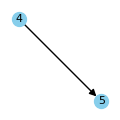

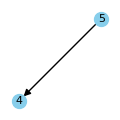

In [8]:
for i in range(0, len(valid_dags_2_gates)):

    G = valid_dags_2_gates[i]
    plt.figure(figsize=(1, 1))
    pos = nx.spring_layout(G)  # Positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
            edge_color='k', linewidths=1, font_size=8, 
            arrows=True, arrowsize=10)
    plt.show()  

In [9]:
extended_dags_2_gates = extend_graph_with_new_nodes_v2(valid_dags_2_gates, new_nodes=[0, 1, 2, 3])

print(f"Number of extended DAGs: {len(extended_dags_2_gates)}")

Number of extended DAGs: 0


In [10]:
(type(extended_dags_2_gates))



dict

In [11]:
import matplotlib.pyplot as plt
import networkx as nx
import math

# Assuming extended_dags_2_gates is your collection of graphs
n_graphs = len(extended_dags_2_gates)  # Total number of graphs

# Calculate the number of rows and columns for the subplot grid
#n_cols = math.ceil(math.sqrt(n_graphs))
n_cols = 8
n_rows = math.ceil(n_graphs / n_cols)

# Set the overall figure size based on the number of columns and rows
# Each subplot is roughly (1, 1) in size, but you might need to adjust the figure size to avoid overlap
fig_size_width = n_cols * 1.5  # Slightly increase the size for margins
fig_size_height = n_rows * 1.5  # Slightly increase the size for margins
plt.figure(figsize=(fig_size_width, fig_size_height))

for i, G in enumerate(extended_dags_2_gates.values(), start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

<Figure size 1200x0 with 0 Axes>

## 3 gates

In [12]:
# Nodes in the graph
nodes = [4, 5, 6]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_3_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_3_gates)}")

Generating DAGs:   0%|          | 0/64 [00:00<?, ?it/s]

Number of valid DAGs: 15


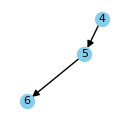

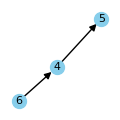

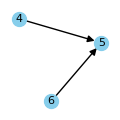

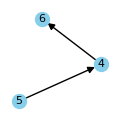

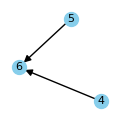

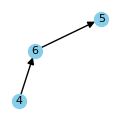

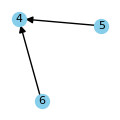

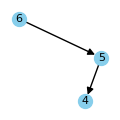

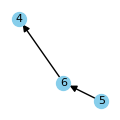

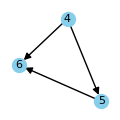

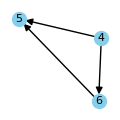

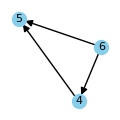

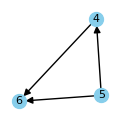

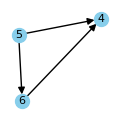

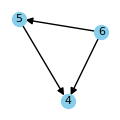

In [13]:
for i in range(0, len(valid_dags_3_gates)):

    G = valid_dags_3_gates[i]
    plt.figure(figsize=(1, 1))
    pos = nx.spring_layout(G)  # Positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
            edge_color='k', linewidths=1, font_size=8, 
            arrows=True, arrowsize=10)
    plt.show()  

In [14]:
extended_dags_3_gates = extend_graph_with_new_nodes_v2(valid_dags_3_gates, new_nodes=[0, 1, 2, 3])

print(f"Number of extended DAGs: {len(extended_dags_3_gates)}")

Number of extended DAGs: 90


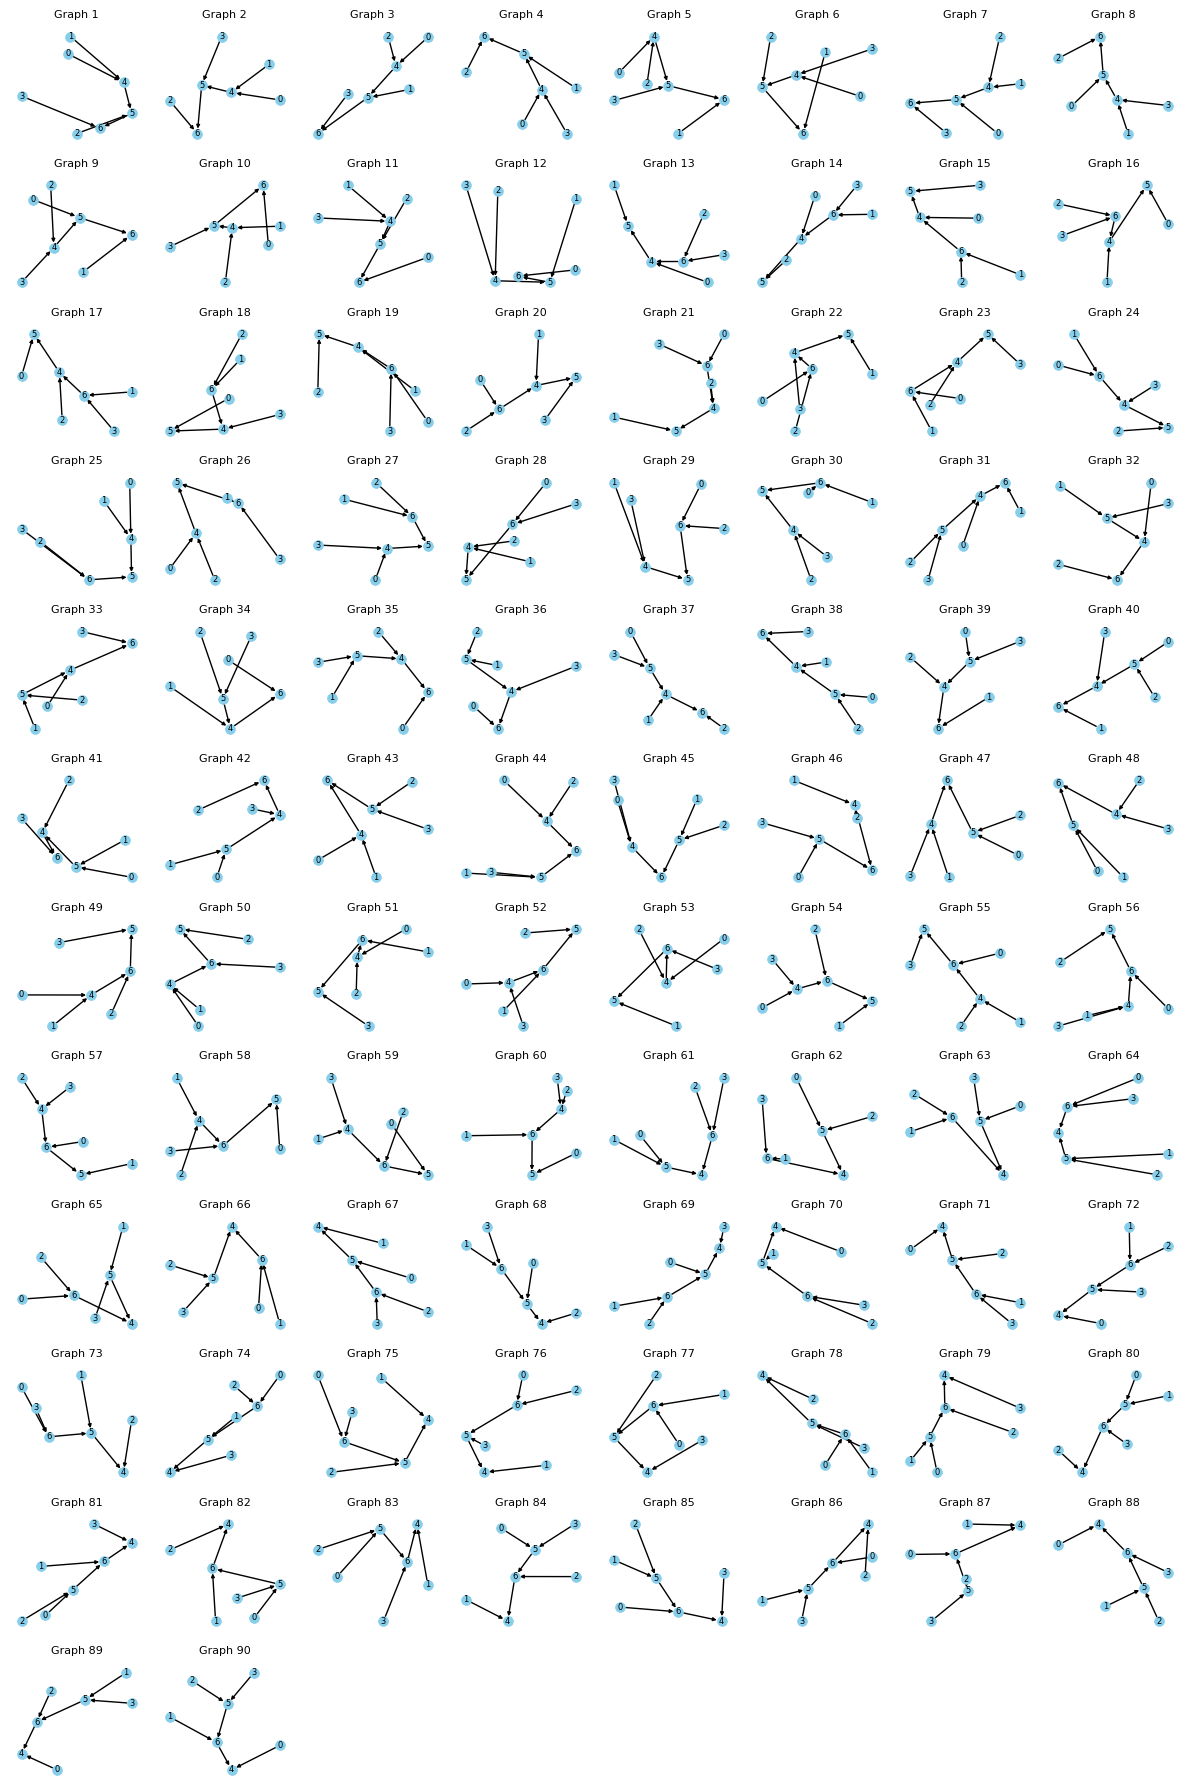

In [15]:
# Assuming extended_dags_3_gates is your collection of graphs
n_graphs = len(extended_dags_3_gates)  # Total number of graphs

# Calculate the number of rows and columns for the subplot grid
#n_cols = math.ceil(math.sqrt(n_graphs))
n_cols = 8
n_rows = math.ceil(n_graphs / n_cols)

# Set the overall figure size based on the number of columns and rows
# Each subplot is roughly (1, 1) in size, but you might need to adjust the figure size to avoid overlap
fig_size_width = n_cols * 1.5  # Slightly increase the size for margins
fig_size_height = n_rows * 1.5  # Slightly increase the size for margins
plt.figure(figsize=(fig_size_width, fig_size_height))

for i, G in enumerate(extended_dags_3_gates.values(), start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

Total graphs: 90
Unique (non-isomorphic) graphs: 2


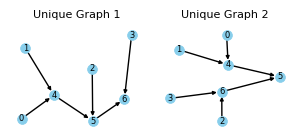

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
import math

# Assuming extended_dags_3_gates is your collection of graphs
def count_unique_graphs(graphs):
    unique_graphs = []
    
    for G in graphs.values():
        if not any(nx.is_isomorphic(G, H) for H in unique_graphs):
            unique_graphs.append(G)
    
    return unique_graphs

# Get the unique graphs
unique_graphs = count_unique_graphs(extended_dags_3_gates)
n_unique_graphs = len(unique_graphs)

print(f"Total graphs: {len(extended_dags_3_gates)}")
print(f"Unique (non-isomorphic) graphs: {n_unique_graphs}")

# Plot the unique graphs
n_cols = 8
n_rows = math.ceil(n_unique_graphs / n_cols)

fig_size_width = n_cols * 1.5  
fig_size_height = n_rows * 1.5  
plt.figure(figsize=(fig_size_width, fig_size_height))

for i, G in enumerate(unique_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5)
    ax.set_title(f"Unique Graph {i}", fontsize=8)

plt.tight_layout()
plt.show()


## 4 gates

In [ ]:
# Nodes in the graph
nodes = [4, 5, 6, 7]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_4_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_4_gates)}")

In [ ]:
extended_dags_4_gates = extend_graph_with_new_nodes_v2_with_progress_bar(valid_dags_4_gates, new_nodes=[0, 1, 2, 3])

print(f"Number of extended DAGs: {len(extended_dags_4_gates)}")

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_4_gates is your list or dictionary of NetworkX graphs
graphs_list = list(extended_dags_4_gates.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
extended_dags_4_gates
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

## 5 gates

In [ ]:
# Nodes in the graph
nodes = [4, 5, 6, 7, 8]

# Generate DAGs with a progress bar suitable for Jupyter Notebooks
valid_dags_5_gates = generate_dags(nodes)

print(f"Number of valid DAGs: {len(valid_dags_5_gates)}")

In [ ]:
#extended_dags_5_gates = extend_graph_with_new_nodes_v2_with_progress_bar(valid_dags_5_gates, new_nodes=[0, 1, 2])

#print(f"Number of extended DAGs: {len(extended_dags_5_gates)}")

In [ ]:
extended_dags_5_gates = extend_graph_with_new_nodes_v2_parallel_streaming(valid_dags_5_gates, new_nodes=[0, 1, 2, 3], batch_size=1000000, max_workers=40, max_pending=80)

print(f"Number of extended DAGs: {len(extended_dags_5_gates)}")

In [ ]:


import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(extended_dags_5_gates.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
extended_dags_5_gates
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()



Joining the lists

In [ ]:
def add_graph_with_running_counter(target_dict, graph, next_key_dict):
    """
    target_dict: dictionary of graphs
    graph: the new graph
    next_key_dict: a dict or object that stores the next key to use, e.g. {"value": 0}
                   This is so we have read/write access to the key
    """
    current_key = next_key_dict["value"]
    target_dict[current_key] = graph
    next_key_dict["value"] += 1

# Initialize an empty container with next_key = 0
graphs_library_4_input_exhaustive = {}
key_tracker = {"value": 0}

# Merge
for d in [extended_dags_3_gates, extended_dags_4_gates, extended_dags_5_gates]:
    for key, graph in d.items():
        add_graph_with_running_counter(graphs_library_4_input_exhaustive, graph, key_tracker)
        

In [ ]:
print("Number of graphs in dictionary:", len(graphs_library_4_input_exhaustive))
print("Some keys:", list(graphs_library_4_input_exhaustive.keys())[500000:500005])




In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(graphs_library_4_input_exhaustive.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
graphs_library_4_input_exhaustive
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

Add output node

In [ ]:
graphs_library_4_input_exhaustive = add_edge_to_sink_nodes_with_output_type(graphs_library_4_input_exhaustive)

In [ ]:
# Assuming extended_dags_5_gates is your list or dictionary of NetworkX graphs
graphs_list = list(graphs_library_4_input_exhaustive.values())  # Convert to list if it's a dictionary

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
graphs_library_4_input_exhaustive
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

Filter out graphs with more than 4 inputs

In [ ]:
graphs_to_remove = []

for graph_key, G in graphs_library_4_input_exhaustive.items():
    # Count nodes with no incoming edges
    no_incoming_edges = [node for node in G.nodes() if G.in_degree(node) == 0]
    
    # If more than 4 nodes have no incoming edges, mark this graph for removal
    if len(no_incoming_edges) != 4:
        graphs_to_remove.append(graph_key)

# Remove the identified graphs from the dictionary
for graph_key in graphs_to_remove:
    del graphs_library_4_input_exhaustive[graph_key]

In [ ]:
len(graphs_library_4_input_exhaustive)

In [ ]:
"""
#Load AIG file from dataset and optimize topology using resyn2
command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; resyn2"'


#Load AIG file from dataset and DO NOT optimize topology
#command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; write_aiger -s /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig"'



result = subprocess.run(command, shell=True, capture_output=True, text=True)
print(result)
"""

Add synthesized with resyn2 (twice)

In [ ]:
import re
import numpy as np
#import matplotlib.pyplot as plt
#import gymnasium as gym
#from gymnasium import spaces
import subprocess

from IPython.display import Image
from graphviz import Source

from IPython.display import Image

#Naive approch using ABC
# Initialize a list to hold all circuit data
circuit_data = []
graphs_library_3_input_ABC = {}

functions = ["resyn2; resyn2"]
graph_index = 0

for function in functions:

    #for i in numbers: #This for statement to run the dataset in random order
    for i in range(1, 255): #This for statement to run the dataset  in order
    #for i in range(1, 10):

        circuit_info = {}

        module_name = format(i, '02X')

        if module_name == '6A':
            print("There is some issue with this file")
            continue


        file_name = f"0x{module_name}"
        print("Circuit: ", file_name)

        #Load AIG file from dataset and optimize topology based on Cello's soure code
        #command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; rewrite; refactor; balance; write_aiger -s /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig"'

        #Load AIG file from dataset and optimize topology using resyn2
        command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; {function};  write_aiger -s /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig"'


        #Load AIG file from dataset and DO NOT optimize topology
        #command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; write_aiger -s /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig"'



        result = subprocess.run(command, shell=True, capture_output=True, text=True)


        command = '~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig; ps"'
        result = subprocess.run(command, shell=True, capture_output=True, text=True)
        stdout_content = result.stdout

        # Use regular expression to find the number of AND nodes
        match = re.search(r'and =\s+(\d+)', stdout_content)
        if match:
            num_and_nodes = int(match.group(1))
            print(f"Number of AND nodes: {num_and_nodes}")

            # Save this number to a file
            with open('num_and_nodes.txt', 'w') as file:
                file.write(str(num_and_nodes))
        else:
            print("Number of AND nodes could not be found.")


        #Convert to ASCII AIG
        subprocess.run('~/aiger/aigtoaig /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aag', shell=True, capture_output=True, text=True)

        start_file_path = '/home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aag'

        #Convert to Adjecency Matrix
        adj_matrix = aiger_ascii_to_adj_matrix(start_file_path)  

        #Convert to NIG
        adj_matrix_negative_edges_replaced = replace_negative_edges(adj_matrix)

        nor_not_graph = covert_to_nor_not(adj_matrix_negative_edges_replaced)

        nor_not_graph_remove_redundant_not = remove_redundant_not_with_exclusions(nor_not_graph)


        num_of_inputs = count_nodes_with_no_incoming_edges_but_not_isolated(nor_not_graph_remove_redundant_not)


        if num_of_inputs != 3:
            print("Number of inputs is not 3. Ignoring this circuit.") 
            continue

        #Generate graph with such assignment
        G = assign_io_nodes(nor_not_graph_remove_redundant_not)

        # Find nodes in G that do not have outgoing edges (output nodes)
        #output_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]

        # There should typically be one output node in a circuit, but it's a good practice to check
        #for node in output_nodes:
        #    # Remove the node(s) from G
        #    G.remove_node(node)


        graphs_library_3_input_ABC[graph_index] = G
        graph_index = graph_index + 1



In [ ]:
len(graphs_library_3_input_ABC)

In [ ]:
# Example to draw the graph for the first circuit
G = graphs_library_3_input_ABC[1]

plt.figure(figsize=(2, 2))
pos = nx.spring_layout(G)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
        edge_color='k', linewidths=1, font_size=8, 
        arrows=True, arrowsize=10)
plt.show()  
print_node_attributes(G)

In [ ]:
Gimportant = nx.DiGraph()

edges = [
    (0, 4), (1, 3), (1, 4), (2, 3), (3, 5), (4, 5), (5, 6)
]
Gimportant.add_node(0)  # Adding a single node
Gimportant.add_node(1)  # Adding a single node
Gimportant.add_node(2)  # Adding a single node

Gimportant.add_edges_from(edges)

Gimportant.nodes[0]['type'] = 'input'
Gimportant.nodes[1]['type'] = 'input'
Gimportant.nodes[2]['type'] = 'input'

Gimportant.nodes[6]['type'] = 'output'

#This code adds Gimportant to graphs_library_3_input_ABC at the end

max_key = max(graphs_library_3_input_ABC.keys())
next_key = max_key + 1
graphs_library_3_input_ABC[next_key] = Gimportant

Import Cello motifs

In [ ]:
import pickle

# Load NIGs_unoptimized_library_3_input_1_output
# Already permuted inputs
with open('Eco1C1G1T1_CelloV2_motifs.pkl', 'rb') as file:
    graphs_library_3_input_cello_V2_motifs = pickle.load(file)   

In [ ]:
len(graphs_library_3_input_cello_V2_motifs)

Join the dictionaries (exhaustive for now)

In [ ]:
def add_graph_with_unique_key(target_dict, graph, original_key):
    """
    Adds a graph to the target dictionary with a unique integer key.
    If original_key is an integer and not already used, it's used;
    otherwise, a new unique integer key is generated.
    """
    # 1) Check if original_key is an integer and not yet in the dictionary
    if isinstance(original_key, int) and original_key not in target_dict:
        target_dict[original_key] = graph
    else:
        # 2) Otherwise, find the next available integer key
        existing_int_keys = [k for k in target_dict.keys() if isinstance(k, int)]
        next_key = max(existing_int_keys, default=-1) + 1
        target_dict[next_key] = graph

# Example usage
graphs_library_4_input = {}
for d in [graphs_library_4_input_exhaustive]:
    for key, graph in d.items():
        add_graph_with_unique_key(graphs_library_4_input, graph, key)



In [ ]:
len(graphs_library_4_input)

In [ ]:
graphs_library_4_input[0]

In [ ]:
for node, attributes in graphs_library_4_input[100000].nodes(data=True):
    print(f"Node: {node}, Attributes: {attributes}")

In [ ]:
#Saving graphs_library_4_input
import pickle

with open("graphs_library_4_input.pkl", "wb") as f:
    pickle.dump(graphs_library_4_input, f)



In [ ]:
#loading 

import pickle

with open("graphs_library_4_input.pkl", "rb") as f:
    graphs_library_4_input = pickle.load(f)

Permute the inputs

In [ ]:
#Note: This may crash the node

import itertools
import networkx as nx
from tqdm import tqdm
def permute_graph_inputs(graph, original_inputs, permutation):
    # Directly use `nx.relabel_nodes` with `copy=True` to generate a new graph.
    mapping = dict(zip(original_inputs, permutation))
    return nx.relabel_nodes(graph, mapping, copy=True)

def generate_permuted_graphs(graphs_library_4_input):
    # 1) Snapshot the original keys so we don't iterate over newly-added graphs.
    original_keys = sorted(graphs_library_4_input.keys())
    
    # 2) Keep track of the next available key manually (avoid repeated `max()`).
    next_key = max(original_keys)
    
    for graph_id in tqdm(original_keys, desc="Permuting graphs"):
        graph = graphs_library_4_input[graph_id]
        
        # Identify all input nodes (assuming they have type='input')
        input_nodes = [n for n, d in graph.nodes(data=True) if d.get('type') == 'input']
        
        # Generate all permutations of the input nodes
        for permutation in itertools.permutations(input_nodes):
            # Skip the identity permutation to avoid re-adding the same graph
            if permutation == tuple(input_nodes):
                continue
            
            # Create the new, permuted graph
            new_graph = permute_graph_inputs(graph, input_nodes, permutation)
            
            # Add this new graph to the dictionary under the next key
            next_key += 1
            graphs_library_4_input[next_key] = new_graph

    return graphs_library_4_input

graphs_library_4_input = generate_permuted_graphs(graphs_library_4_input)


In [9]:
len(graphs_library_4_input)

NameError: name 'graphs_library_4_input' is not defined

In [ ]:
import pickle
import itertools
import networkx as nx
from tqdm import tqdm

def permute_and_store_to_disk(graphs_library_4_input,
                              output_filename="permuted_graphs.pkl",
                              chunk_size=1000):
    """
    Generate all permutations of input nodes for graphs in `graphs_library_4_input`,
    and stream them out to a single pickle file. Does NOT store the new graphs
    in memory or back into `graphs_library_4_input`.
    
    :param graphs_library_4_input: dict of { graph_id: nx.DiGraph or nx.Graph }
    :param output_filename: where to store the newly generated graphs
    :param chunk_size: how many original graphs to process before flushing to disk
    """
    
    # Snapshot the original keys so we don't include newly-generated graphs:
    original_keys = sorted(graphs_library_4_input.keys())
    total_keys = len(original_keys)
    
    # This counter will track how many permuted graphs are written to disk
    permuted_count = 0
    
    # Open the output file in binary write mode.
    with open(output_filename, 'wb') as f_out:
        
        # Process the original keys in chunks to limit memory use.
        for i in range(0, total_keys, chunk_size):
            chunk_keys = original_keys[i : i + chunk_size]
            
            # Provide a progress bar for the current chunk
            chunk_desc = f"Chunk {i//chunk_size + 1}/{(total_keys - 1)//chunk_size + 1}"
            for graph_id in tqdm(chunk_keys, desc=chunk_desc, leave=False):
                graph = graphs_library_4_input[graph_id]
                
                # Identify input nodes
                input_nodes = [n for n, d in graph.nodes(data=True) 
                               if d.get('type') == 'input']
                
                # Permute them
                for permutation in itertools.permutations(input_nodes):
                    # Skip the identity permutation to avoid duplicates
                    if permutation == tuple(input_nodes):
                        continue
                    
                    # Create the new permuted graph
                    mapping = dict(zip(input_nodes, permutation))
                    new_graph = nx.relabel_nodes(graph, mapping, copy=True)
                    
                    # Write the new_graph directly to the pickle file
                    pickle.dump(new_graph, f_out, protocol=pickle.HIGHEST_PROTOCOL)
                    
                    # Increment our counter
                    permuted_count += 1
            
            # Attempt to free memory from intermediate structures
            import gc
            gc.collect()
    
    print(f"\nDone! {permuted_count} permuted graphs have been written to {output_filename}.\n")

# Example usage:
permute_and_store_to_disk(graphs_library_4_input, output_filename="permuted_graphs.pkl", chunk_size=1000000)


In [10]:
def load_permuted_graphs_from_disk(pkl_filename):
    """Returns a generator that yields graphs from the pickle file."""
    import pickle
    
    with open(pkl_filename, 'rb') as f_in:
        while True:
            try:
                yield pickle.load(f_in)
            except EOFError:
                break

# Example usage:
# for g in load_permuted_graphs_from_disk("permuted_graphs.pkl"):
#     # Do something with g


In [12]:
#This counts the graphs
import pickle

def count_graphs_in_pickle(pkl_filename):
    count = 0
    with open(pkl_filename, "rb") as f:
        while True:
            try:
                pickle.load(f)
                count += 1
            except EOFError:
                break
    return count

count = count_graphs_in_pickle("permuted_graphs.pkl")
print(count)

KeyboardInterrupt: 

In [ ]:
load_permuted_graphs_from_disk("permuted_graphs.pkl")

In [ ]:
import pickle 

with open("permuted_graphs.pkl", "rb") as f:
    graphs_library_4_input = pickle.load(f)  

In [ ]:
len(graphs_library_4_input)

In [ ]:
for g in load_permuted_graphs_from_disk("permuted_graphs.pkl"): 
    print(g)
    precomputed_graphs_4_input(g)
    

Organize by truth table (Boolean function)

In [ ]:
def is_graph_isomorphic(new_graph, existing_graph_ids, all_graphs):
    """
    Check if 'new_graph' is isomorphic to any graph in the list 'existing_graph_ids'.
    'all_graphs' is a list of all graphs loaded from pickle, where the index is the ID.
    """
    for g_id in existing_graph_ids:
        candidate_graph = all_graphs[g_id]
        if nx.is_isomorphic(new_graph, candidate_graph):
            return True
    return False

# 1) Load all permuted graphs from the pickle file into a list:
graphs = []
with open("permuted_graphs.pkl", "rb") as f:
    # We create a progress bar with an unknown total (since we read until EOF).
    pbar_load = tqdm(desc="Loading graphs from pickle", unit=" graphs")
    while True:
        try:
            g = pickle.load(f)
            graphs.append(g)
            pbar_load.update(1)
        except EOFError:
            break
    pbar_load.close()

print(f"Finished loading {len(graphs)} graphs from permuted_graphs.pkl.")

# 2) Classify them by truth table
precomputed_graphs_4_input = {}  # { truth_table_index -> list of graph IDs }

pbar_classify = tqdm(enumerate(graphs), total=len(graphs), desc="Classifying graphs")
for graph_id, G in pbar_classify:
    truth_table = calculate_truth_table(G)
    truth_table_index = truth_table_to_index(truth_table)
    
    if truth_table_index not in precomputed_graphs_4_input:
        # First time we see this truth table index
        precomputed_graphs_4_input[truth_table_index] = [graph_id]
    else:
        existing_ids = precomputed_graphs_4_input[truth_table_index]
        if not is_graph_isomorphic(G, existing_ids, graphs):
            existing_ids.append(graph_id)
pbar_classify.close()

print("Finished classifying graphs by truth table!")
print("Number of unique truth table classes:", len(precomputed_graphs_4_input))

In [ ]:
#This one does not work anymore: 

precomputed_graphs_4_input = {}

# Function to check if a graph is isomorphic to any graph in a list
def is_graph_isomorphic(new_graph, graph_list, graphs_library):
    for graph_id in graph_list:
        # Retrieve a graph from the library using its identifier
        G = graphs_library[graph_id]
        # Check if the ffnew graph is isomorphic to this graph
        if nx.is_isomorphic(new_graph, G):
            #print("Graph is isomorphic")
            return True  # Found an isomorphic graph
    return False  # No isomorphic graph found

for graph_id, G in graphs_library_4_input.items():
    truth_table = calculate_truth_table(G)
    truth_table_index = truth_table_to_index(truth_table)
    
    # If the truth table index is new, initialize with the current graph ID
    if truth_table_index not in precomputed_graphs_4_input:
        precomputed_graphs_4_input[truth_table_index] = [graph_id]
    else:
        # For existing truth table index, check for isomorphism only if more than 1 graph already exists for this index
        if len(precomputed_graphs_4_input[truth_table_index]) >= 1:
            if not is_graph_isomorphic(G, precomputed_graphs_4_input[truth_table_index], graphs_library_4_input):
                precomputed_graphs_4_input[truth_table_index].append(graph_id)
        else:
            # If it's the first graph being compared for this truth table index, add it without isomorphism check
            precomputed_graphs_4_input[truth_table_index].append(graph_id)

Save the library

In [ ]:
for key in precomputed_graphs_4_input:
    print(key)

In [ ]:
precomputed_graphs_4_input

In [ ]:
len(precomputed_graphs_4_input)

In [ ]:
total_items = sum(len(items) for items in precomputed_graphs_4_input.values())
print(f"Total number of items: {total_items}")

In [ ]:
import pickle

# Save graphs_library_3_input
with open('graphs_library_4_input_4_2.pkl', 'wb') as file:
    pickle.dump(graphs_library_4_input, file)

# Save precomputed_graphs_3_input
with open('precomputed_graphs_4_input_4_2.pkl', 'wb') as file:
    pickle.dump(precomputed_graphs_4_input, file)


### Generate library of unoptimized NIGs of 3-input 1-output circuits

In [ ]:
import re
#Naive approch using ABC
# Initialize a list to hold all circuit data
circuit_data = []
NIGs_unoptimized_library_3_input_1_output = {}
#for i in numbers: #This for statement to run the dataset in random order
for i in range(1, 255): #This for statement to run the dataset  in order
    
    circuit_info = {}
    
    module_name = format(i, '02X')
    
    if module_name == '6A':
        print("There is some issue with this file")
        continue
       
   
    file_name = f"0x{module_name}"
    print("Circuit: ", file_name)
    
    #Load AIG file from dataset and optimize topology based on Cello's soure code
    #command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; rewrite; refactor; balance; write_aiger -s /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig"'
    
    #Load AIG file from dataset and optimize topology using resyn2
    command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; write_aiger -s /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig"'
          
        
    #Load AIG file from dataset and DO NOT optimize topology
    #command = f'~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_3_input_1_output_truth_tables_as_AIGs/{file_name}.aig; write_aiger -s /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig"'
    
   
    
    result = subprocess.run(command, shell=True, capture_output=True, text=True)

    
    command = '~/abc/abc -c "read /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig; ps"'
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    stdout_content = result.stdout

    # Use regular expression to find the number of AND nodes
    match = re.search(r'and =\s+(\d+)', stdout_content)
    if match:
        num_and_nodes = int(match.group(1))
        print(f"Number of AND nodes: {num_and_nodes}")

        # Save this number to a file
        with open('num_and_nodes.txt', 'w') as file:
            file.write(str(num_and_nodes))
    else:
        print("Number of AND nodes could not be found.")
        

    #Convert to ASCII AIG
    subprocess.run('~/aiger/aigtoaig /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aig /home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aag', shell=True, capture_output=True, text=True)

    start_file_path = '/home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/TEST.aag'

    #Convert to Adjecency Matrix
    adj_matrix = aiger_ascii_to_adj_matrix(start_file_path)  

    #Convert to NIG
    adj_matrix_negative_edges_replaced = replace_negative_edges(adj_matrix)

    nor_not_graph = covert_to_nor_not(adj_matrix_negative_edges_replaced)

    nor_not_graph_remove_redundant_not = remove_redundant_not_with_exclusions(nor_not_graph)
    
    
    num_of_inputs = count_nodes_with_no_incoming_edges_but_not_isolated(nor_not_graph_remove_redundant_not)

    
    if num_of_inputs != 3:
        print("Number of inputs is not 3. Ignoring this circuit.") 
        continue

    #Generate graph with such assignment
    G = assign_io_nodes(nor_not_graph_remove_redundant_not)
    
    # Find nodes in G that do not have outgoing edges (output nodes)
    #output_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]

    # There should typically be one output node in a circuit, but it's a good practice to check
    #for node in output_nodes:
    #    # Remove the node(s) from G
    #    G.remove_node(node)
    
    
    NIGs_unoptimized_library_3_input_1_output[i] = G



In [ ]:
NIGs_unoptimized_library_3_input_1_output = None

In [ ]:
import pickle

# Save NIGs_unoptimized_library_3_input_1_output
with open('NIGs_unoptimized_library_3_input_1_output.pkl', 'wb') as file:
    pickle.dump(NIGs_unoptimized_library_3_input_1_output, file)

In [ ]:
import pickle

# Load NIGs_unoptimized_library_3_input_1_output
with open('NIGs_unoptimized_library_3_input_1_output.pkl', 'rb') as file:
    NIGs_unoptimized_library_3_input_1_output = pickle.load(file)



In [ ]:
NIGs_unoptimized_library_3_input_1_output

In [ ]:
G = NIGs_unoptimized_library_3_input_1_output[205]
visualize_graph_rewriting(G)
calculate_truth_table_v2(G)